# Predict Human wine taste preference based on analytical data

This open source dataset was adopted from https://www.kaggle.com/datasets/rajyellow46/wine-quality.
It is comprised out of two joined datasets, red and white wine samples from the vinho verde , Portugal. Each sample was analysed for its chemical attributes and was then subjected to eveluation by minimum of three sensory assesors (blind tastes) which graded the wine 0 - 10. <br>  In this project we will train our model on the "Quality" column and predict if a wine qualifies as "Premium" on the test fraction of the dataset.

## Initializing

In [ ]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# For transformations and predictions
from sklearn.metrics import accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import warnings

# For the tree visualization
import pydot
from IPython.display import Image

#from sklearn.externals.six import StringIO
from io import StringIO
import io
!pip install pydot
import pydot
from IPython.display import Image

# For the dimensionality reduction
from sklearn.feature_selection import SelectKBest, f_classif

# For scoring
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

from imblearn.ensemble import BalancedRandomForestClassifier
from pickle import FALSE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# premutation
%pip install -q eli5
import eli5
from eli5.sklearn import PermutationImportance

#Shap
!pip install shap
import shap

while True:
    try:
        import altair as alt
        break
    except ModuleNotFoundError:
        !pip install altair

alt.data_transformers.disable_max_rows()

     |████████████████████████████████| 106 kB 16.8 MB/s 
     |████████████████████████████████| 564 kB 6.7 MB/s 


DataTransformerRegistry.enable('default')

## Data

### Uploading the data

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
url = 'https://drive.google.com/file/d/1JcbLv6rdoEZqY38uZgoh_Jw5ZmYWgsVn'
gdd.download_file_from_google_drive(
    url.split('/')[-1], './winequalityN.csv')

df = pd.read_csv("winequalityN.csv")
df.head(6)

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   
5  white            8.1              0.28         0.40             6.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   
5      0.050                 30.0                  97.0   0.9951  3.26   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6  
5       0.44     10.1        6

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


# Functions

This chapter contains the repository of functions we will use later in the project

### heatmap

In [ ]:
def plot_corr_heatmap(df):


    corr = df.corr().reset_index().melt(id_vars='index')
    sort = dict(zip(df.columns, list(range(len(df.columns)))))

    heatmap = alt.Chart(corr).mark_rect(
        stroke='black'
    ).transform_calculate(
        order_rows='%s [datum.index]' % sort,
        order_cols='%s [datum.variable]' % sort
    ).transform_filter(
        alt.datum.order_rows <= alt.datum.order_cols
    ).encode(
        alt.X('index:N', title=None, sort=list(sort.keys())),
        alt.Y('variable:N', title=None, sort=list(sort.keys())),
        alt.Color('value:Q', scale=alt.Scale(
            scheme='redyellowblue', reverse=True))
    ).properties(width=600, height=600)

    text = heatmap.mark_text(
        size=13
    ).encode(
        alt.Text('value:Q', format='.2f'),
        color=alt.value('white')
    )

    return heatmap + text

### visualizing trees

In [ ]:
def visualize_tree(model, md=3, i=0, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(model.estimators_[i],
            max_depth=md,
            feature_names=df.drop(columns='quality').columns,
            label='all',
            filled=True,
            rounded=True, 
            fontsize=12);

##histogram

In [ ]:
def plot_histogram(df, col, ret_stdev=False):
   
    
    stdev = df[col].std()
    hist = alt.Chart(
        df, title = ('', f'{col} stdev: {stdev:.4f}')[ret_stdev]
    ).mark_rect(
        opacity=0.7, color='red', stroke='red'
    ).encode(
        x=alt.X(f'{col}:Q', bin=alt.Bin(maxbins=10), title=''),
        y=alt.Y('count()', title=''),
    )

    avg = alt.Chart(df).mark_rule().encode(
        x=alt.X(f'mean({col}):Q', title=''),
        color=alt.value('blue'),
        size=alt.value(2)
    )

    plot = hist+avg

    if ret_stdev:
        return plot, stdev

    return plot

##permutation feature importance

In [ ]:
def permutation_test(df=df,max_sample=0.5):
    y=(df['quality']=='premium')
    feature_names = [i for i in df.drop(columns='quality').columns]
    X = df[feature_names]
    X_train, X_test, y_train, y_test = split(X, y, train_size=0.80, 
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=555555 ,
                                                    stratify=y)
    model = RandomForestClassifier(oob_score=True, max_samples=max_sample, n_estimators=100).fit(X_train, y_train)

    print(model.oob_score_, 
    model.score(X_test, y_test), 
    model.score(X_train, y_train))
    perm = PermutationImportance(model, random_state=555555).fit(X_train, y_train)
    # eli5.show_weights(perm, feature_names = X_train.columns.tolist())
    return eli5.show_weights(perm, feature_names = X_train.columns.tolist())

## test_df

In [ ]:
def test_df(df, target='quality', max_samples=0.5, ib=False):
    X = df.copy().drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = split(X, y, train_size=0.80, 
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=555555 ,
                                                    stratify=y)
# over sampling
    if ib:
        p_index=y_train[y_train=='premium'].index
        p=X_train.loc[p_index]
        n1=pd.concat([p]*10)
        X_train = pd.concat([X_train, n1])
        y_train = y_train.loc[X_train.index]
    else:
        pass
    
    model = RandomForestClassifier(oob_score=True, max_samples=max_samples, n_estimators=100)
    # return X_train, y_train
    
    def evaluate(
        model, 
        X, 
        y, 
        stage, 
        proba=True, 
        pairplot=False, 
        pairplot_max_samples=500,
        pairplot_max_features=6,
        ):
        if proba:
            y_pred = pd.DataFrame(
                     data=model.predict_proba(X), 
                     index=X.index,
                     columns=model.classes_
                     )
      
            loss = log_loss(y, y_pred)
            y_pred_labels = y_pred.idxmax(axis=1)

            print(f'loss: {loss:.4f}')
        else:
            y_pred = pd.DataFrame(
                     data=model.predict(X), 
                     index=X.index,
                     columns=[y.name]
                     )
            y_pred_labels = model.predict(X)
        print(classification_report(y, y_pred_labels, target_names=model.classes_))
        print()
        if pairplot:
            # remove _is_missing columns
            relevant_columns = X.columns[~X.columns.str.endswith('_is_missing')]
            if pairplot_max_features:
                feature_importances = pd.Series(
                    model.feature_importances_, 
                    index=model.feature_names_in_
                    ).sort_values().tail(pairplot_max_features)
                
                print("dropping less important features from pairplot")
                print(relevant_columns)
                relevant_columns = relevant_columns[relevant_columns.isin(feature_importances.index)] 
                print(relevant_columns)

            errors_df = X[relevant_columns]
            errors_df = errors_df.assign(**{target:y, 'pred':y_pred_labels})
            errors_df = errors_df.assign(confusion=errors_df[target] + '-' + errors_df.pred)

            if pairplot_max_samples:
                errors_df = errors_df.sample(pairplot_max_samples)

            sns.pairplot(
                data=errors_df,
                hue='confusion'
                )
            plt.savefig(f'{stage}.jpg')
            plt.close()  # prevents figure from being displayed when code cell is executed


    def fit_evaluate(model, X_train, y_train, X_test, y_test, pairplot=False):

        model.fit(X_train, y_train)
    
        print()
        print('TRAIN:')
        print(y_train.value_counts())
        evaluate(model, X_train, y_train, 'train', proba=True, pairplot=pairplot)

        print()
        print('TEST:')
        print(y_test.value_counts())
        evaluate(model, X_test, y_test, 'test', proba=True, pairplot=pairplot)

        plt.figure(figsize=(20,30))
        plt.subplot(3,1,1)
        feature_importances = pd.Series(
            model.feature_importances_, 
            index=model.feature_names_in_
            ).sort_values().tail(12)
        feature_importances.plot.barh()
    
        if pairplot:
            plt.subplot(3,1,2)
            plt.title('Train confusion')
            plt.imshow(mpimg.imread('train.jpg'))
        
            plt.subplot(3,1,2)
            plt.title('Test confusion')
            plt.imshow(mpimg.imread('test.jpg'))

    return fit_evaluate(model, X_train, y_train, X_test, y_test)
    # return model, y_test, y_test_pred
    

#Target column - quality

Our desired target predicting "Premium" wines, based on the "Quality" column.<br> Each sample was evaluated by a minimum of three sensory assesors (using blind tastes).<br> It can be seen that the wine's grades ranged from 0 (Poor) - 10 (excellent). <br> As described in the figures below in our data the actual range was 3-9 (white) and 3-8 (Red).

In [ ]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [ ]:
plot_histogram(df, 'quality', ret_stdev=False)

alt.LayerChart(...)

In [ ]:
df[df['type']=='white']['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [ ]:
df[df['type']=='red']['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

## "Premium"/"non-Premium"

We noticed that there are much more "normal" wines then "Poor" or "excellent" wines. Thus, we decided to classify the qulaity of the wines as follows: <br> Premium = Quality score of 7-9 <br> Non-Premium = Quality score of 3-6

In [ ]:
df.loc[df['quality'] < 7, 'quality'] = 0.99999999
df.loc[df['quality'] > 6, 'quality'] = 999999
df=df.replace(to_replace =["white", "red",0.99999999,999999], 
                            value =[0,1,'not_premium','premium'])


In [ ]:
round(len(df[df['quality']=='premium'])/len(df)*100,2)

19.66

The data has ~20% of Premium wines

### dropping nulls

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [ ]:
df.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [ ]:
round((10+10+5+9+4)/len(df)*100,2)

0.58

As we had very faw nulls (less then 0.5%)  entries, we decided to remove them.

In [ ]:
df.dropna(inplace=True)
df

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0        0            7.0             0.270         0.36            20.7   
1        0            6.3             0.300         0.34             1.6   
2        0            8.1             0.280         0.40             6.9   
3        0            7.2             0.230         0.32             8.5   
4        0            7.2             0.230         0.32             8.5   
...    ...            ...               ...          ...             ...   
6491     1            6.8             0.620         0.08             1.9   
6492     1            6.2             0.600         0.08             2.0   
6494     1            6.3             0.510         0.13             2.3   
6495     1            5.9             0.645         0.12             2.0   
6496     1            6.0             0.310         0.47             3.6   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0         0.045                 45.0                 170.0  1.00100  3.00   
1         0.049                 14.0                 132.0  0.99400  3.30   
2         0.050                 30.0                  97.0  0.99510  3.26   
3         0.058                 47.0                 186.0  0.99560  3.19   
4         0.058                 47.0                 186.0  0.99560  3.19   
...         ...                  ...                   ...      ...   ...   
6491      0.068                 28.0                  38.0  0.99651  3.42   
6492      0.090                 32.0                  44.0  0.99490  3.45   
6494      0.076                 29.0                  40.0  0.99574  3.42   
6495      0.075                 32.0                  44.0  0.99547  3.57   
6496      0.067                 18.0                  42.0  0.99549  3.39   

      sulphates  alcohol      quality  
0          0.45      8.8  not_premium  
1          0.49      9.5  not_premium  
2          0.44     10.1  not_premium  
3          0.40      9.9  not_premium  
4          0.40      9.9  not_premium  
...         ...      ...          ...  
6491       0.82      9.5  not_premium  
6492       0.58     10.5  not_premium  
6494       0.75     11.0  not_premium  
6495       0.71     10.2  not_premium  
6496       0.66     11.0  not_premium  

[6463 rows x 13 columns]

##Proba threshold

0.8543520309477757 0.8646558391337974 0.9152804642166344
desired recall =  0.7
threshold for desired recall: proba >=  0.47
max precision at this point:  0.9116883116883117
train classification report at proba >=  0.47
              precision    recall  f1-score   support

       False       0.93      0.98      0.96      4153
        True       0.91      0.69      0.79      1017

    accuracy                           0.93      5170
   macro avg       0.92      0.84      0.87      5170
weighted avg       0.93      0.93      0.92      5170

test classification report at proba >=  0.47
              precision    recall  f1-score   support

       False       0.87      0.97      0.92      1039
        True       0.76      0.43      0.55       254

    accuracy                           0.86      1293
   macro avg       0.82      0.70      0.73      1293
weighted avg       0.85      0.86      0.85      1293



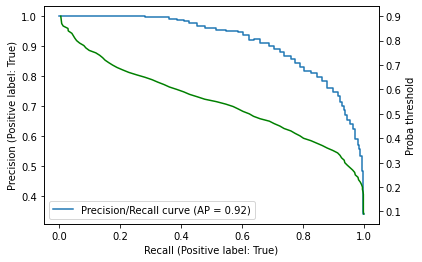

In [ ]:
y=(df['quality']=='premium')
X = df.drop(columns='quality')
X_train, X_test, y_train, y_test = split(X, y, train_size=0.80, 
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=555555 ,
                                                    stratify=y)

model = RandomForestClassifier(oob_score=True, max_samples=0.2, n_estimators=100).fit(X_train, y_train)

print(model.oob_score_, 
    model.score(X_test, y_test), 
    model.score(X_train, y_train))

display = PrecisionRecallDisplay.from_estimator(
    model, X_train, y_train, name="Precision/Recall curve"
)

y_train_proba = model.predict_proba(X_train)[:,-1]
precision, recall, thresholds = \
    precision_recall_curve(y_train, y_train_proba) 
# fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
# fpr, tpr, thresholds = fpr[1:], tpr[1:], thresholds[1:]
# thresholds.shape, precision.shape

ax = plt.twinx()
ax.plot(recall[:-1], thresholds, 'g-', label='Recall/Threhold')
ax.set_ylabel('Proba threshold')

desired_recall = 0.7
print('desired recall = ', desired_recall)
idx_of_desired_recall = len(recall[recall>=desired_recall])

desired_threshold = thresholds[idx_of_desired_recall]
print('threshold for desired recall: proba >= ', desired_threshold)
print('max precision at this point: ', precision[idx_of_desired_recall])

print('train classification report at proba >= ', desired_threshold)
print(
    classification_report(y_train, y_train_proba>=desired_threshold)
    )

print('test classification report at proba >= ', desired_threshold)
y_test_proba = model.predict_proba(X_test)[:,1]
y_test_pred = y_test_proba>=desired_threshold
print(
    classification_report(y_test, y_test_pred)
    )

Based on the calculated probablity, we are setting a prerequirement of: <br> recall value = 0.7 <br> Meaning, we aim to predict at least 70% of the actual premium wines.<br> In addition we will monitor the:<br> Premium f1 (test) / Premium f1 (Train) 

# Model #1

Under the assumption that the dataset is not extensive, we first ran "Naive" model: <br> max_samples = 0.97 <br> train/test size = 80/20




TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.0769
              precision    recall  f1-score   support

 not_premium       1.00      1.00      1.00      4153
     premium       1.00      1.00      1.00      1017

    accuracy                           1.00      5170
   macro avg       1.00      1.00      1.00      5170
weighted avg       1.00      1.00      1.00      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.2798
              precision    recall  f1-score   support

 not_premium       0.90      0.97      0.93      1039
     premium       0.80      0.55      0.65       254

    accuracy                           0.88      1293
   macro avg       0.85      0.76      0.79      1293
weighted avg       0.88      0.88      0.88      1293




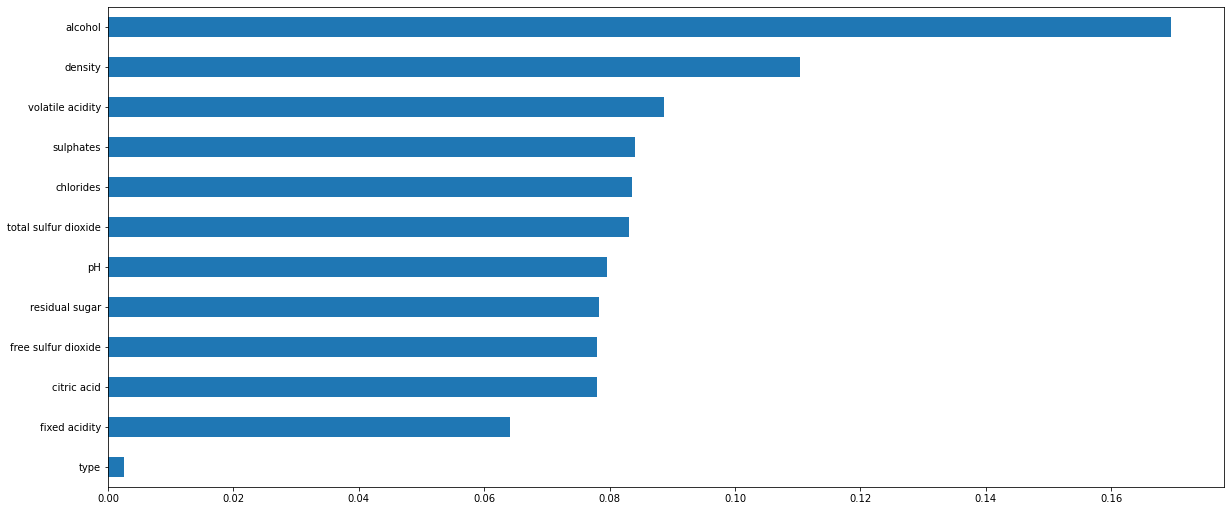

In [ ]:
test_df(df,'quality',0.97)

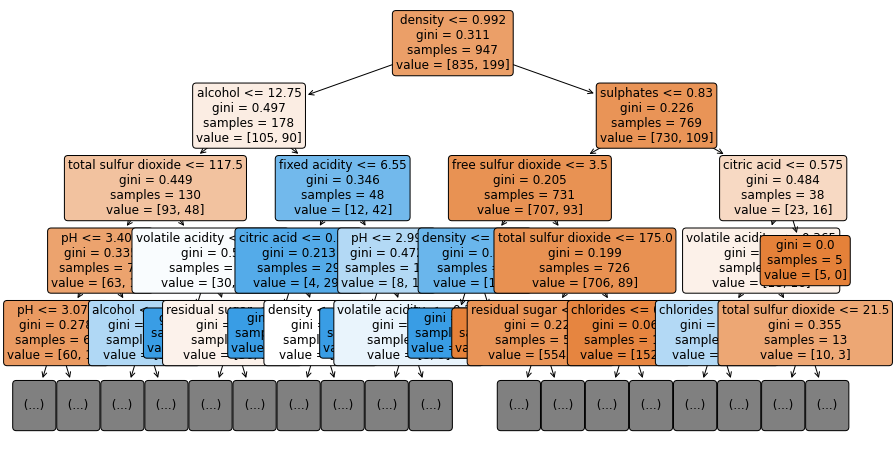

In [ ]:
visualize_tree(model, md=4, i=33, fs=(15,8))

The confusion metrices shows
 that these parameters resulted in a highly overfitted model on the train data. This configuration can not be generalized efficiantly to the test data. 

#Model #2

In order to reduce this ovrtfitted model,  we ran this model with  max_samples = 0.5


TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3234
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.93      1039
     premium       0.82      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293




type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0        0            7.0             0.270         0.36            20.7   
1        0            6.3             0.300         0.34             1.6   
2        0            8.1             0.280         0.40             6.9   
3        0            7.2             0.230         0.32             8.5   
4        0            7.2             0.230         0.32             8.5   
...    ...            ...               ...          ...             ...   
6491     1            6.8             0.620         0.08             1.9   
6492     1            6.2             0.600         0.08             2.0   
6494     1            6.3             0.510         0.13             2.3   
6495     1            5.9             0.645         0.12             2.0   
6496     1            6.0             0.310         0.47             3.6   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0         0.045                 45.0                 170.0  1.00100  3.00   
1         0.049                 14.0                 132.0  0.99400  3.30   
2         0.050                 30.0                  97.0  0.99510  3.26   
3         0.058                 47.0                 186.0  0.99560  3.19   
4         0.058                 47.0                 186.0  0.99560  3.19   
...         ...                  ...                   ...      ...   ...   
6491      0.068                 28.0                  38.0  0.99651  3.42   
6492      0.090                 32.0                  44.0  0.99490  3.45   
6494      0.076                 29.0                  40.0  0.99574  3.42   
6495      0.075                 32.0                  44.0  0.99547  3.57   
6496      0.067                 18.0                  42.0  0.99549  3.39   

      sulphates  alcohol      quality  
0          0.45      8.8  not_premium  
1          0.49      9.5  not_premium  
2          0.44     10.1  not_premium  
3          0.40      9.9  not_premium  
4          0.40      9.9  not_premium  
...         ...      ...          ...  
6491       0.82      9.5  not_premium  
6492       0.58     10.5  not_premium  
6494       0.75     11.0  not_premium  
6495       0.71     10.2  not_premium  
6496       0.66     11.0  not_premium  

[6463 rows x 13 columns]

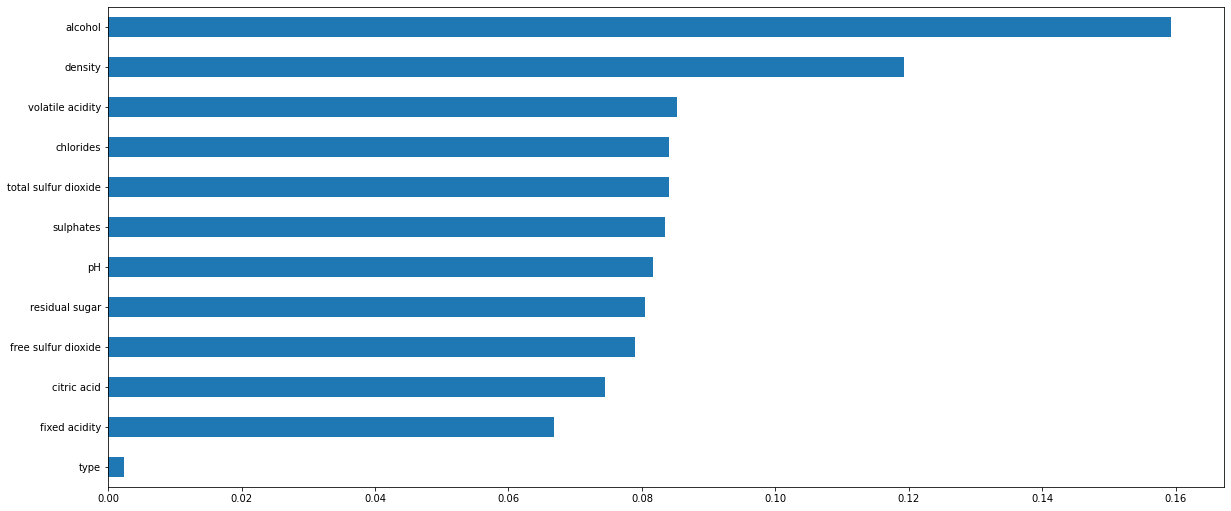

In [ ]:
test_df(df,'quality',0.5)
df

Indeed, the results show a better fit on the train data. Thus, we will use this run as a banchmark for the rest of the project. 
<br> Recall = 0.48
<br> f1 ratio = 0.62

# Split into white and red

Our preliminary assumption was that the "type" column would have great importance. However, results of Model#2 feature importance showed the opposite. In order to validate our hypothesis we divided the data into two datasets; white wine and red wines. 

In [ ]:
df_white=df[df['type']==0]
df_white.drop(columns='type',inplace=True)
df_white.describe()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4870.000000       4870.000000  4870.000000     4870.000000   
mean        6.855123          0.278071     0.334199        6.394343   
std         0.843444          0.100528     0.120915        5.070853   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4870.000000          4870.000000           4870.000000  4870.000000   
mean      0.045771            35.317146            138.340144     0.994026   
std       0.021846            17.012967             42.490515     0.002993   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991720   
50%       0.043000            34.000000            134.000000     0.993735   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  4870.000000  4870.000000  4870.000000  
mean      3.188154     0.489700    10.516772  
std       0.150902     0.114196     1.231251  
min       2.720000     0.220000     8.000000  
25%       3.090000     0.410000     9.500000  
50%       3.180000     0.470000    10.400000  
75%       3.280000     0.550000    11.400000  
max       3.820000     1.080000    14.200000


TRAIN:
not_premium    3053
premium         843
Name: quality, dtype: int64
loss: 0.1559
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      3053
     premium       1.00      0.90      0.94       843

    accuracy                           0.98      3896
   macro avg       0.98      0.95      0.97      3896
weighted avg       0.98      0.98      0.98      3896



TEST:
not_premium    763
premium        211
Name: quality, dtype: int64
loss: 0.3110
              precision    recall  f1-score   support

 not_premium       0.88      0.96      0.92       763
     premium       0.79      0.54      0.64       211

    accuracy                           0.87       974
   macro avg       0.84      0.75      0.78       974
weighted avg       0.86      0.87      0.86       974




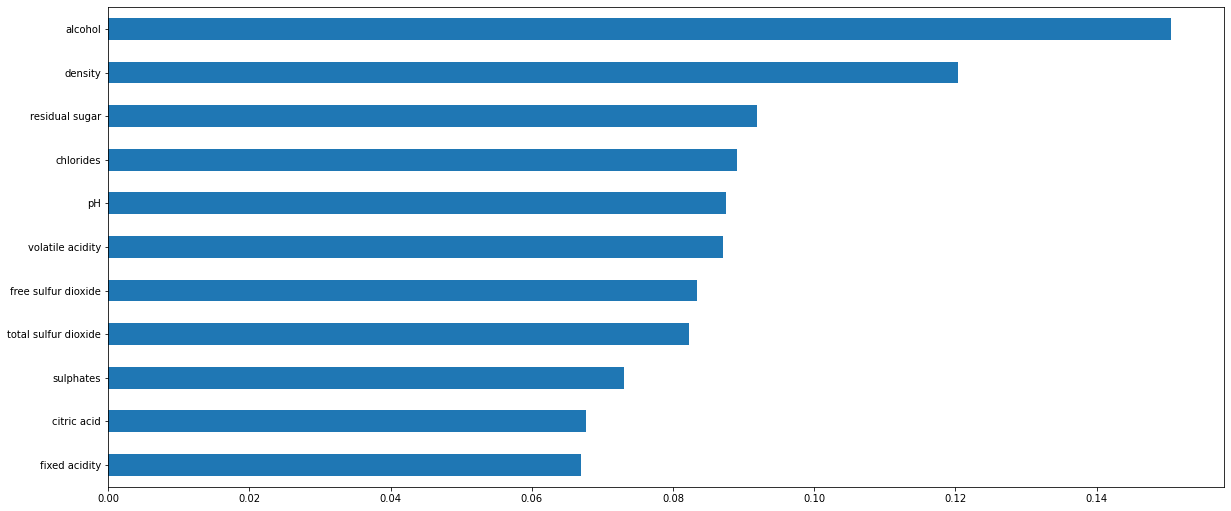

In [ ]:
test_df(df_white)

Results:
<br> Recall = 0.54
<br> f1 ratio = 0.68

In [ ]:
df_red=df[df['type']==1]
df_red.drop(columns='type',inplace=True)
df_red.describe()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1593.000000       1593.000000  1593.000000     1593.000000   
mean        8.326365          0.527659     0.271551        2.538512   
std         1.740681          0.179297     0.194843        1.412061   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1593.000000          1593.000000           1593.000000  1593.000000   
mean      0.087497            15.841808             46.463905     0.996752   
std       0.047134            10.436038             32.913696     0.001888   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997850   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol  
count  1593.000000  1593.000000  1593.000000  
mean      3.310590     0.657866    10.419617  
std       0.154305     0.169716     1.065206  
min       2.740000     0.330000     8.400000  
25%       3.210000     0.550000     9.500000  
50%       3.310000     0.620000    10.200000  
75%       3.400000     0.730000    11.100000  
max       4.010000     2.000000    14.900000


TRAIN:
not_premium    1100
premium         174
Name: quality, dtype: int64
loss: 0.1150
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      1100
     premium       1.00      0.86      0.92       174

    accuracy                           0.98      1274
   macro avg       0.99      0.93      0.96      1274
weighted avg       0.98      0.98      0.98      1274



TEST:
not_premium    276
premium         43
Name: quality, dtype: int64
loss: 0.3287
              precision    recall  f1-score   support

 not_premium       0.90      0.99      0.94       276
     premium       0.81      0.30      0.44        43

    accuracy                           0.90       319
   macro avg       0.86      0.65      0.69       319
weighted avg       0.89      0.90      0.88       319




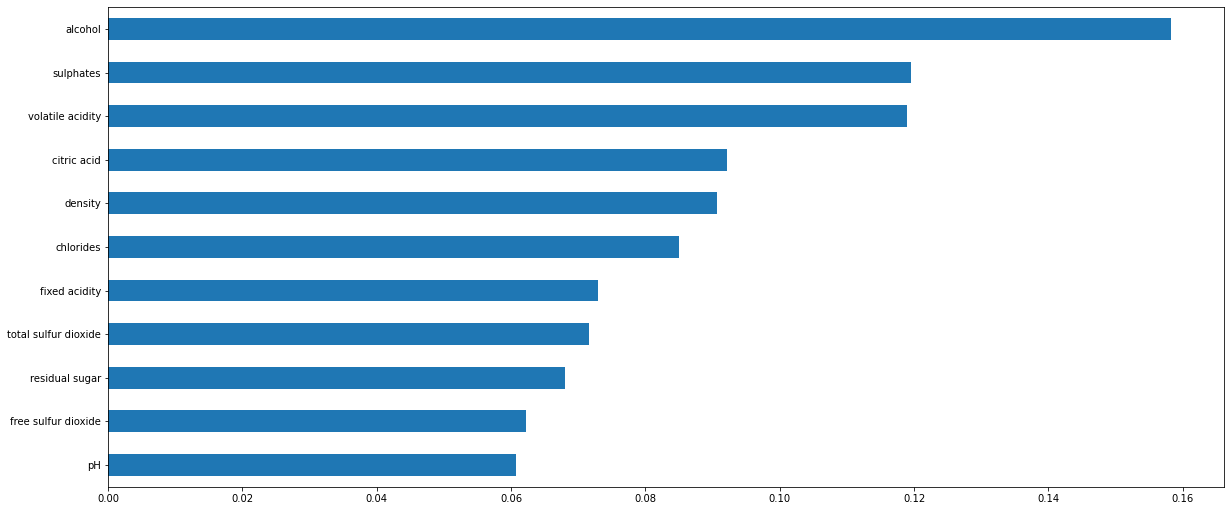

In [ ]:
test_df(df_red)

Results:
<br> Recall = 0.3
<br> f1 ratio = 0.45

Results on "white" data showed some improvement on the recall and f1 ratio values. however,  the values on the "Red" were much lower. This observation demonstrates that actually the "white" dataset is valid to be a standalone dataset seperated from the "red" data. <br> Depite that, we decided to continue with the full dataset, consisting of both "white" and "red".

In order to better understand the importance of the "type" column, and the reletions of the different attributes between the "white" and "Red" datasets, we listed for each attribute its correlation white/red. <br> e.g "residual suger" value is  ~2.5 fold higher in the "white" sample then in the "red".

In [ ]:
for i in df_white.drop(columns='quality').columns:
    print (i, round((df_white[i].mean()/df_red[i].mean()),2))

fixed acidity 0.82
volatile acidity 0.53
citric acid 1.23
residual sugar 2.52
chlorides 0.52
free sulfur dioxide 2.23
total sulfur dioxide 2.98
density 1.0
pH 0.96
sulphates 0.74
alcohol 1.01


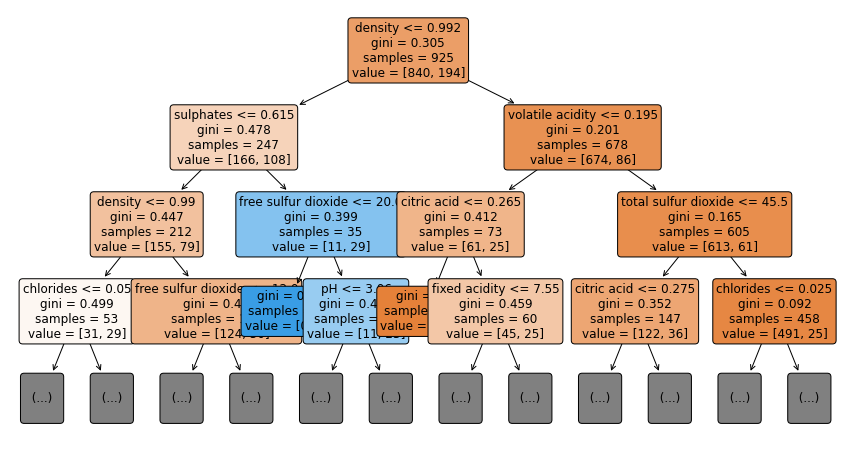

In [ ]:
visualize_tree(model, md=3, i=0, fs=(15,8))

#EDA

## Investigating attributes interactions 

In [ ]:
plot_corr_heatmap(df)

alt.LayerChart(...)

The results suggests two main correlations;<br> negative correlation between density and alcohol <br> positive correlation between total sulfur dioxide and free sulfur dioxide.

## Permutation feature importance

To better understand the contribution of each attribute we also created permutation importance table

In [ ]:
permutation_test(df)

0.8808510638297873 0.8785769528228925 0.979110251450677


Results supports the general notion of the heatmap and feature inportance of previous step. 

##SHAP

A more representative tool to demonstrate these effects is given by SHAP, which provides us with the direction each attribute is affecting; and the attribute levels accounting for the effect. e.g high levels of alcohol contributes to positive predictions of the model ("premium" wines).

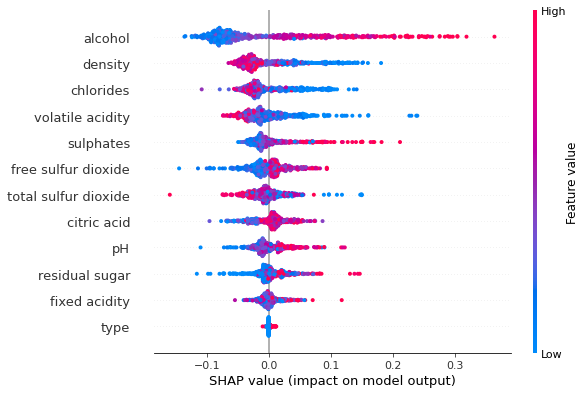

In [ ]:
## SHAP on random forest
samples = X_train.sample(500)
model = RandomForestClassifier(oob_score=True, max_samples=0.5, n_estimators=100).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(samples, check_additivity=False)
shap.summary_plot(shap_values[1], samples)

Integrating all the data retreivd from investigating the attributes we can see that: alcohol, density, acidity, chlorides and sulfur are key factors in correctly predicting the "premium" wines in our model. Our engineering will drop columns with duplicated functions (free sulfor dioxide) and low contribution (type).

# Model #3

## Enhancing the data - Removing columns

Dropping attributes; "type"



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1457
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3054
              precision    recall  f1-score   support

 not_premium       0.88      0.96      0.92      1039
     premium       0.76      0.48      0.59       254

    accuracy                           0.87      1293
   macro avg       0.82      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293




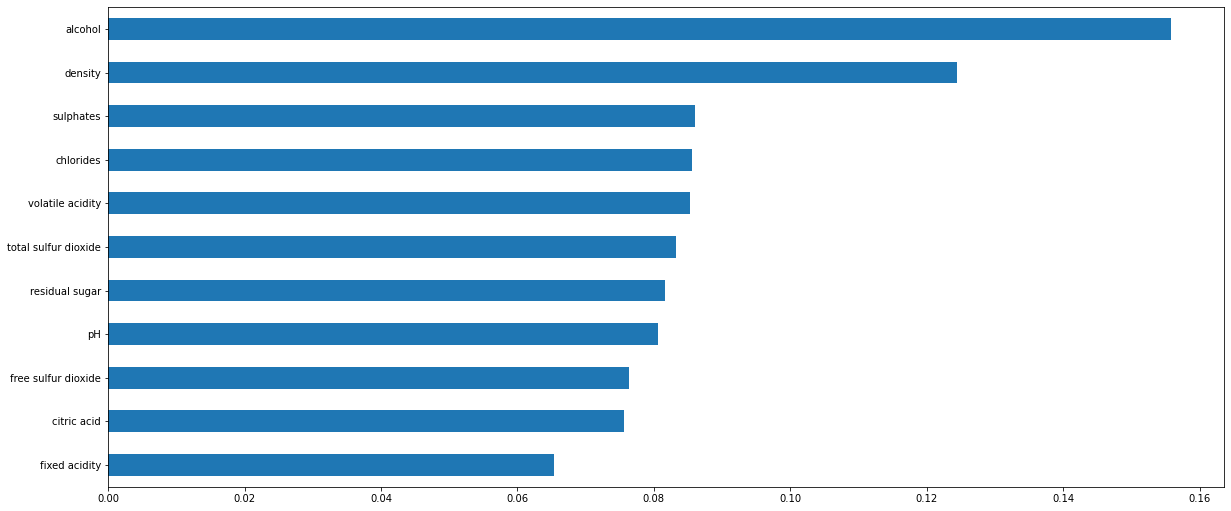

In [ ]:
test_df(df.drop(columns='type'),'quality',0.5)

Results:
<br> Recall = 0.49
<br> f1 ratio = 0.63

# Model #4

Dropping attributes; "free sulfur dioxide"



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1470
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3284
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.79      0.48      0.59       254

    accuracy                           0.87      1293
   macro avg       0.84      0.72      0.76      1293
weighted avg       0.87      0.87      0.86      1293




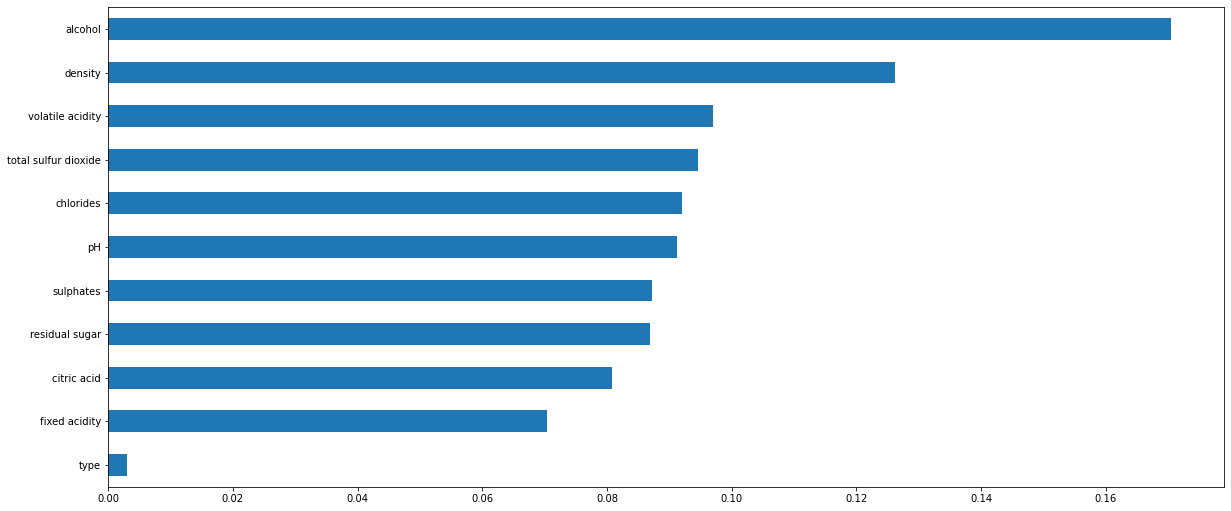

In [ ]:
test_df(df.drop(columns=['free sulfur dioxide']),'quality',0.5)

Results:
<br> Recall = 0.49
<br> f1 ratio = 0.64

# Model #5

## Cardinality

We screened for attribute that has very high number of entries (close to the total entries number).

In [ ]:
for i in df.drop(columns='quality').columns:
    print (i, df[i].nunique())

type 2
fixed acidity 106
volatile acidity 187
citric acid 89
residual sugar 315
chlorides 214
free sulfur dioxide 135
total sulfur dioxide 276
density 996
pH 108
sulphates 111
alcohol 111


In [ ]:
df_eda=df.copy()
df_eda['density_range']=pd.qcut(df_eda['density'],100,labels=range(100))
df_eda.drop(columns='density',inplace=True)

"density" column was found to have high number of entries and thus was re-configured to have only 100 sub-sections

Fixed "density" cardinality range


TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1449
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3497
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.92      1039
     premium       0.78      0.50      0.61       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.77      1293
weighted avg       0.87      0.87      0.86      1293




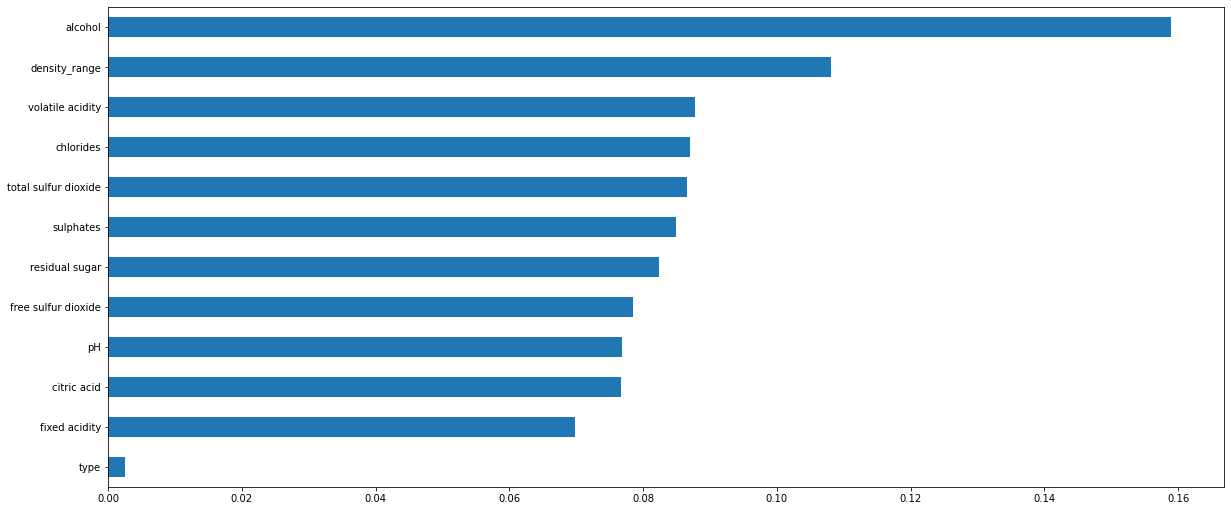

In [ ]:
test_df(df_eda,'quality',0.5)

Results:
<br> Recall = 0.50
<br> f1 ratio = 0.65

# Model #6

## Attributes interactions metrices

In order to get a broader view of the interactions of the different attributes, we created a metrices of diviations of all the attributes followed by a run of the model on each.
<br>**NOTE- this run is time consuming and produces many figures.**

volatile acidity/fixed acidity

TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1449
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3281
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


citric acid/fixed acidity

TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1456
              precisi

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1428
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3222
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.82      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


residual sugar/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3063
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.76      0.51      0.61       254

    accuracy                           0.87      1293
   macro avg       0.83      0.74      0.77      1293
weighted avg       0.87      0.87      0.86      1293


chlorides/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1445
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3494
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.78      0.52      0.62       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.77      1293
weighted avg       0.87      0.88      0.87      1293


free sulfur dioxide/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3288
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.78      0.51      0.62       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.77      1293
weighted avg       0.87      0.88      0.86      1293


total sulfur dioxide/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1446
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3250
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.77      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


density/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3232
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.52      0.63       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


pH/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1441
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3268
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.50      0.61       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


sulphates/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1456
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3244
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.50      0.62       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.87      1293


alcohol/citric acid


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1436
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3263
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.93      1039
     premium       0.80      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


fixed acidity/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1449
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3240
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.92      1039
     premium       0.78      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


volatile acidity/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1446
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3023
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.77      0.46      0.58       254

    accuracy                           0.87      1293
   macro avg       0.82      0.71      0.75      1293
weighted avg       0.86      0.87      0.85      1293


citric acid/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3498
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.51      0.62       254

    accuracy                           0.88      1293
   macro avg       0.85      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


chlorides/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1453
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3022
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.50      0.61       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


free sulfur dioxide/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1444
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3264
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


total sulfur dioxide/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.2984
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


density/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1458
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3267
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.52      0.63       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


pH/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1446
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3239
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.79      0.47      0.59       254

    accuracy                           0.87      1293
   macro avg       0.84      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


sulphates/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1449
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3464
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.78      0.50      0.61       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.87      0.86      1293


alcohol/residual sugar


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3504
              precision    recall  f1-score   support

 not_premium       0.88      0.96      0.92      1039
     premium       0.77      0.48      0.59       254

    accuracy                           0.87      1293
   macro avg       0.82      0.72      0.75      1293
weighted avg       0.86      0.87      0.86      1293


fixed acidity/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1447
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3259
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.51      0.63       254

    accuracy                           0.88      1293
   macro avg       0.85      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


volatile acidity/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3019
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.50      0.62       254

    accuracy                           0.88      1293
   macro avg       0.85      0.74      0.77      1293
weighted avg       0.87      0.88      0.87      1293


citric acid/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1445
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3279
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.77      0.47      0.59       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.75      1293
weighted avg       0.86      0.87      0.86      1293


residual sugar/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3259
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.77      0.52      0.62       254

    accuracy                           0.87      1293
   macro avg       0.83      0.74      0.77      1293
weighted avg       0.87      0.87      0.87      1293


free sulfur dioxide/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1440
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3017
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.82      0.51      0.63       254

    accuracy                           0.88      1293
   macro avg       0.86      0.74      0.78      1293
weighted avg       0.88      0.88      0.87      1293


total sulfur dioxide/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1446
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3273
              precision    recall  f1-score   support

 not_premium       0.88      0.96      0.92      1039
     premium       0.76      0.48      0.59       254

    accuracy                           0.87      1293
   macro avg       0.82      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


density/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3544
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.48      0.59       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


pH/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3268
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.47      0.59       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


sulphates/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1438
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3205
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


alcohol/chlorides


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1441
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3250
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.47      0.59       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


fixed acidity/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1439
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3023
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


volatile acidity/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1445
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3235
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.76      0.50      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


citric acid/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1455
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3241
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.92      1039
     premium       0.78      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


residual sugar/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.96      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3259
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.83      0.51      0.63       254

    accuracy                           0.88      1293
   macro avg       0.86      0.74      0.78      1293
weighted avg       0.88      0.88      0.87      1293


chlorides/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1436
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3254
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.75      0.49      0.59       254

    accuracy                           0.87      1293
   macro avg       0.82      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


total sulfur dioxide/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1445
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3275
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.82      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


density/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1450
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3264
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.77      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


pH/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3254
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.92      1039
     premium       0.78      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


sulphates/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1444
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3265
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.50      0.61       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


alcohol/free sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1455
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3063
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.50      0.61       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.87      1293


fixed acidity/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1454
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       0.99      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3244
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.77      0.47      0.58       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.75      1293
weighted avg       0.86      0.87      0.86      1293


volatile acidity/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3270
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.50      0.61       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


citric acid/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1456
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3467
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


residual sugar/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3251
              precision    recall  f1-score   support

 not_premium       0.88      0.96      0.92      1039
     premium       0.76      0.48      0.59       254

    accuracy                           0.87      1293
   macro avg       0.82      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


chlorides/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1433
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.96      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3535
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.50      0.62       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.77      1293
weighted avg       0.87      0.88      0.87      1293


free sulfur dioxide/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3258
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


density/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3031
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.92      1039
     premium       0.78      0.50      0.61       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.77      1293
weighted avg       0.87      0.87      0.86      1293


pH/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1450
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3265
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.51      0.62       254

    accuracy                           0.88      1293
   macro avg       0.85      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


sulphates/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1453
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3242
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.77      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


alcohol/total sulfur dioxide


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1446
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3223
              precision    recall  f1-score   support

 not_premium       0.89      0.98      0.93      1039
     premium       0.84      0.51      0.63       254

    accuracy                           0.88      1293
   macro avg       0.86      0.74      0.78      1293
weighted avg       0.88      0.88      0.87      1293


fixed acidity/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3266
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.93      1039
     premium       0.81      0.48      0.60       254

    accuracy                           0.88      1293
   macro avg       0.85      0.72      0.76      1293
weighted avg       0.87      0.88      0.86      1293


volatile acidity/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3255
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.92      1039
     premium       0.78      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


citric acid/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1450
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3239
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.52      0.63       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


residual sugar/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1456
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3247
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.50      0.62       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.77      1293
weighted avg       0.87      0.88      0.87      1293


chlorides/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1444
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3247
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.46      0.58       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.75      1293
weighted avg       0.86      0.87      0.86      1293


free sulfur dioxide/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1454
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3037
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.50      0.62       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.87      1293


total sulfur dioxide/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1445
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3000
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.82      0.50      0.62       254

    accuracy                           0.88      1293
   macro avg       0.85      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


pH/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1455
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3466
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.76      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.82      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


sulphates/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1440
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3267
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.50      0.61       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.77      1293
weighted avg       0.87      0.88      0.86      1293


alcohol/density


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1455
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3243
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.79      0.48      0.59       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.76      1293
weighted avg       0.86      0.87      0.86      1293


fixed acidity/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3249
              precision    recall  f1-score   support

 not_premium       0.88      0.98      0.93      1039
     premium       0.84      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.86      0.73      0.77      1293
weighted avg       0.88      0.88      0.87      1293


volatile acidity/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1437
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.2968
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.53      0.64       254

    accuracy                           0.88      1293
   macro avg       0.85      0.75      0.78      1293
weighted avg       0.87      0.88      0.87      1293


citric acid/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.92      0.96      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.96      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3244
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.83      0.51      0.63       254

    accuracy                           0.88      1293
   macro avg       0.86      0.74      0.78      1293
weighted avg       0.88      0.88      0.87      1293




More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


residual sugar/pH

TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1444
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3247
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.76      0.51      0.61       254

    accuracy                           0.87      1293
   macro avg       0.83      0.74      0.77      1293
weighted avg       0.87      0.87      0.86      1293


chlorides/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1440
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3249
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.77      0.46      0.58       254

    accuracy                           0.87      1293
   macro avg       0.82      0.71      0.75      1293
weighted avg       0.86      0.87      0.85      1293


free sulfur dioxide/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1442
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.94      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3249
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.50      0.61       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.87      0.86      1293


total sulfur dioxide/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1458
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3284
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.46      0.58       254

    accuracy                           0.87      1293
   macro avg       0.83      0.72      0.75      1293
weighted avg       0.86      0.87      0.86      1293


density/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3306
              precision    recall  f1-score   support

 not_premium       0.88      0.96      0.92      1039
     premium       0.75      0.48      0.58       254

    accuracy                           0.87      1293
   macro avg       0.82      0.72      0.75      1293
weighted avg       0.86      0.87      0.85      1293


sulphates/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3269
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.92      1039
     premium       0.78      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


alcohol/pH


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1453
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3039
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.77      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


fixed acidity/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1440
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3224
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.77      0.49      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


volatile acidity/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1451
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3476
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.51      0.63       254

    accuracy                           0.88      1293
   macro avg       0.85      0.74      0.78      1293
weighted avg       0.87      0.88      0.87      1293


citric acid/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1439
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3470
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.76      0.51      0.61       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.77      1293
weighted avg       0.86      0.87      0.86      1293


residual sugar/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1452
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3285
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.93      1039
     premium       0.81      0.48      0.60       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


chlorides/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1449
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3238
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.93      1039
     premium       0.81      0.48      0.60       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.76      1293
weighted avg       0.87      0.88      0.86      1293


free sulfur dioxide/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1451
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3053
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


total sulfur dioxide/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1444
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3244
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.51      0.62       254

    accuracy                           0.88      1293
   macro avg       0.84      0.74      0.77      1293
weighted avg       0.87      0.88      0.87      1293


density/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1451
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3239
              precision    recall  f1-score   support

 not_premium       0.89      0.98      0.93      1039
     premium       0.85      0.50      0.63       254

    accuracy                           0.88      1293
   macro avg       0.87      0.74      0.78      1293
weighted avg       0.88      0.88      0.87      1293


pH/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1449
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3028
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.48      0.60       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


alcohol/sulphates


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1449
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3269
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.48      0.60       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


fixed acidity/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1456
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3021
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.80      0.50      0.62       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.87      1293


volatile acidity/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1452
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       0.99      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3264
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.93      1039
     premium       0.80      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


citric acid/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1454
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3015
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


residual sugar/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       0.99      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3253
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.78      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.76      1293
weighted avg       0.86      0.87      0.86      1293


chlorides/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1444
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3251
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.80      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.72      0.76      1293
weighted avg       0.87      0.87      0.86      1293


free sulfur dioxide/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1451
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       1.00      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3497
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.92      1039
     premium       0.79      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


total sulfur dioxide/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1441
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3065
              precision    recall  f1-score   support

 not_premium       0.88      0.97      0.93      1039
     premium       0.80      0.48      0.60       254

    accuracy                           0.87      1293
   macro avg       0.84      0.73      0.76      1293
weighted avg       0.87      0.87      0.86      1293


density/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1439
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3012
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.79      0.50      0.61       254

    accuracy                           0.88      1293
   macro avg       0.84      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293


pH/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1448
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.91      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3015
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.82      0.51      0.63       254

    accuracy                           0.88      1293
   macro avg       0.86      0.74      0.78      1293
weighted avg       0.88      0.88      0.87      1293


sulphates/alcohol


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1443
              precision    recall  f1-score   support

 not_premium       0.98      1.00      0.99      4153
     premium       1.00      0.90      0.95      1017

    accuracy                           0.98      5170
   macro avg       0.99      0.95      0.97      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3292
              precision    recall  f1-score   support

 not_premium       0.89      0.96      0.92      1039
     premium       0.77      0.50      0.61       254

    accuracy                           0.87      1293
   macro avg       0.83      0.73      0.77      1293
weighted avg       0.87      0.87      0.86      1293




More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


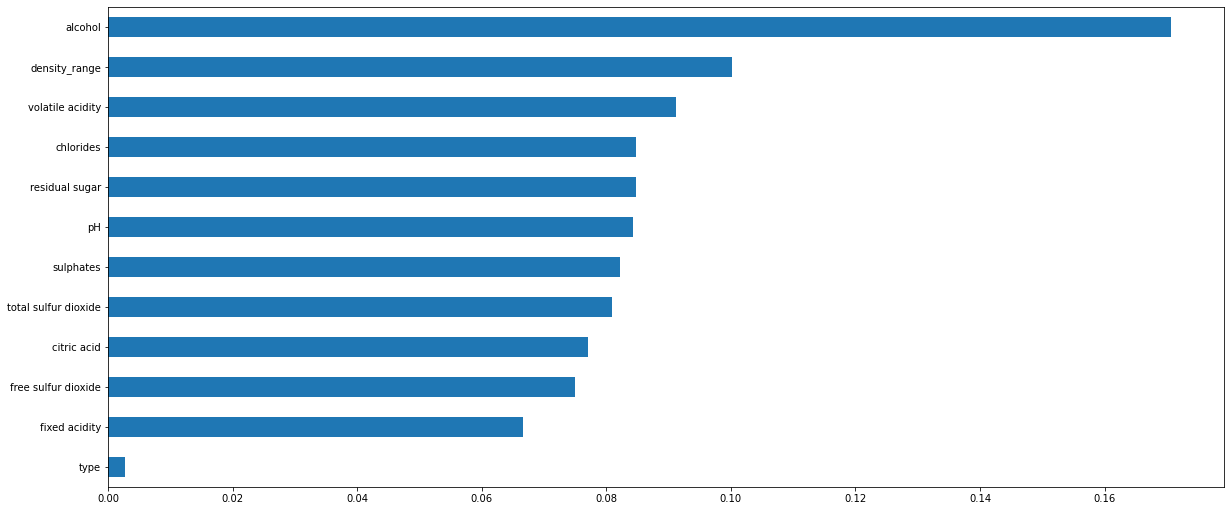

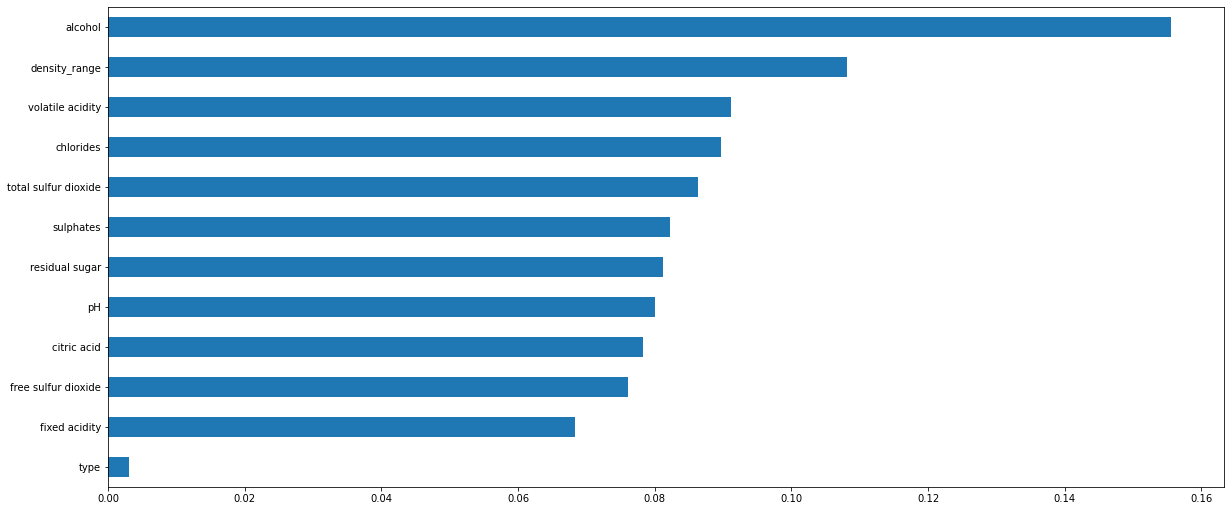

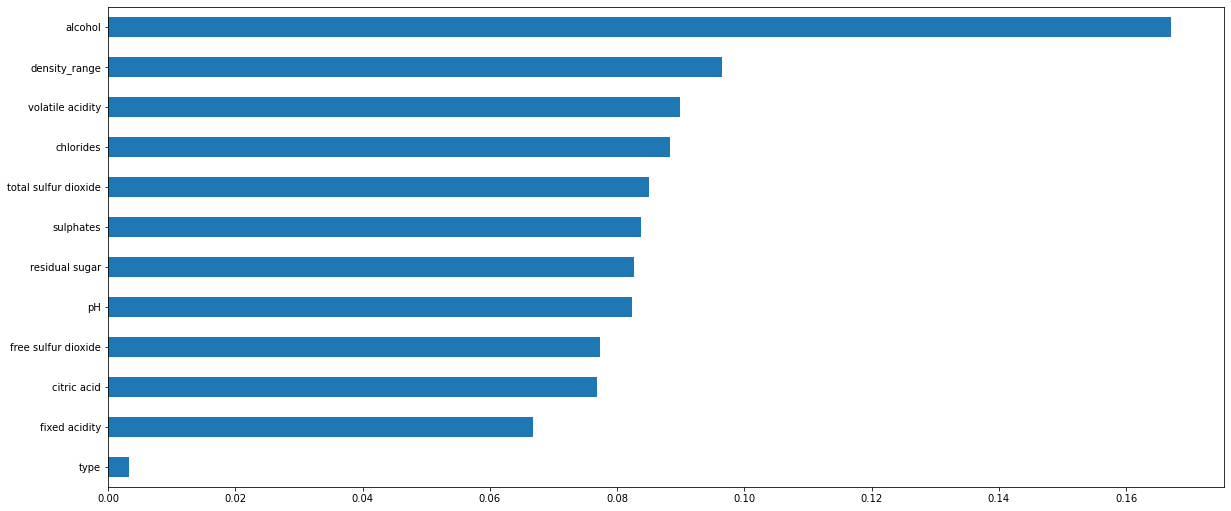

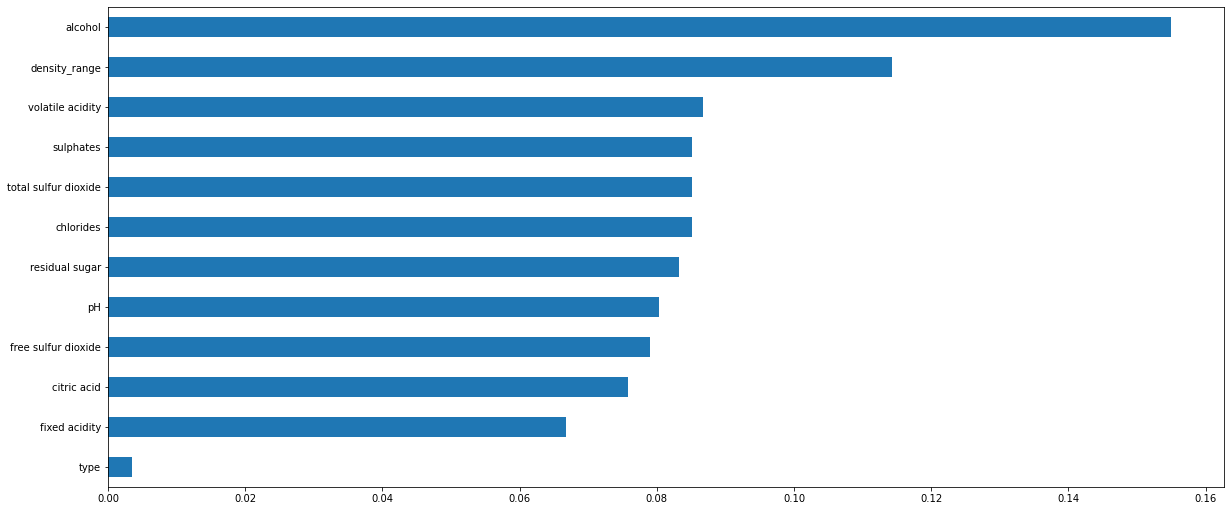

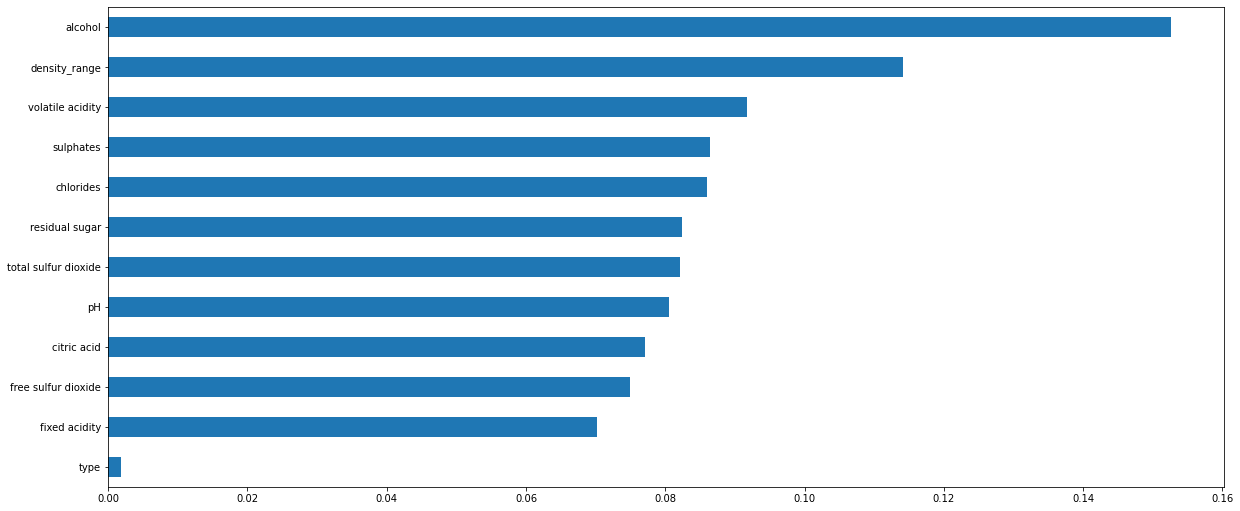

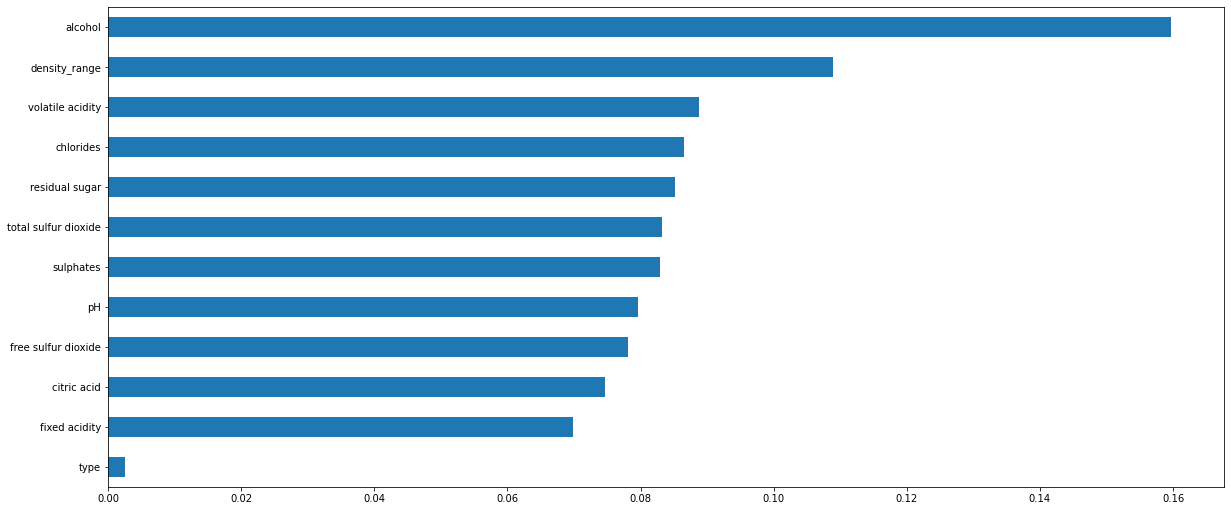

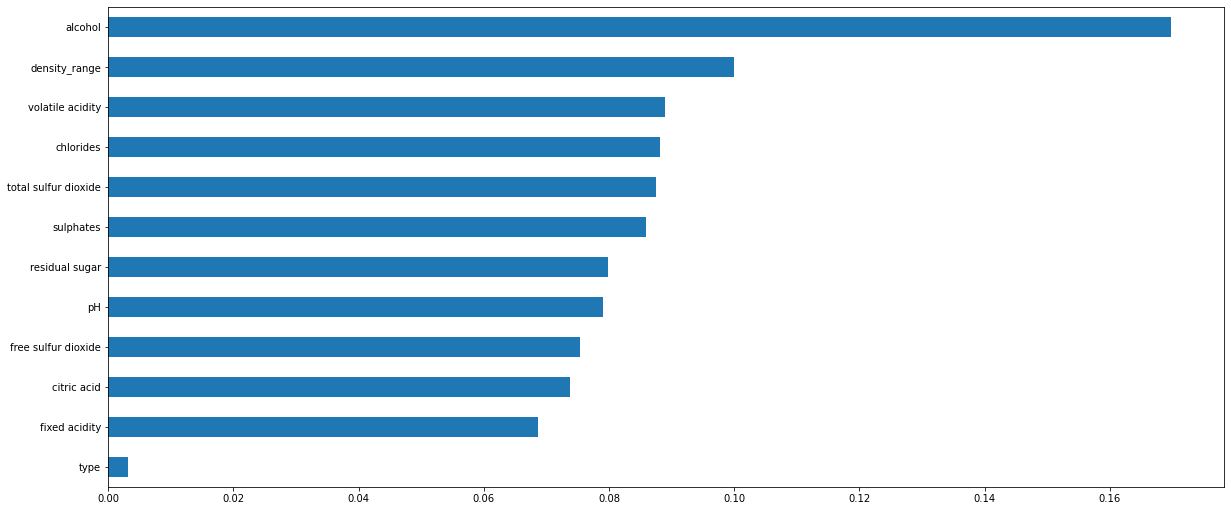

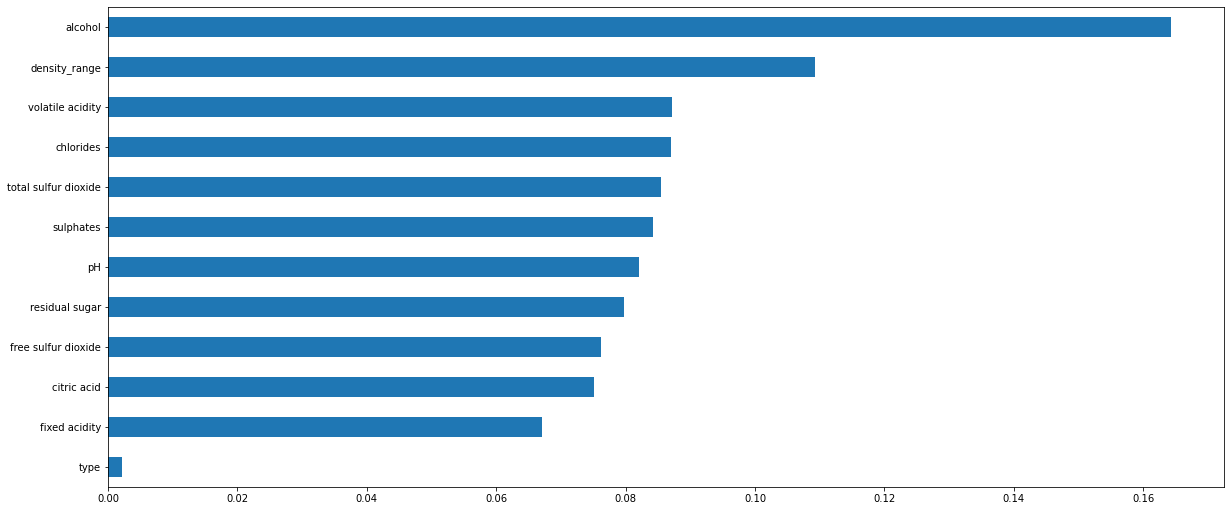

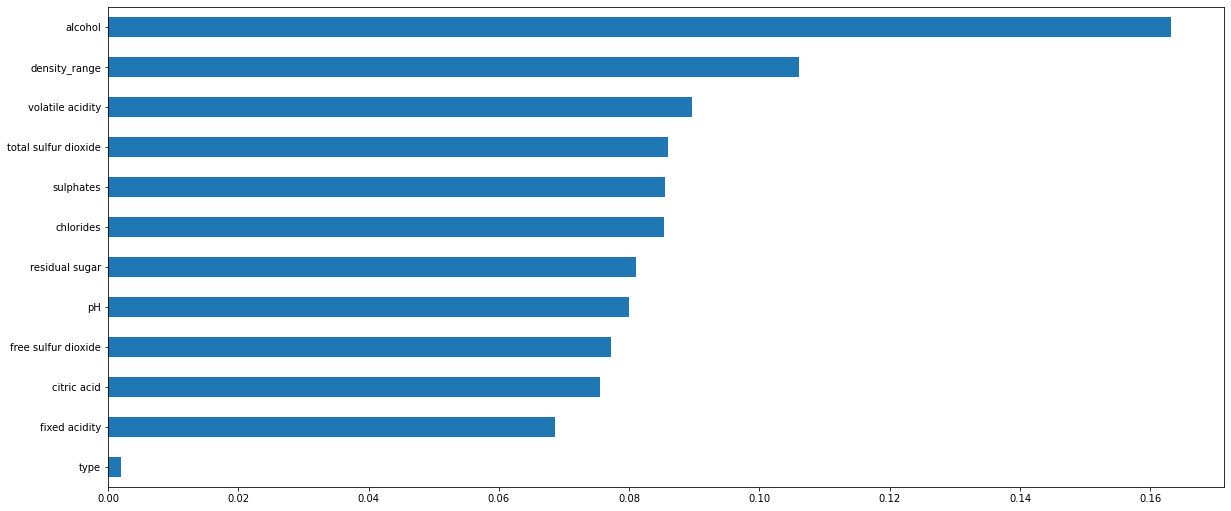

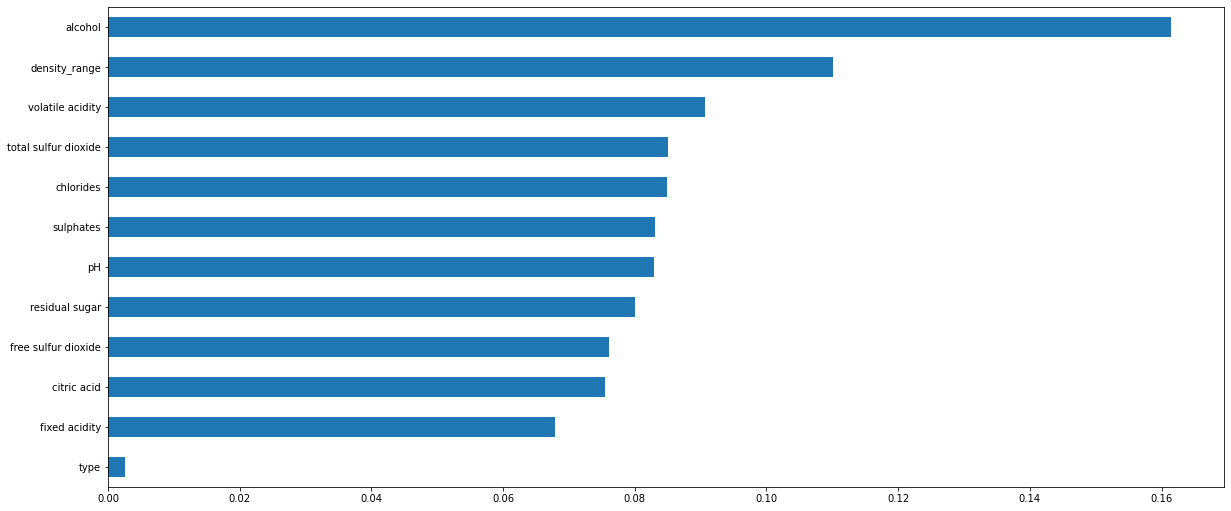

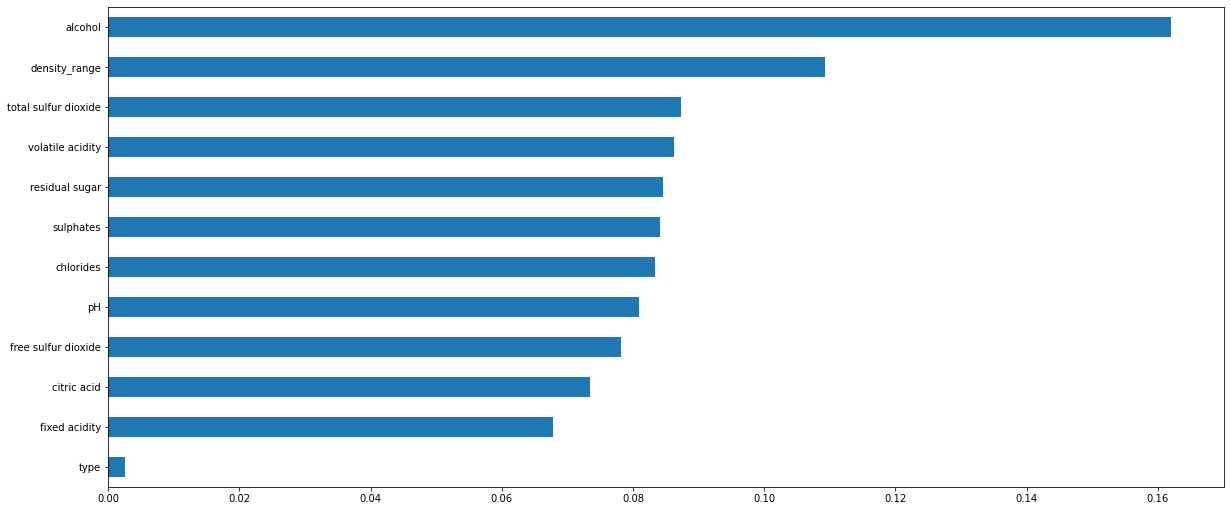

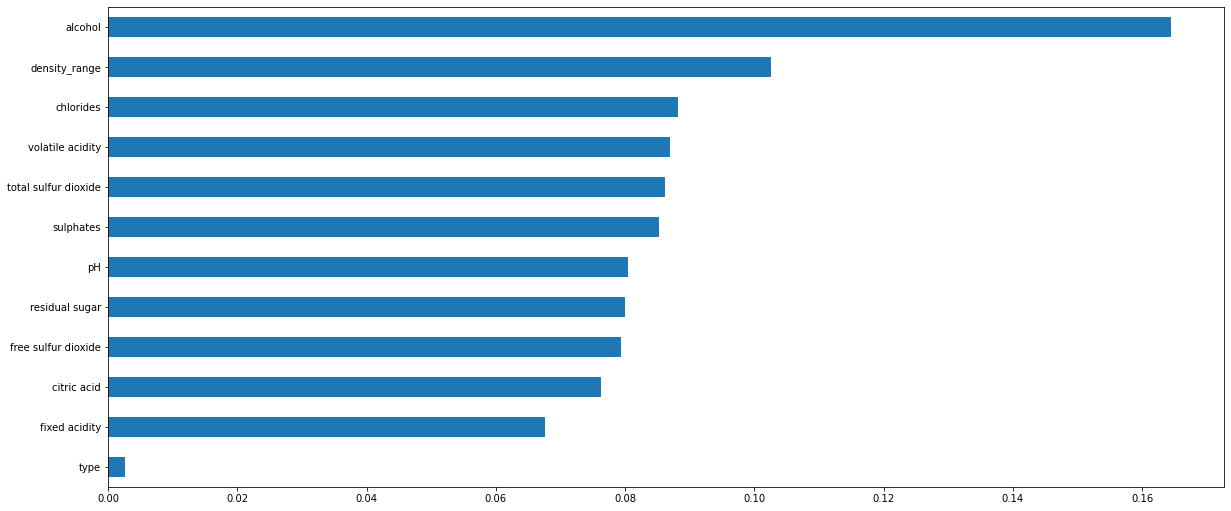

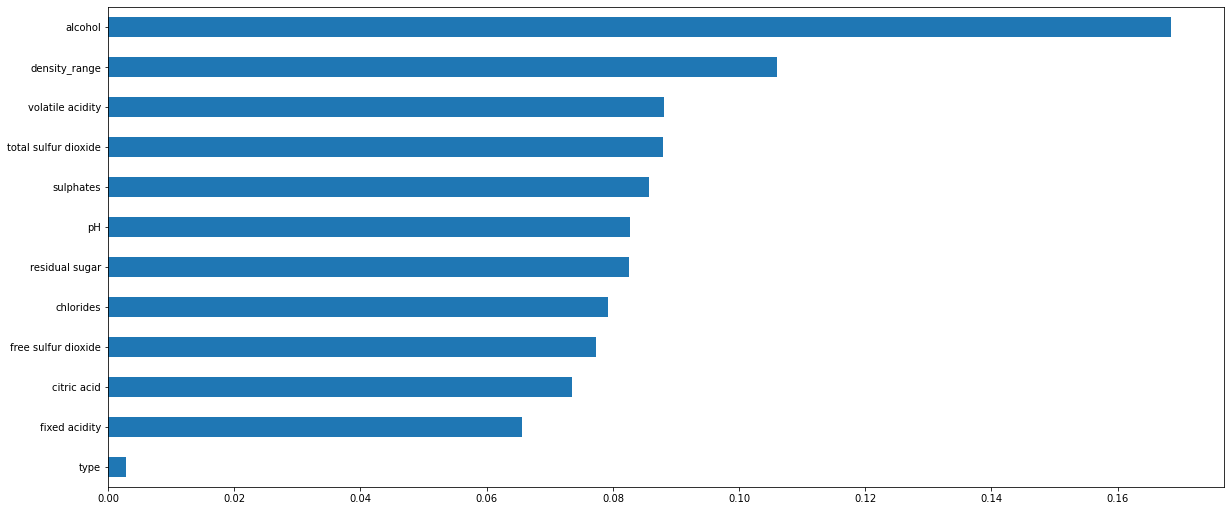

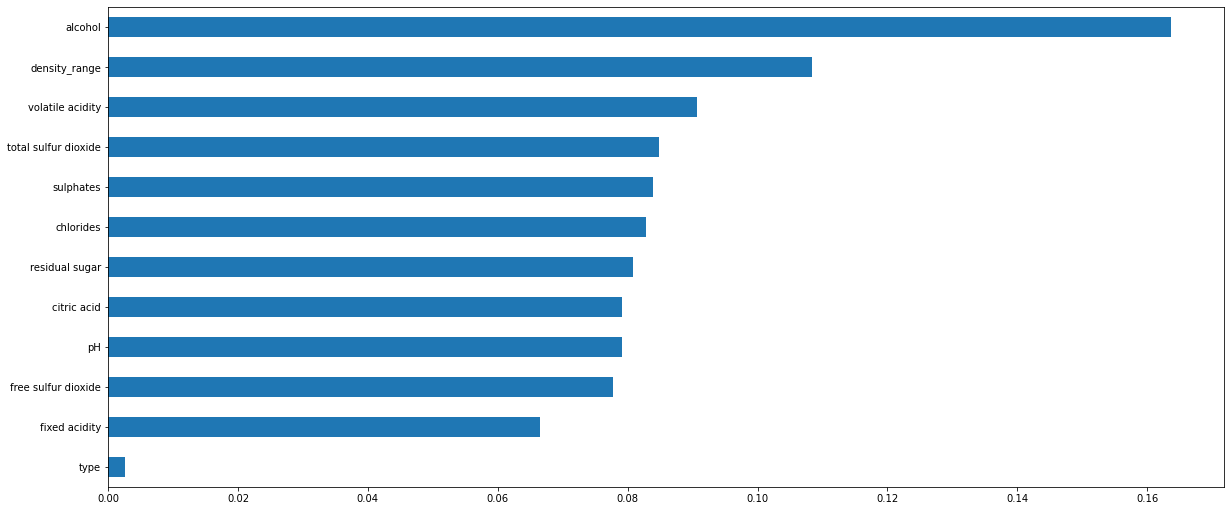

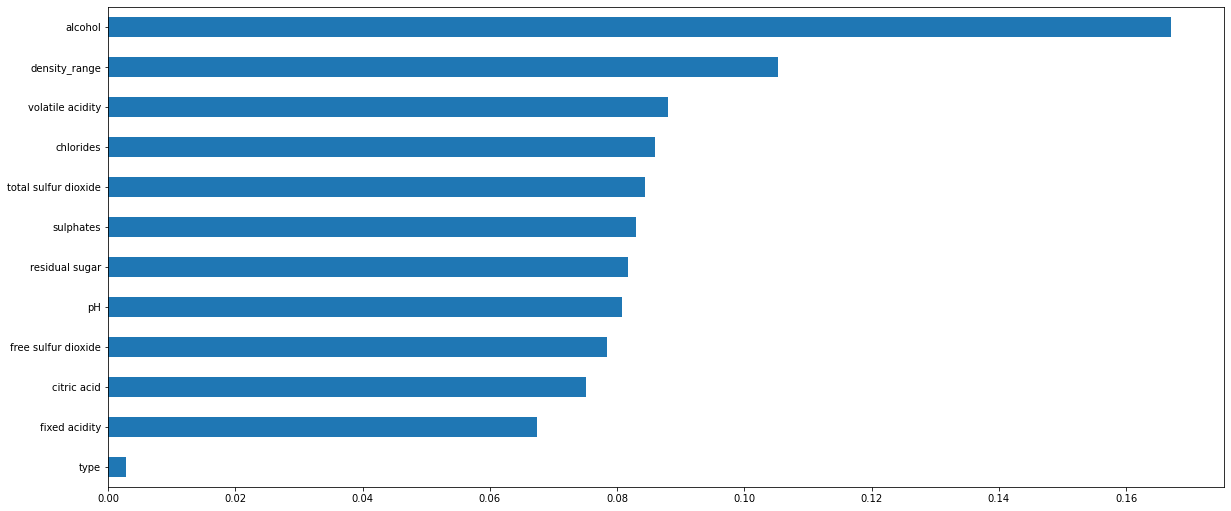

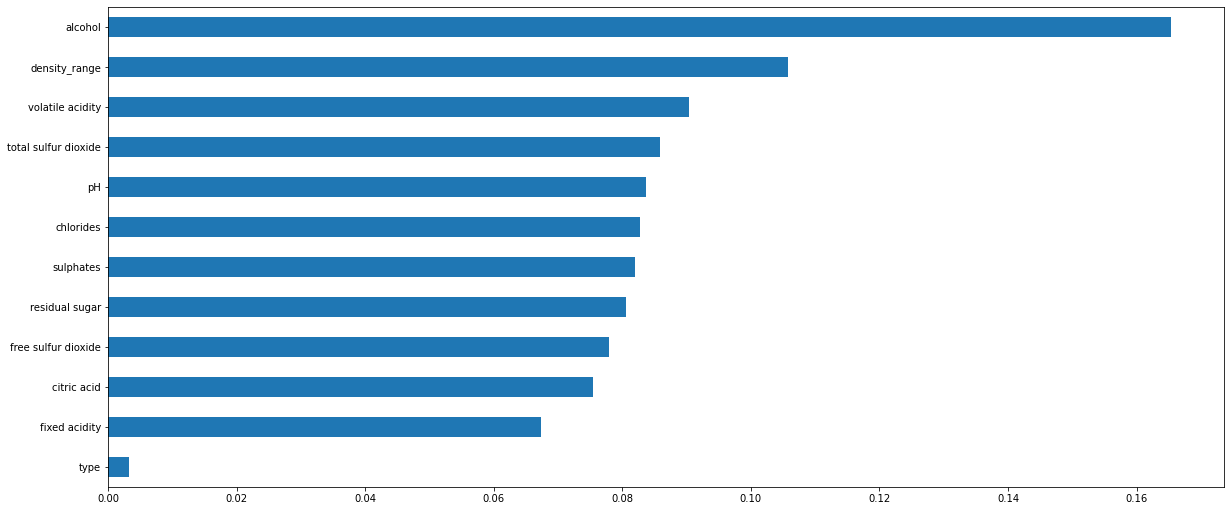

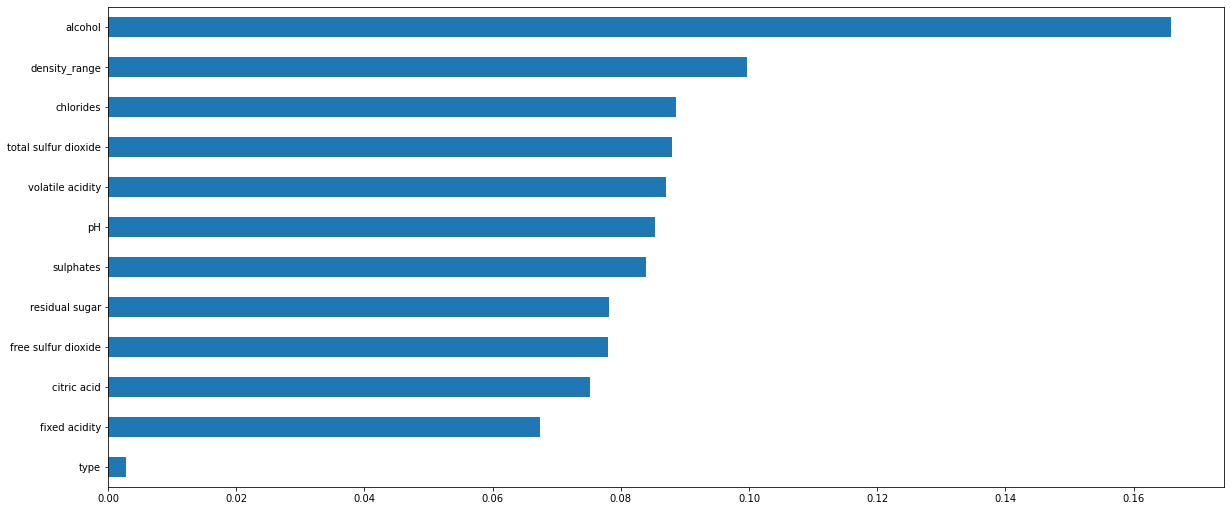

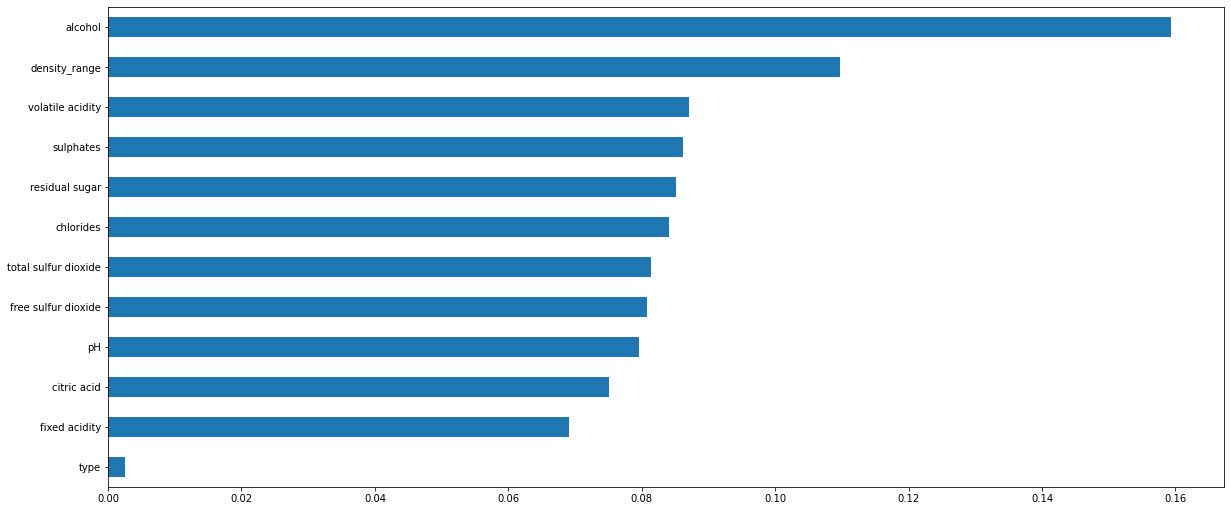

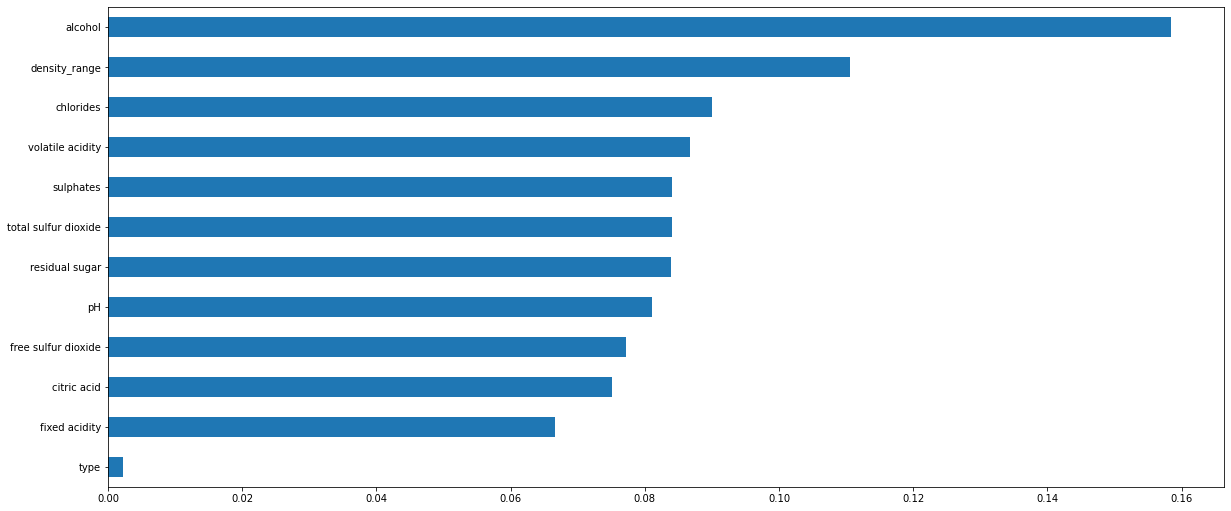

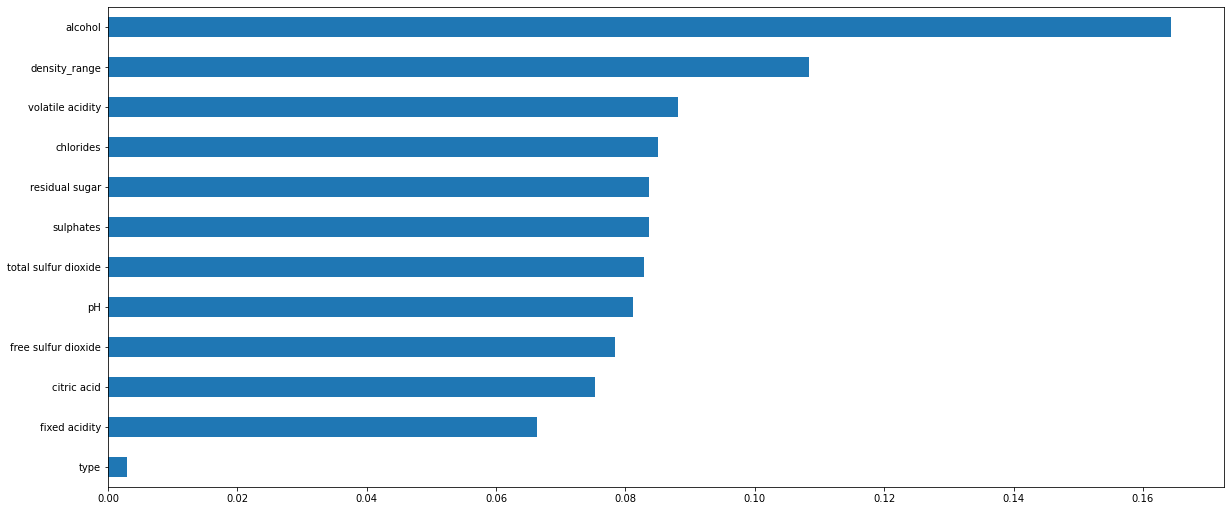

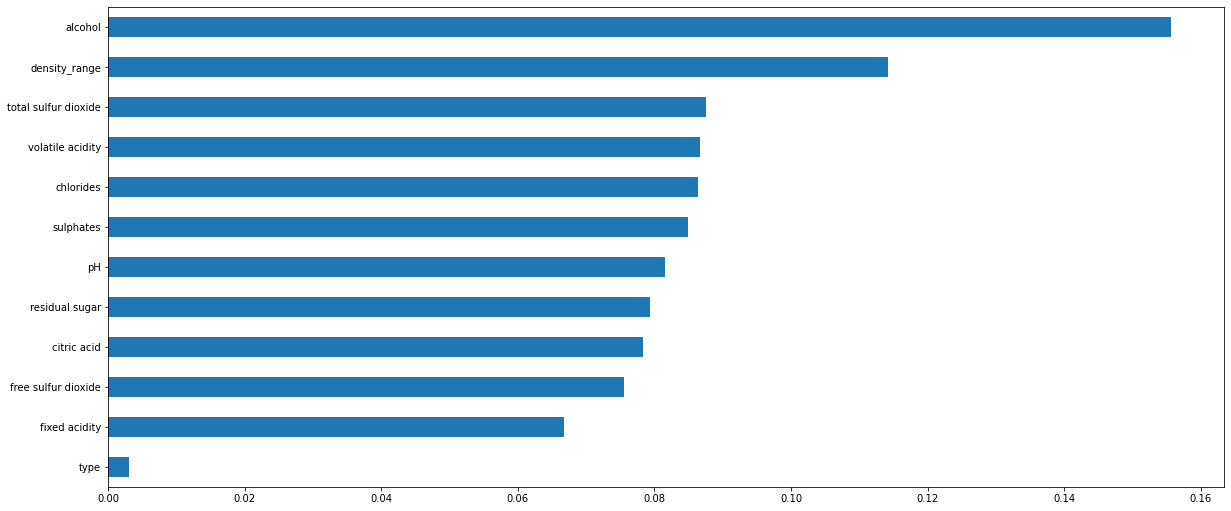

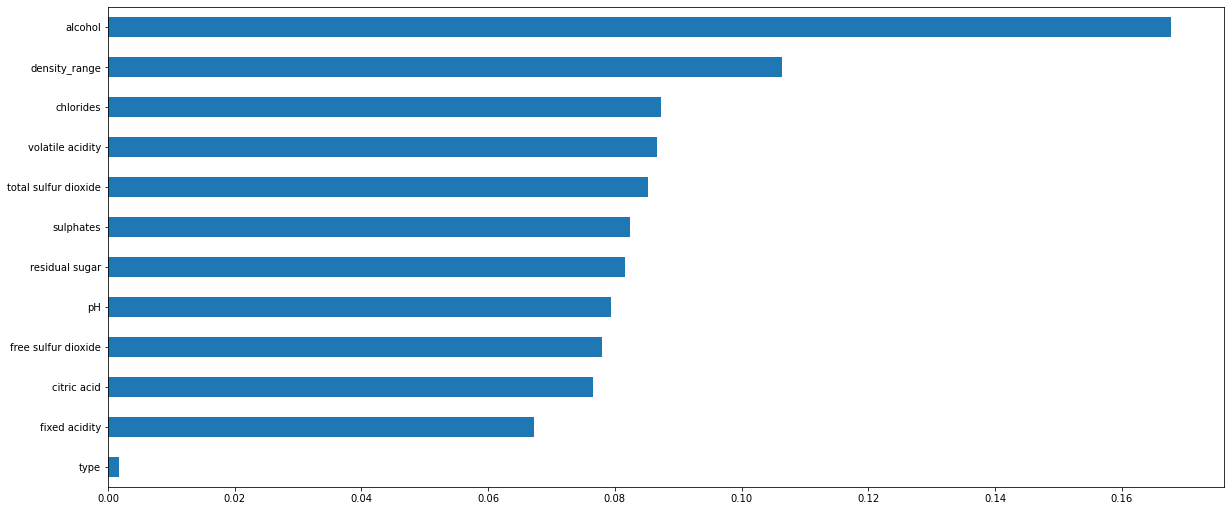

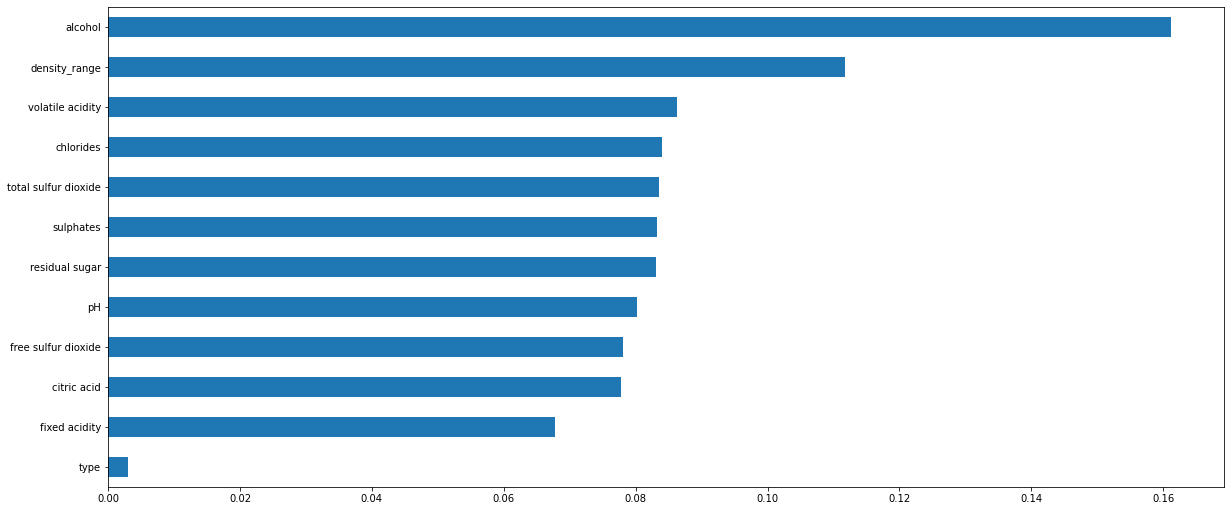

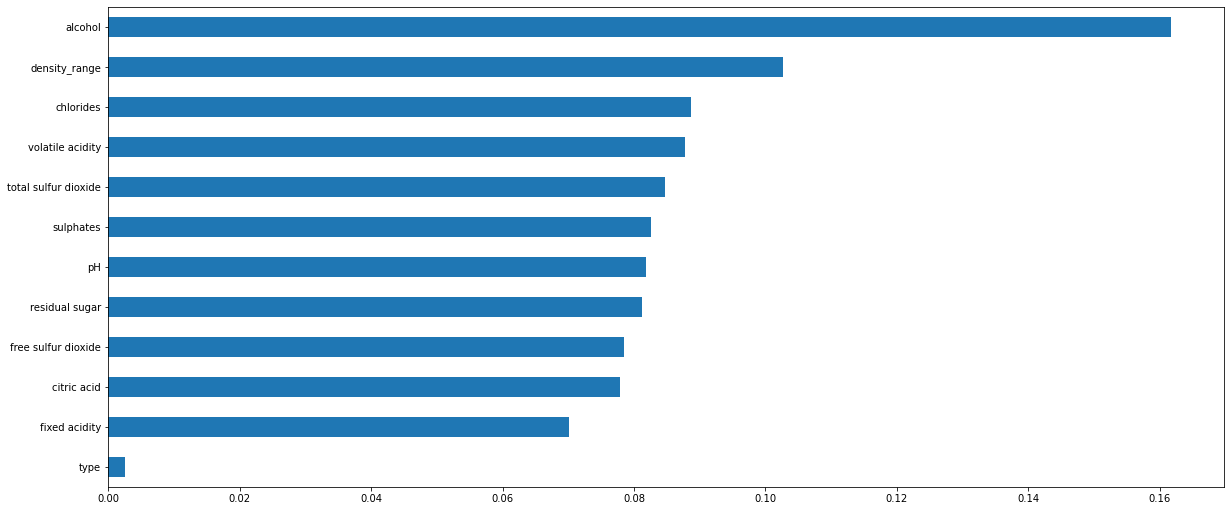

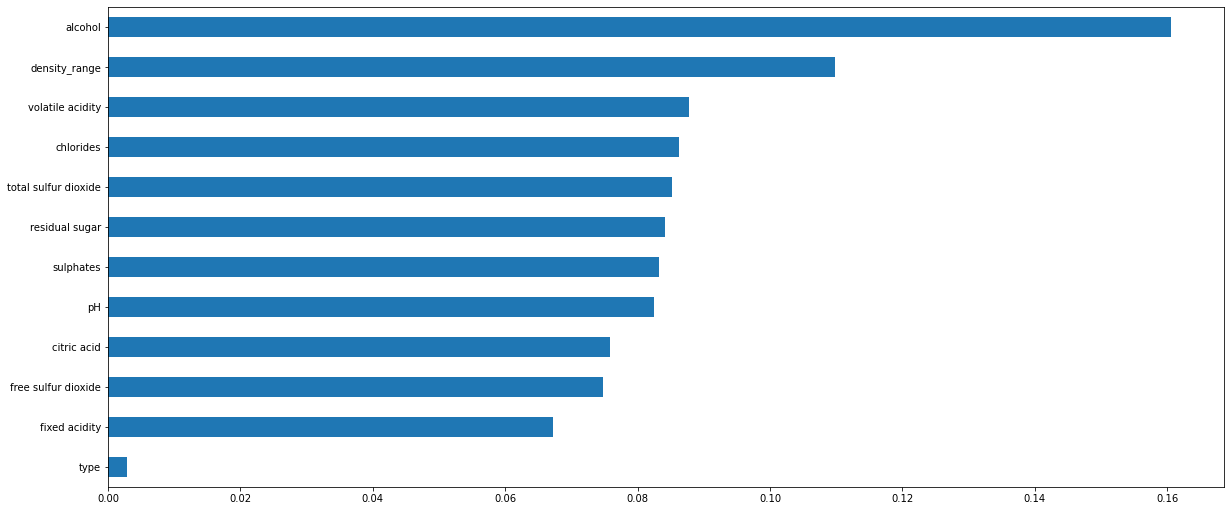

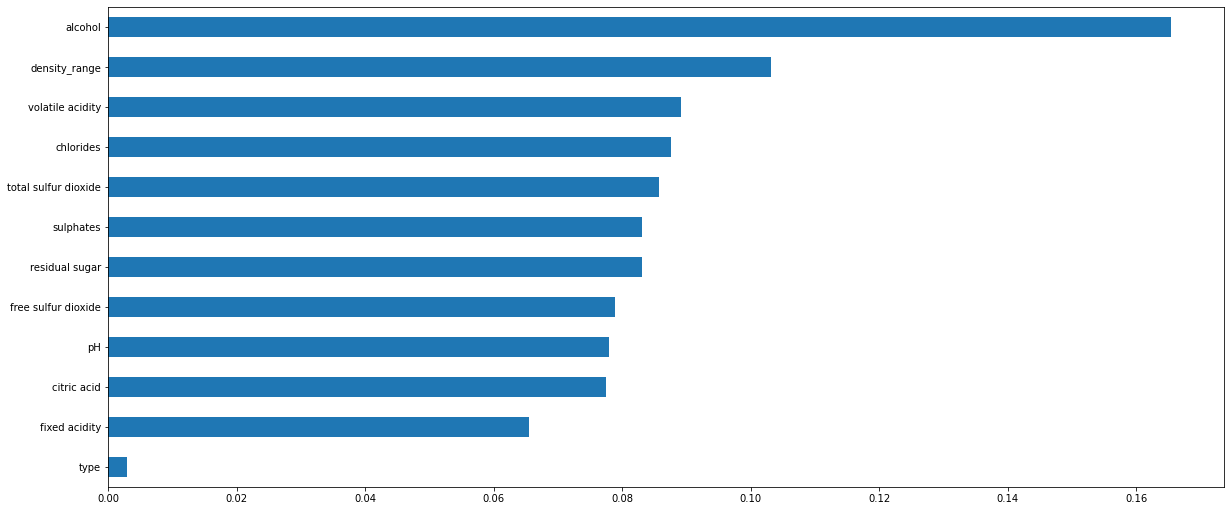

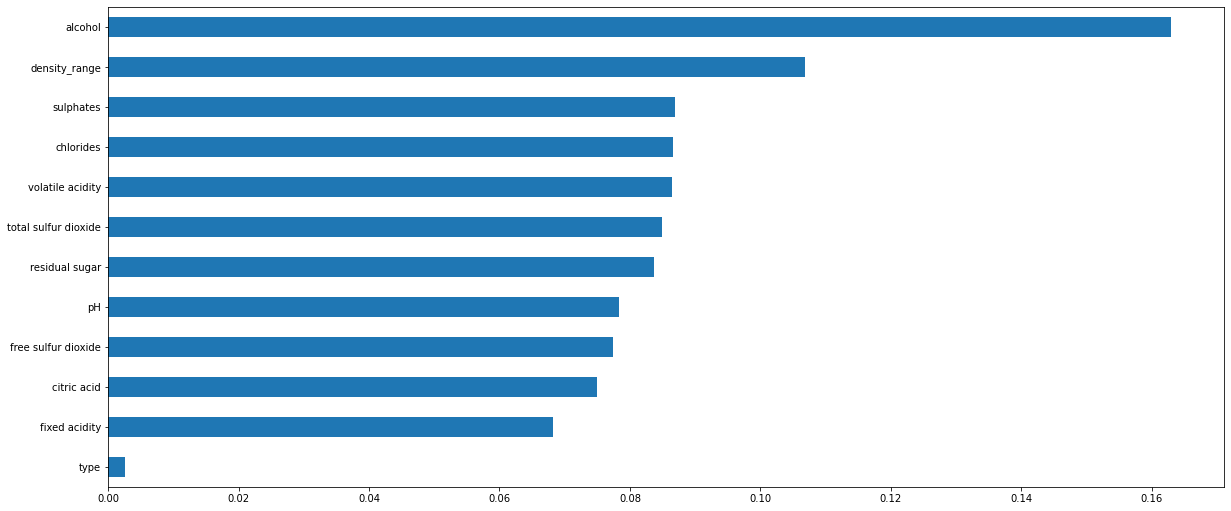

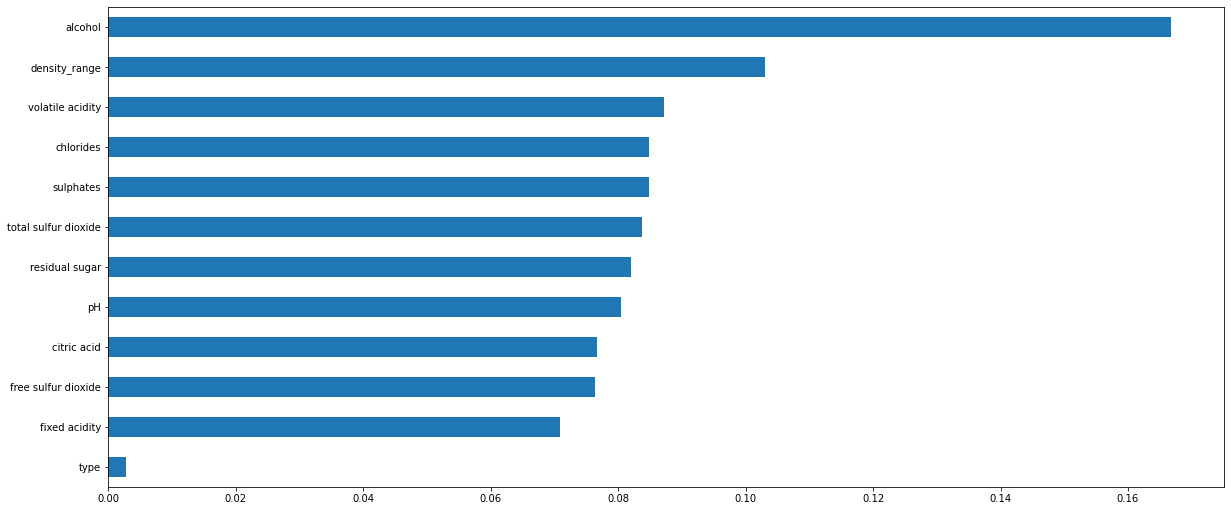

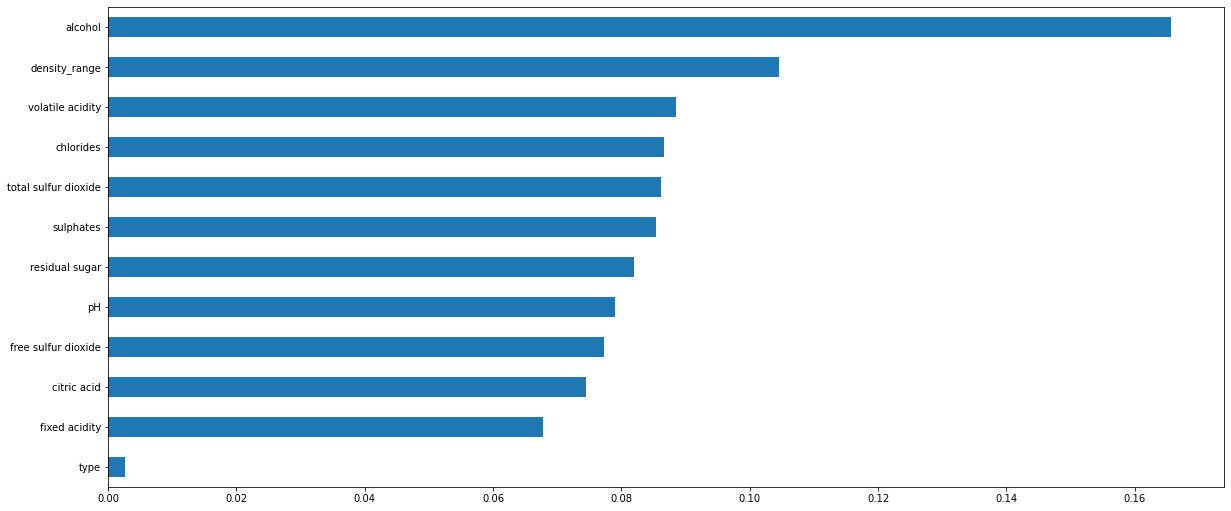

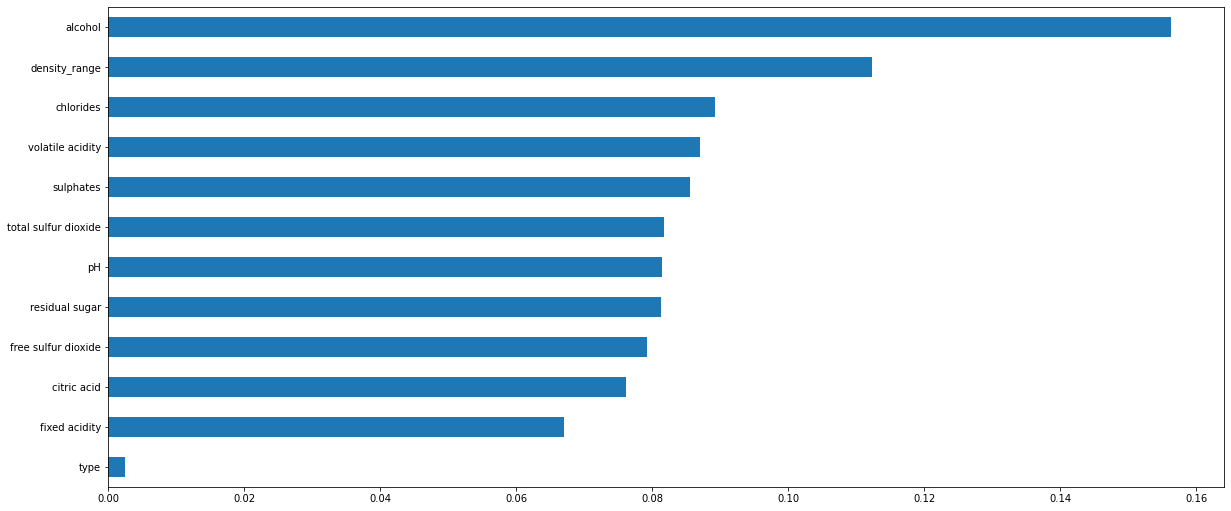

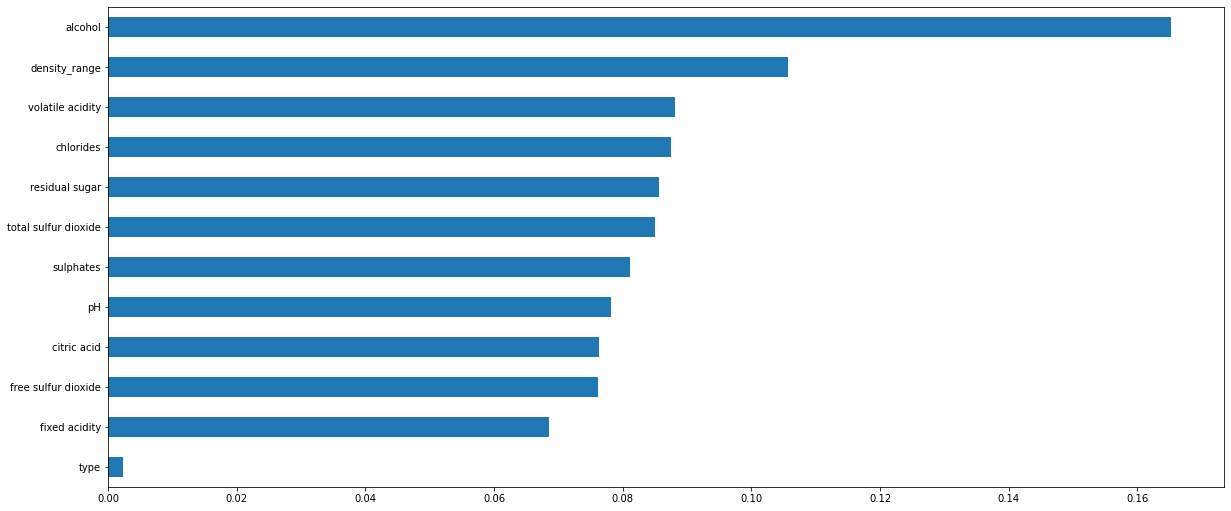

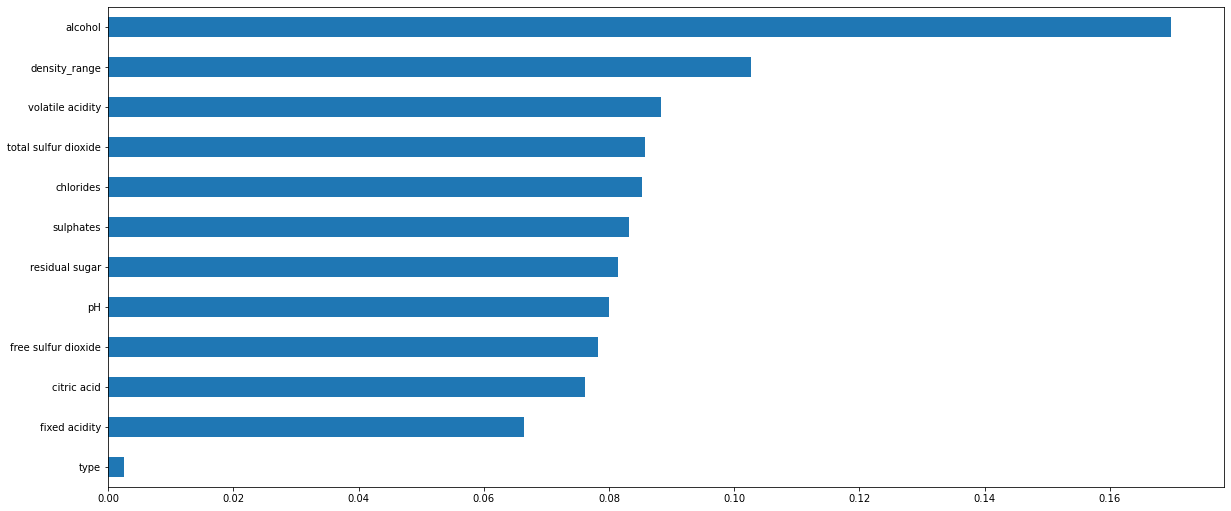

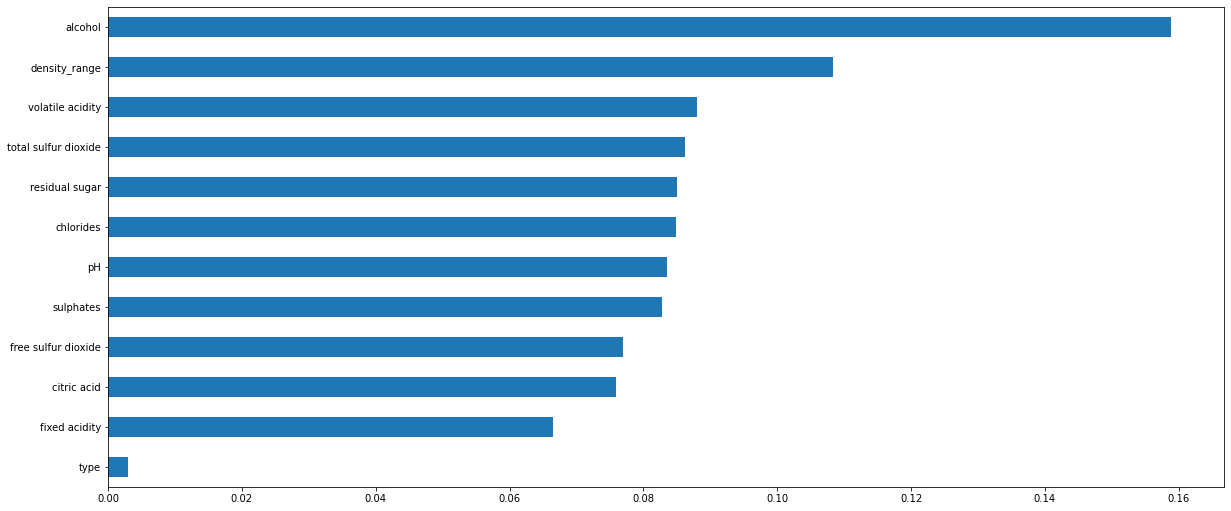

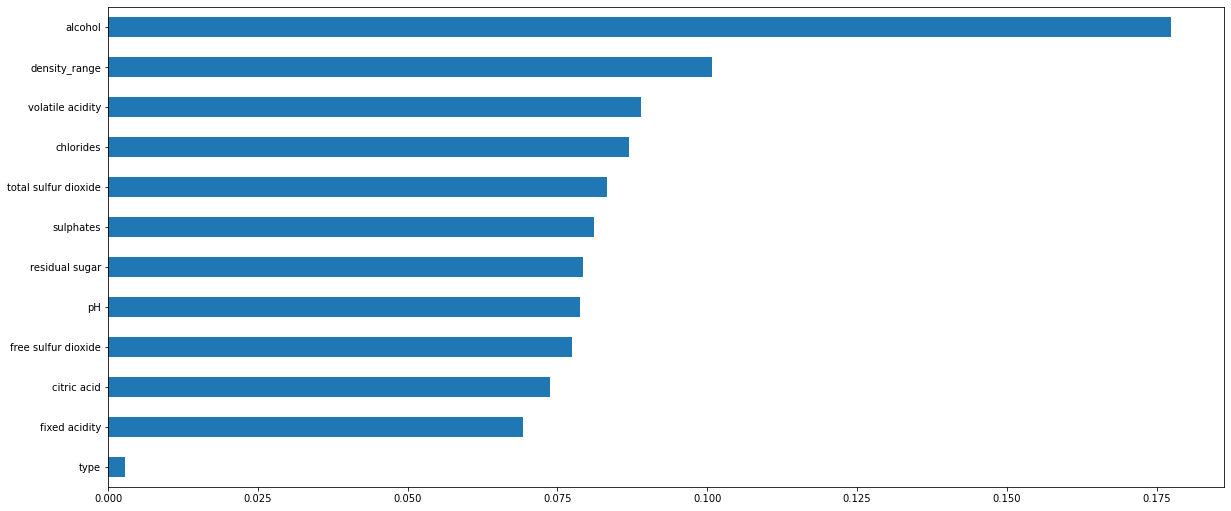

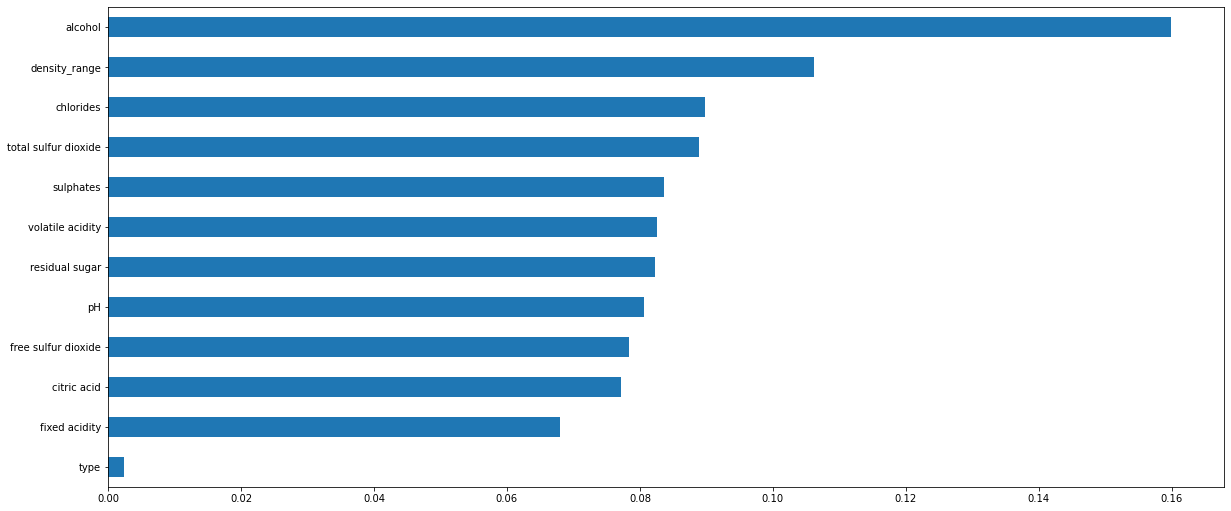

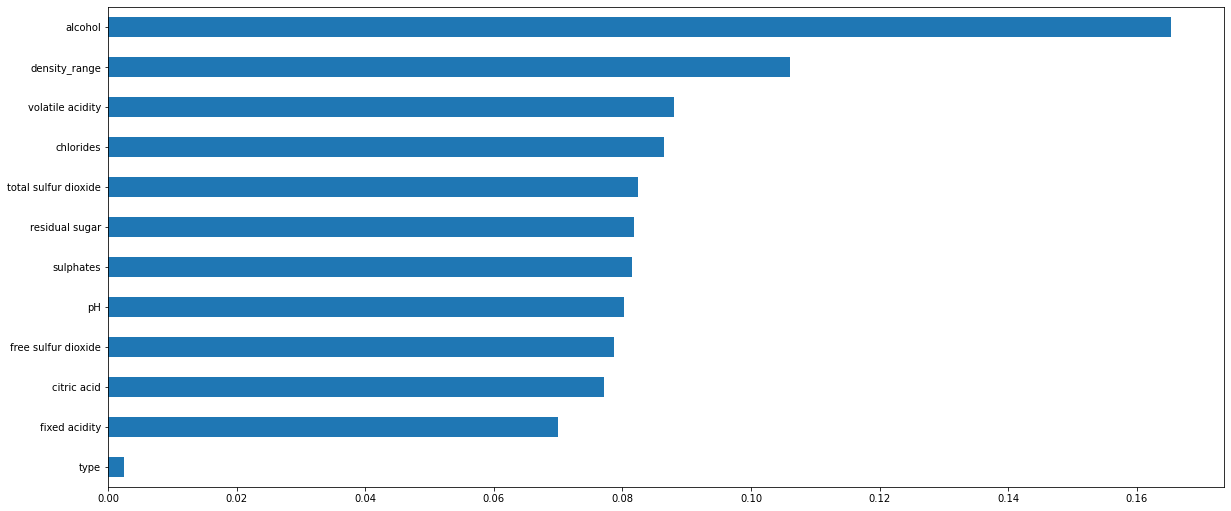

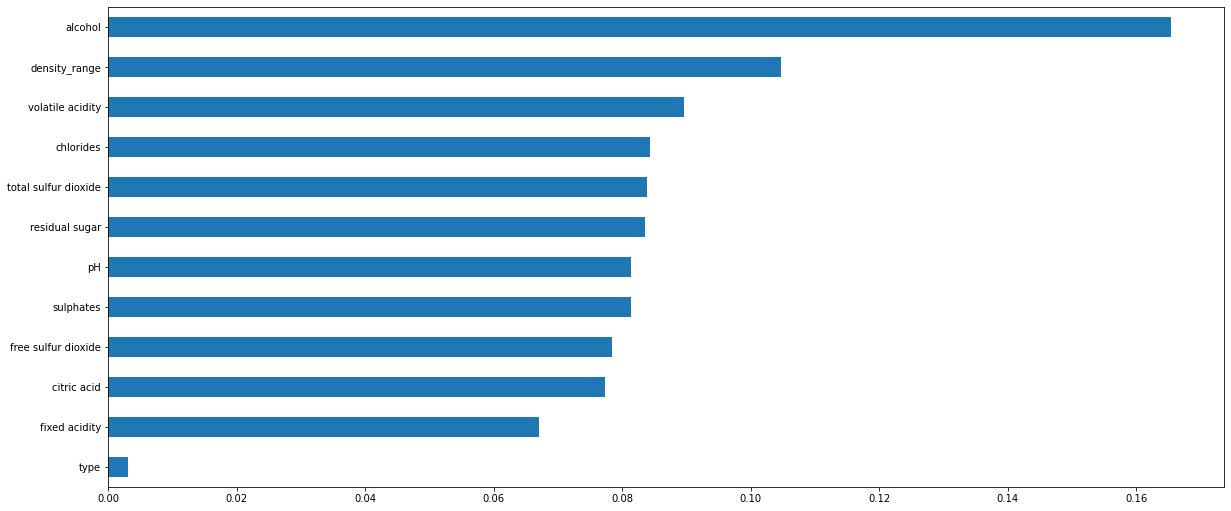

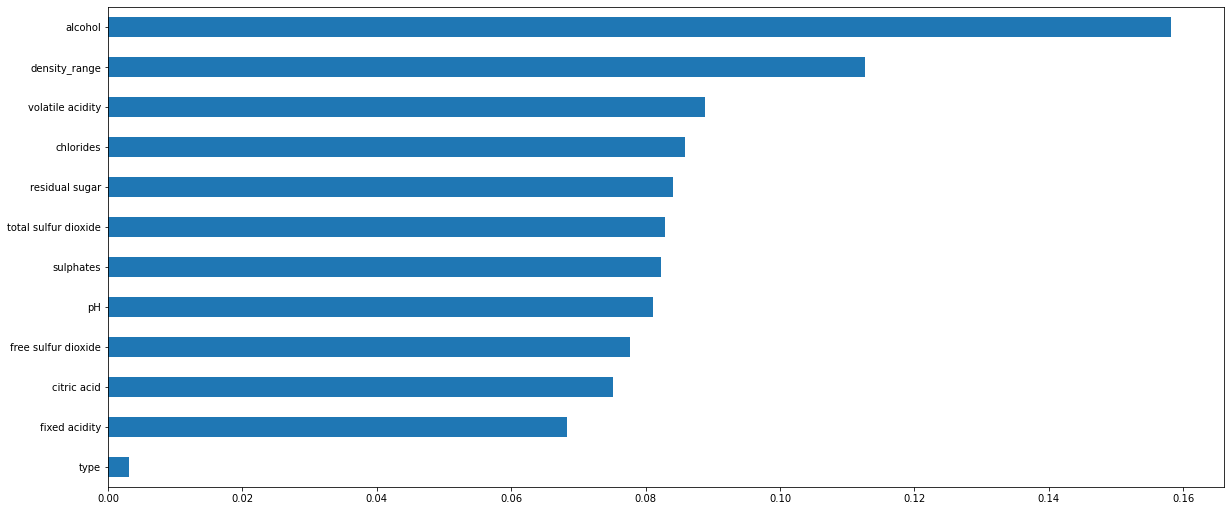

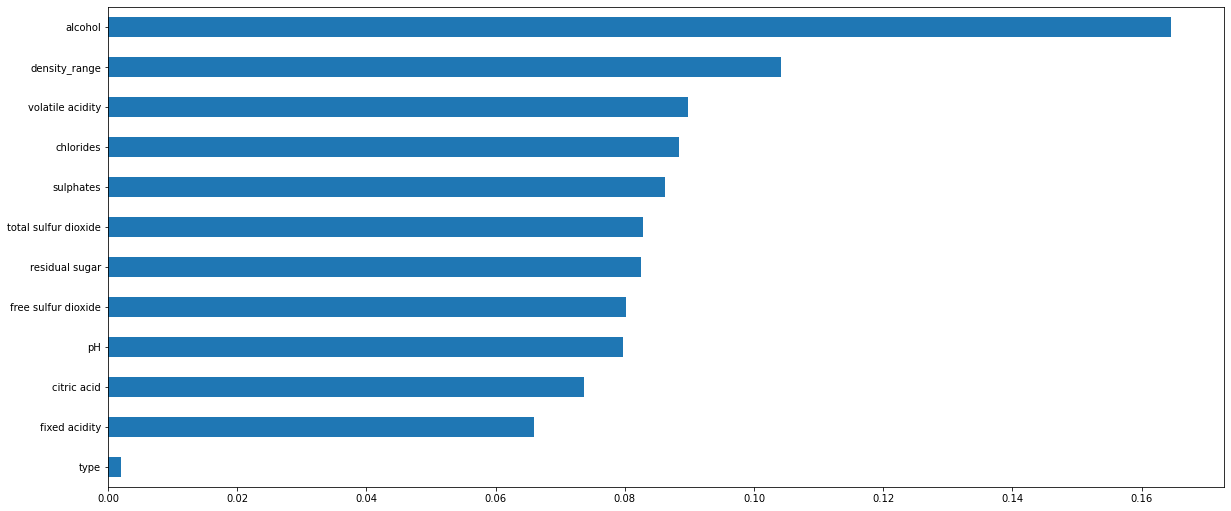

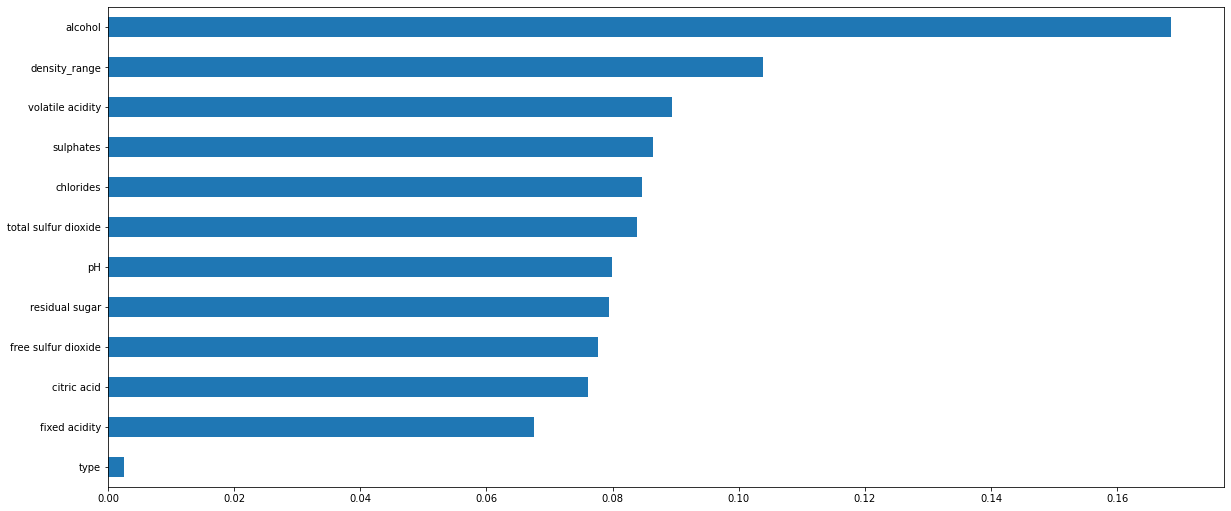

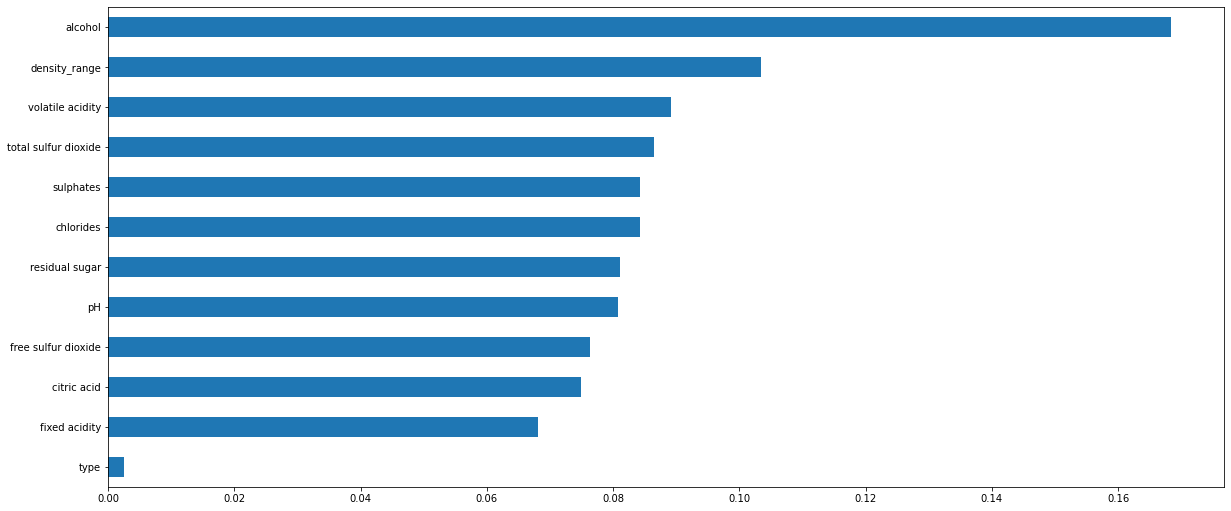

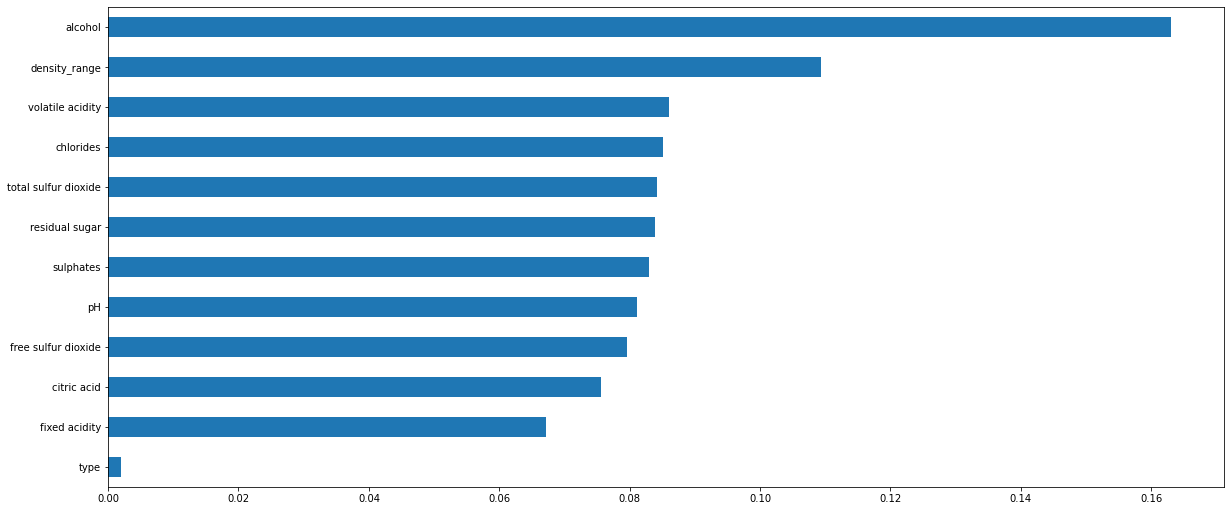

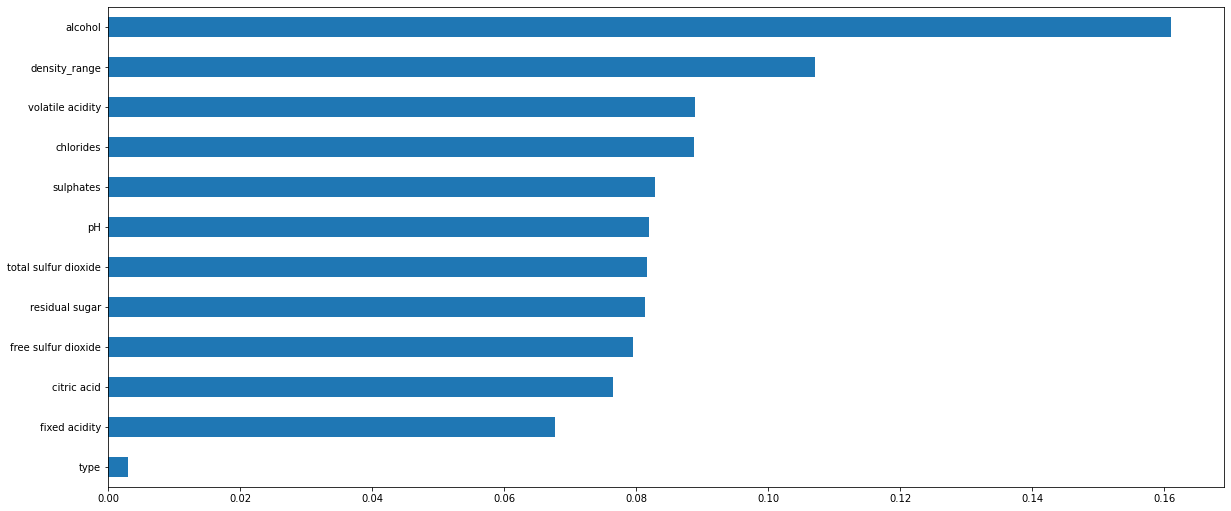

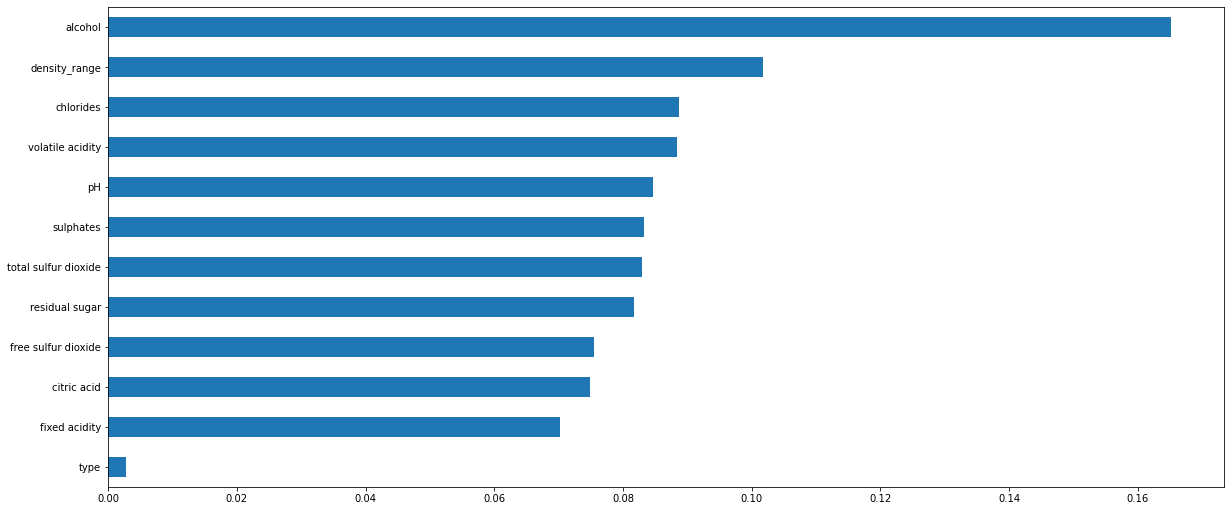

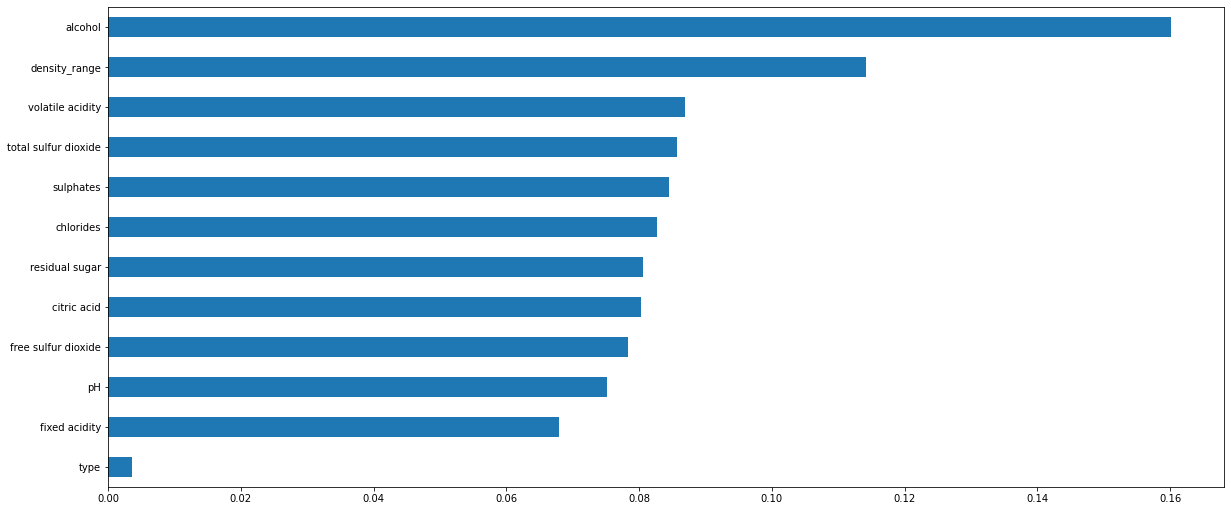

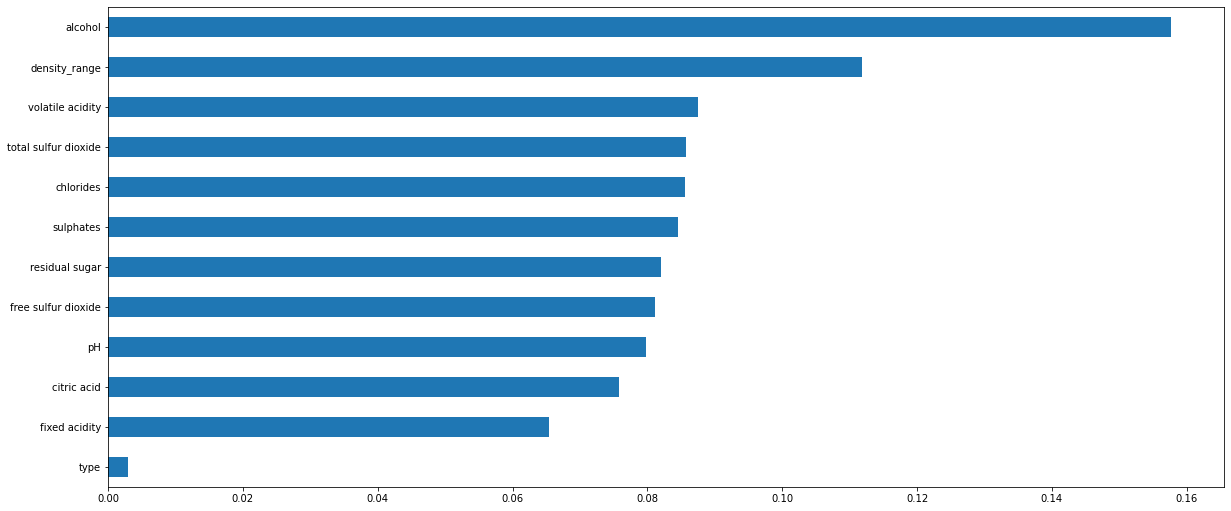

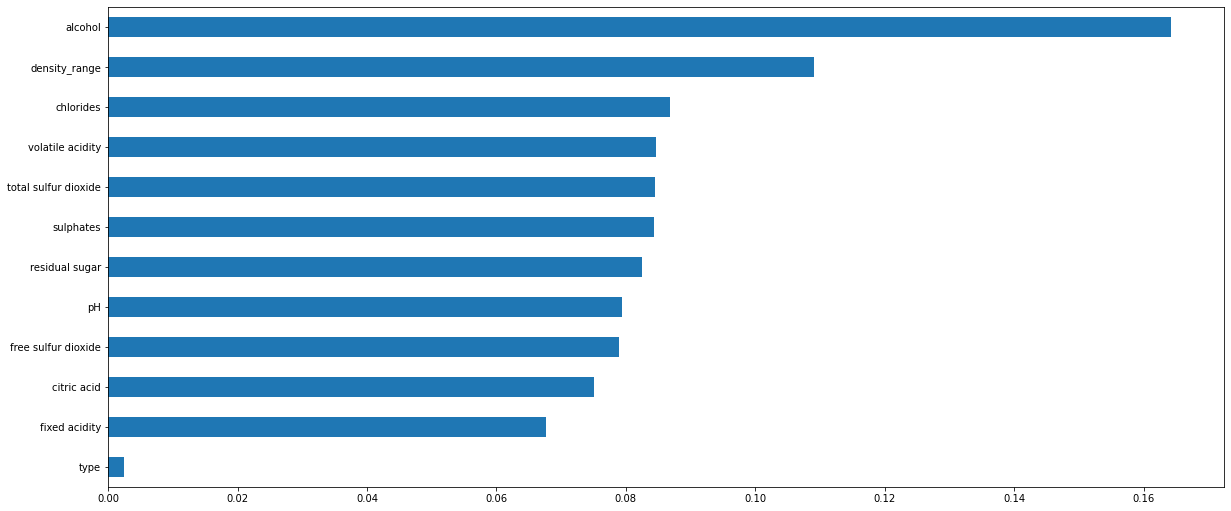

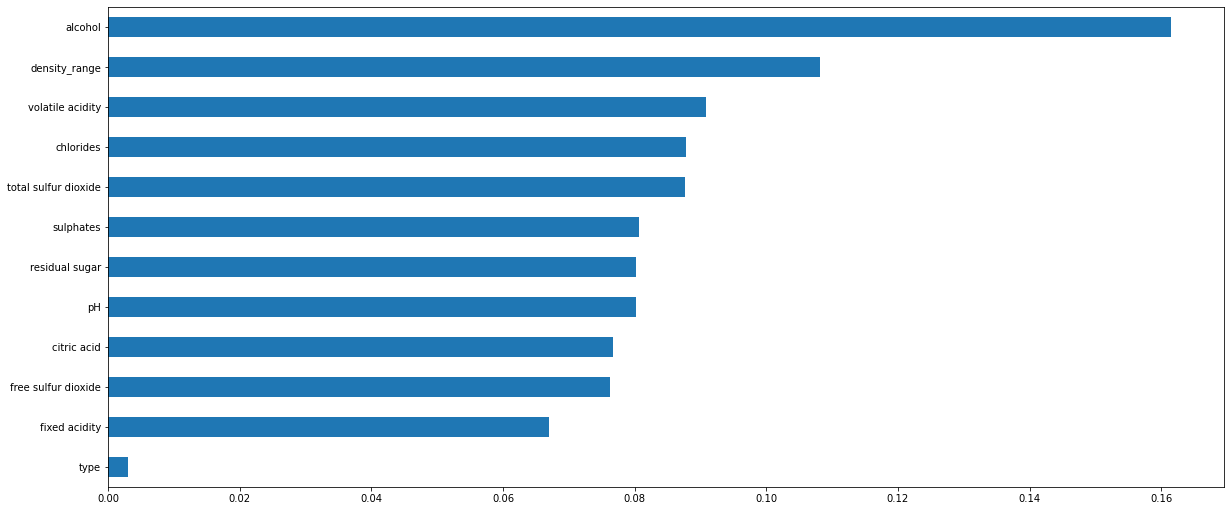

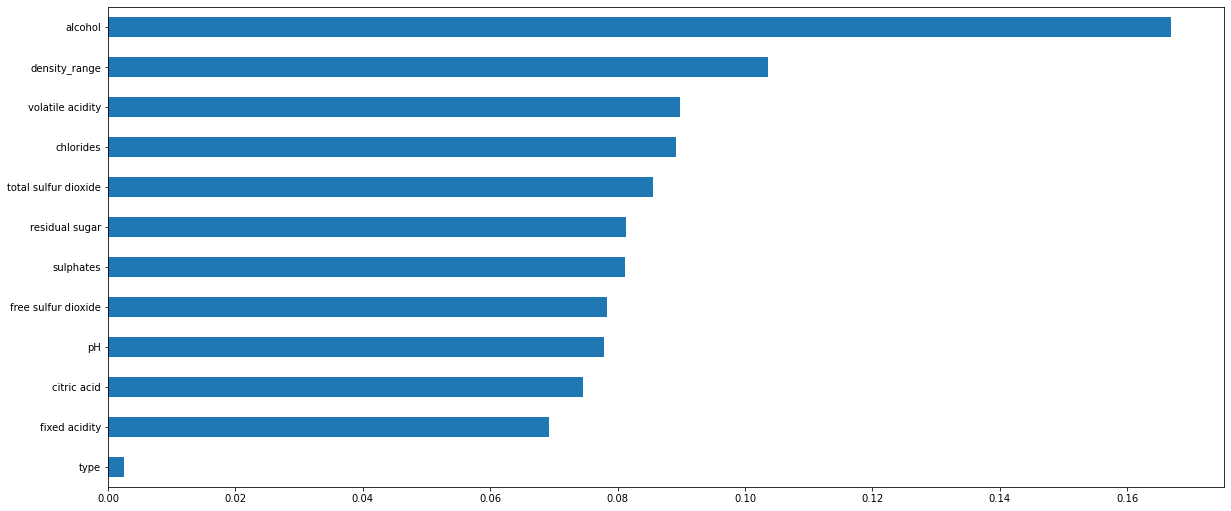

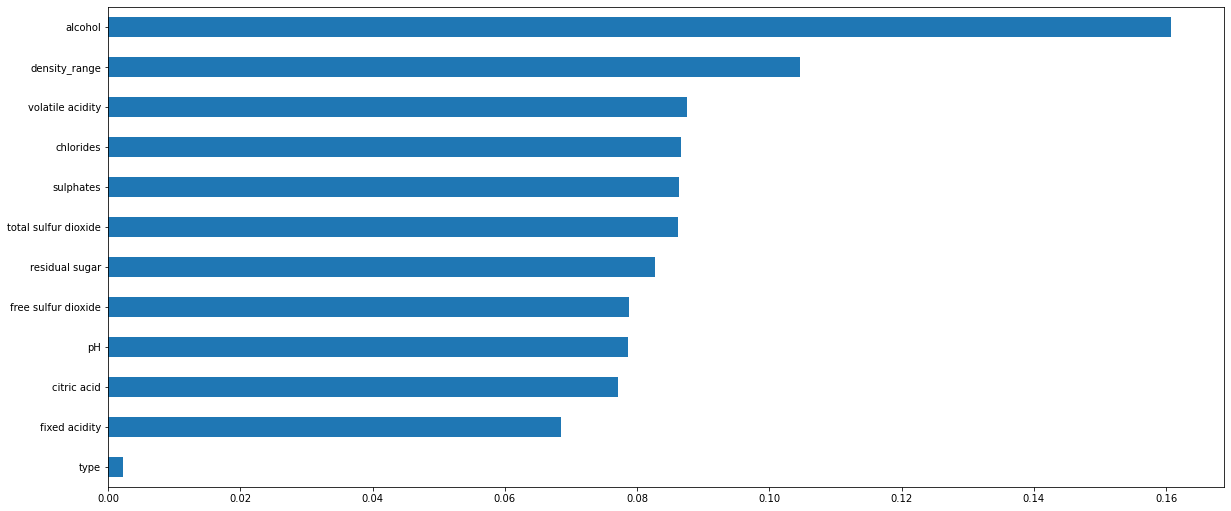

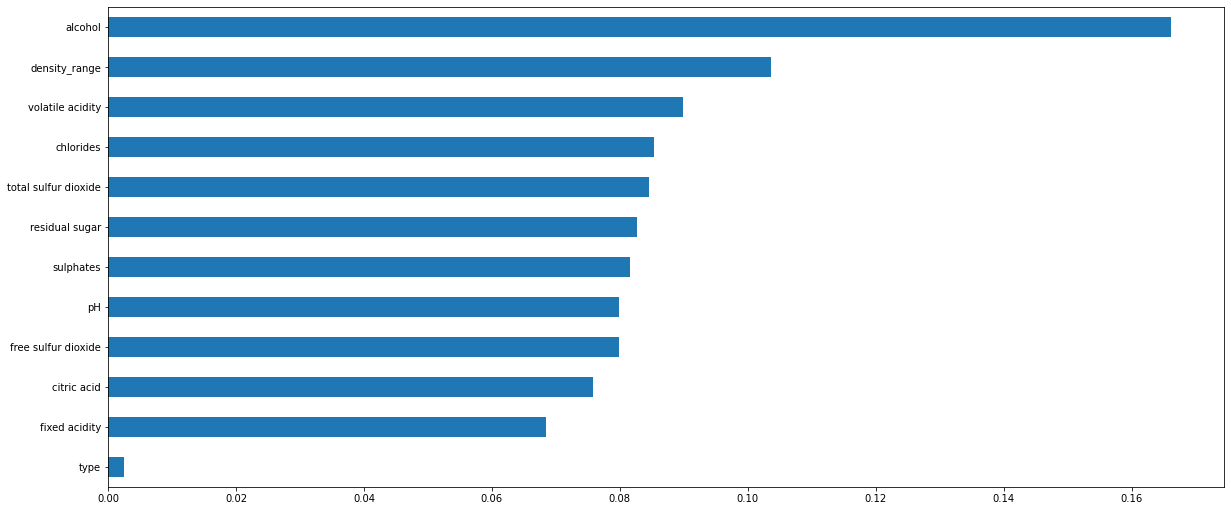

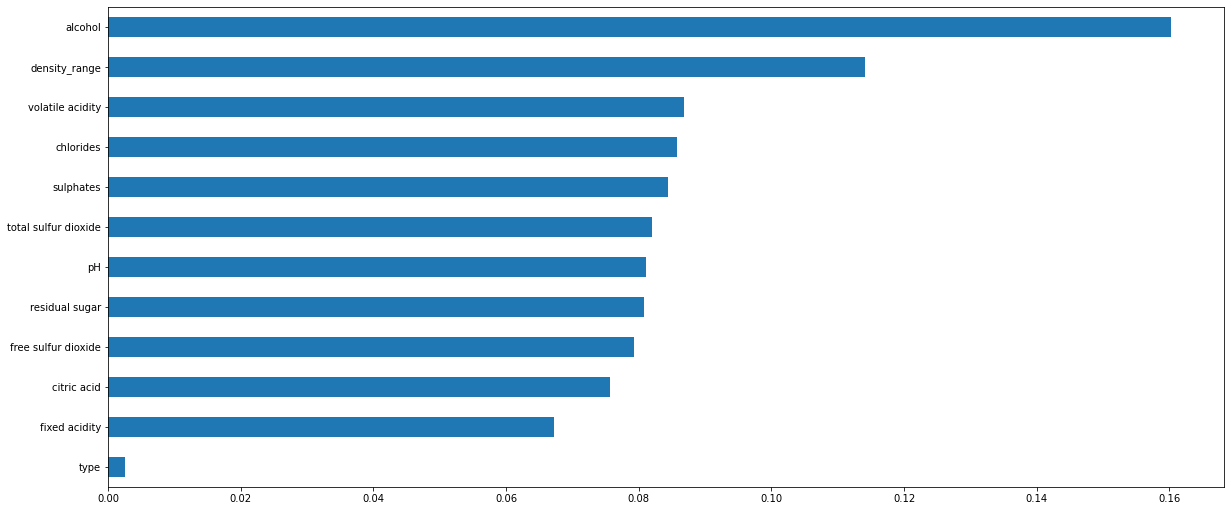

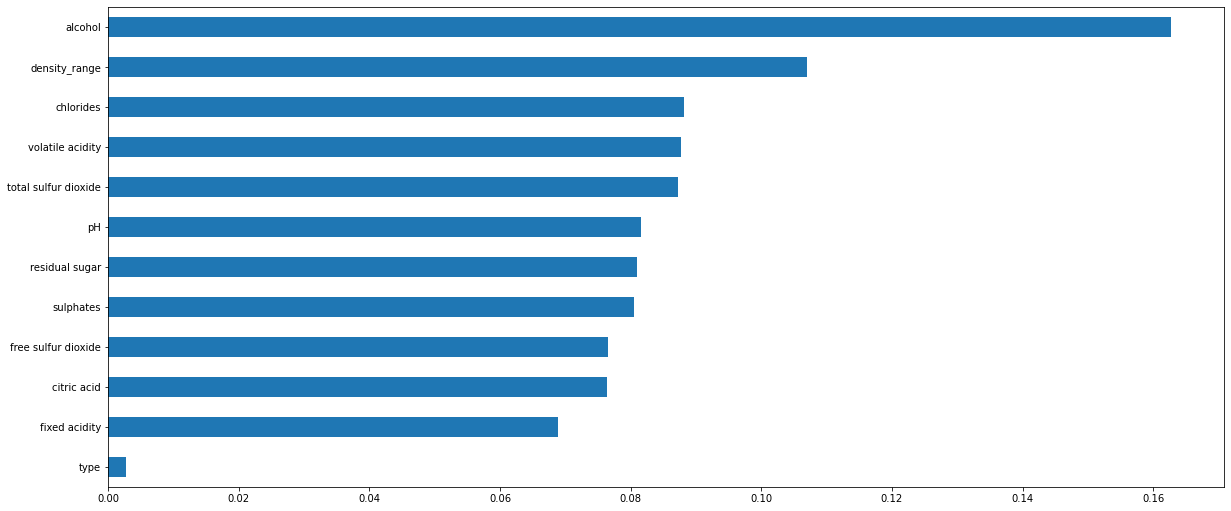

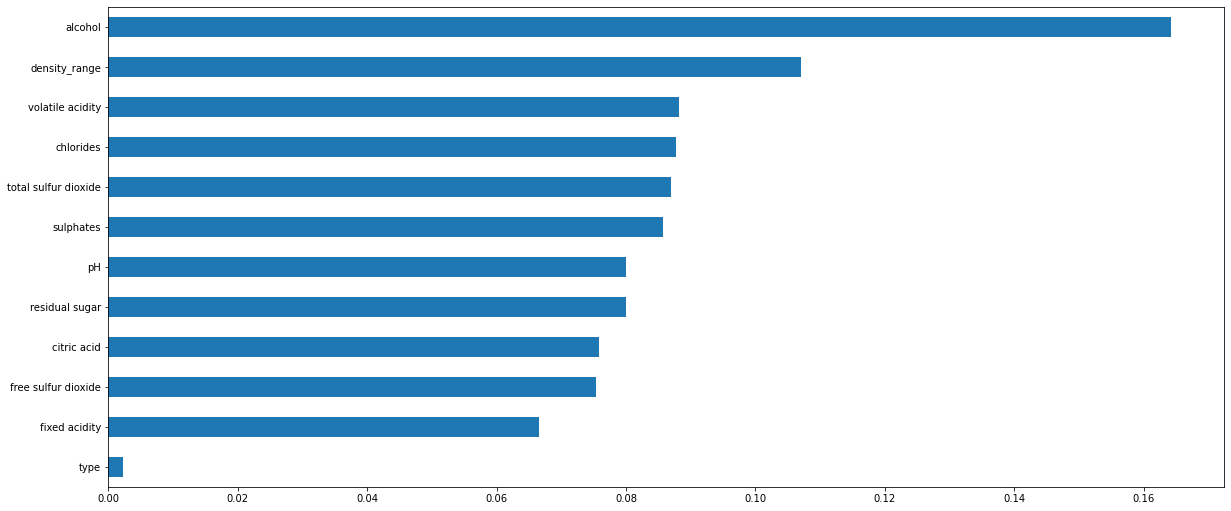

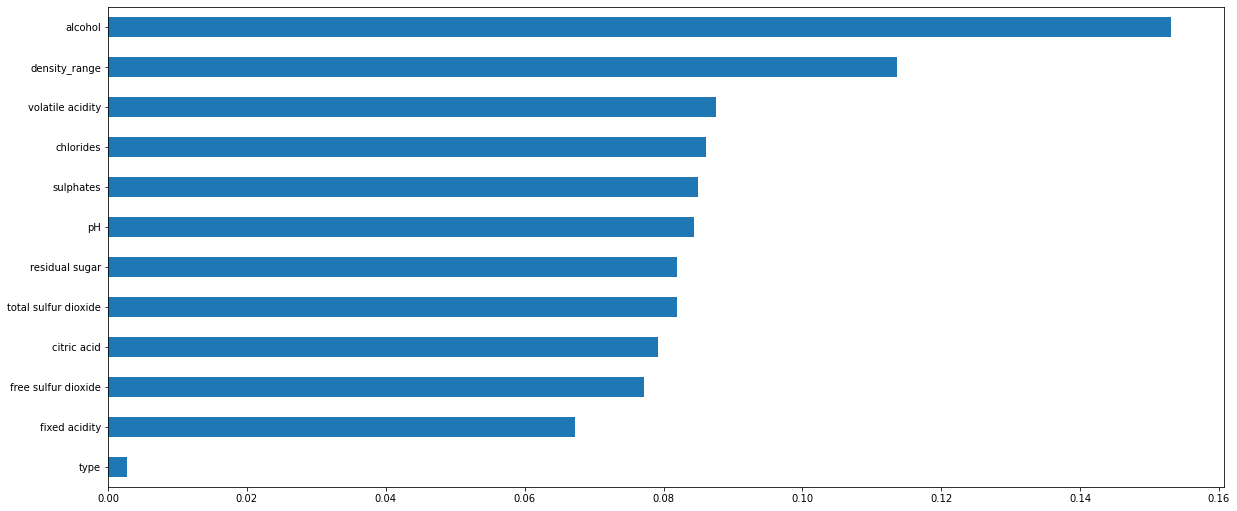

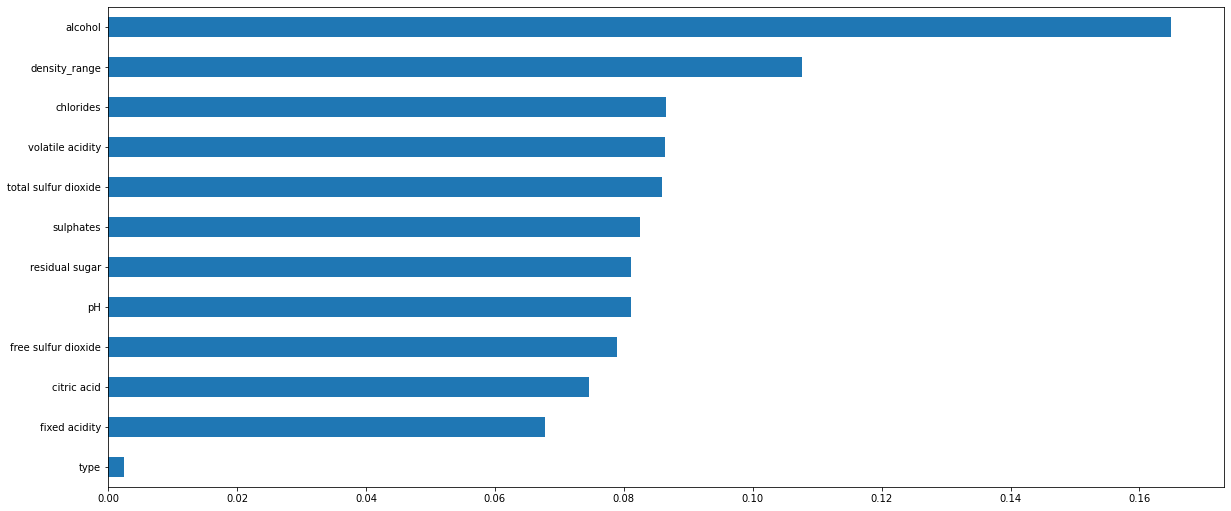

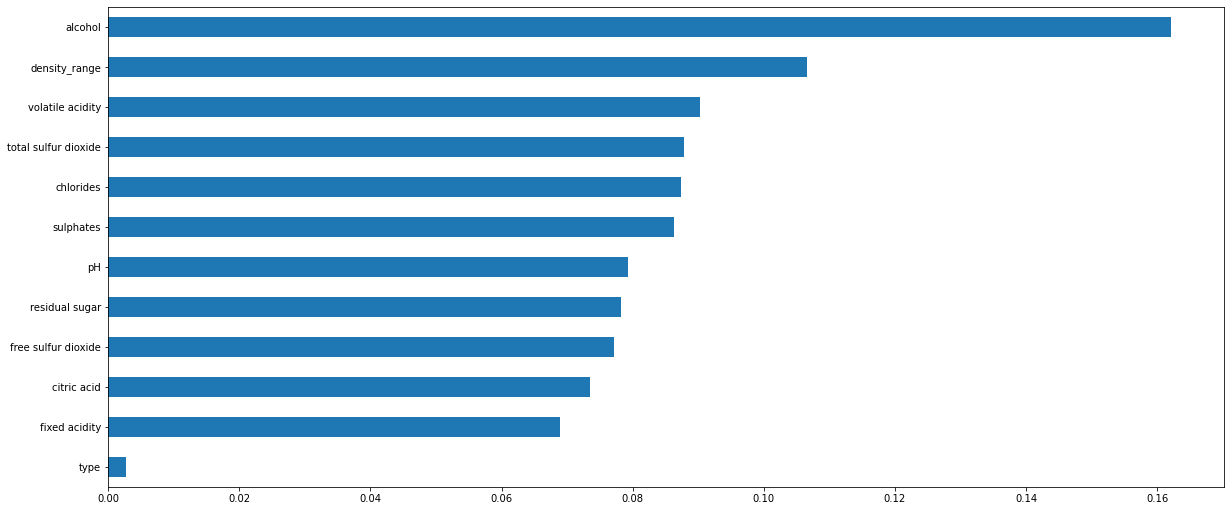

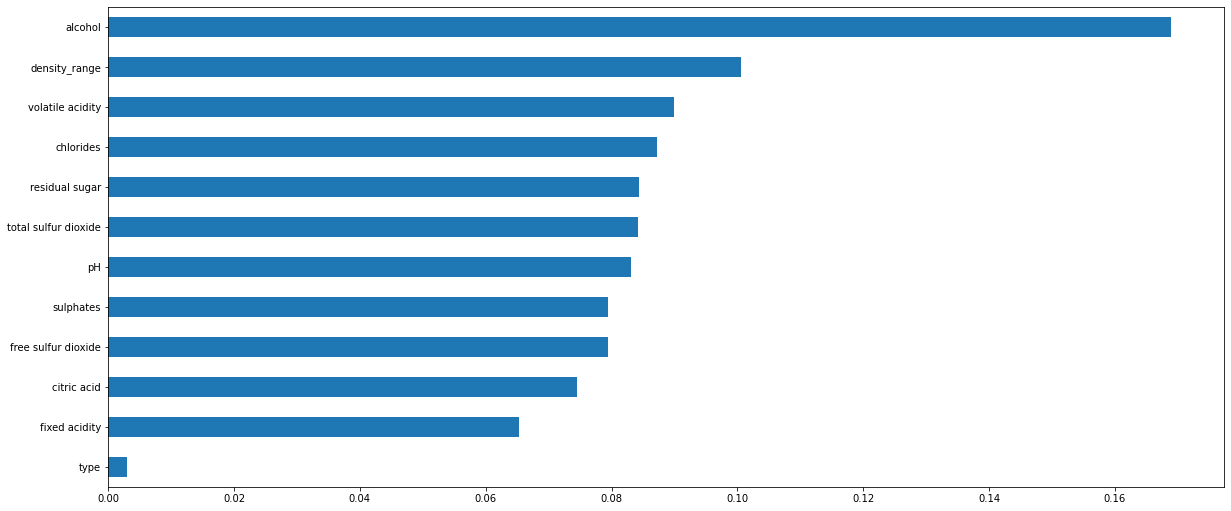

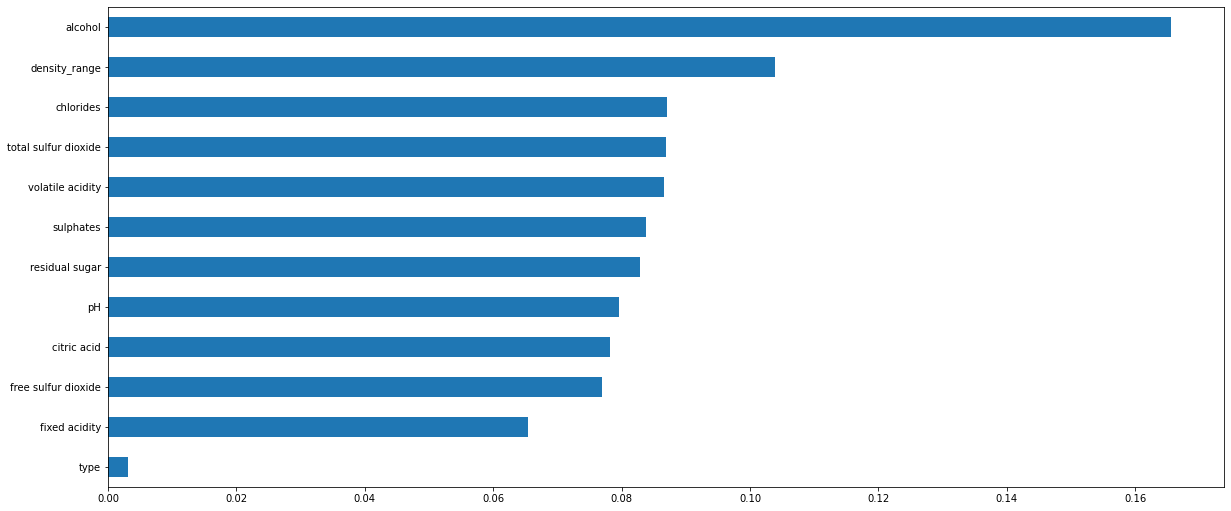

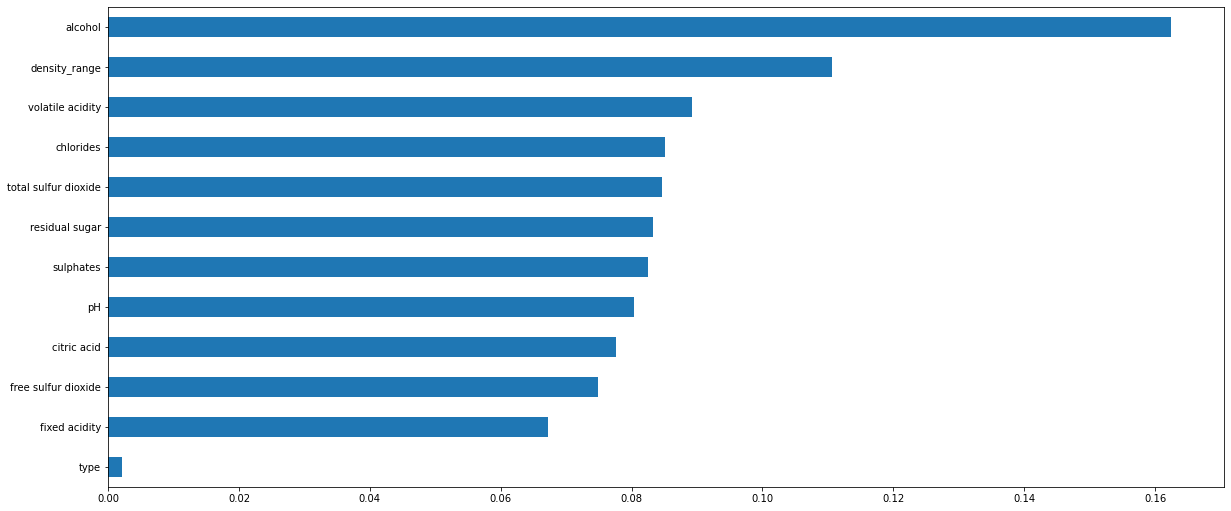

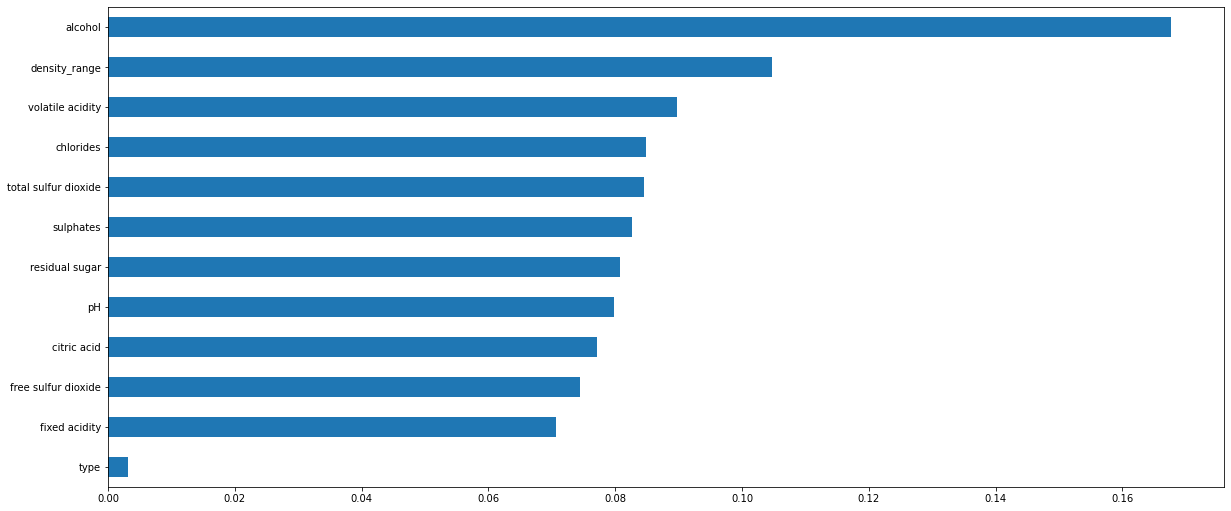

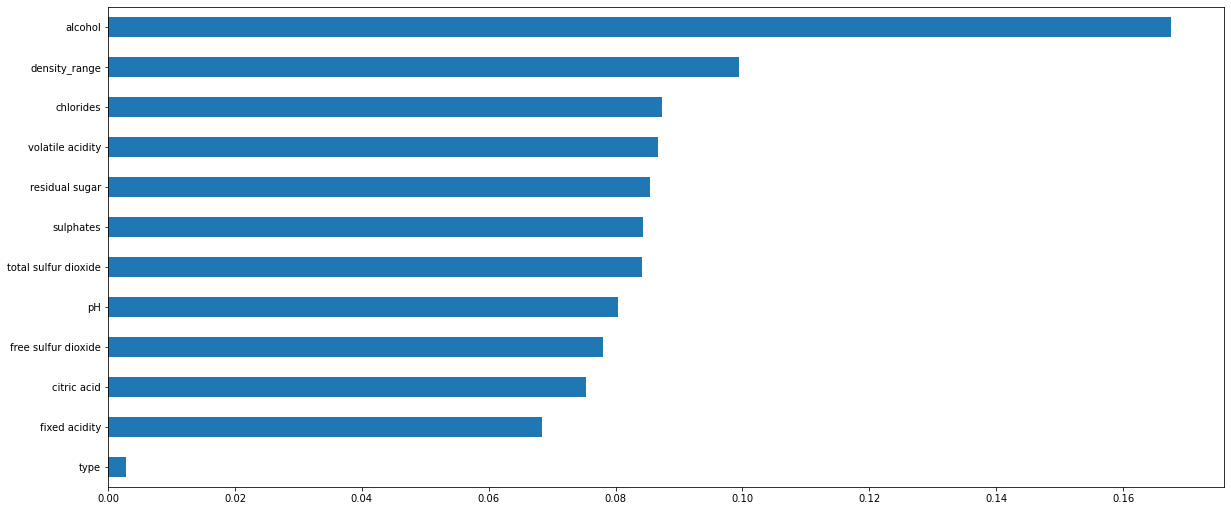

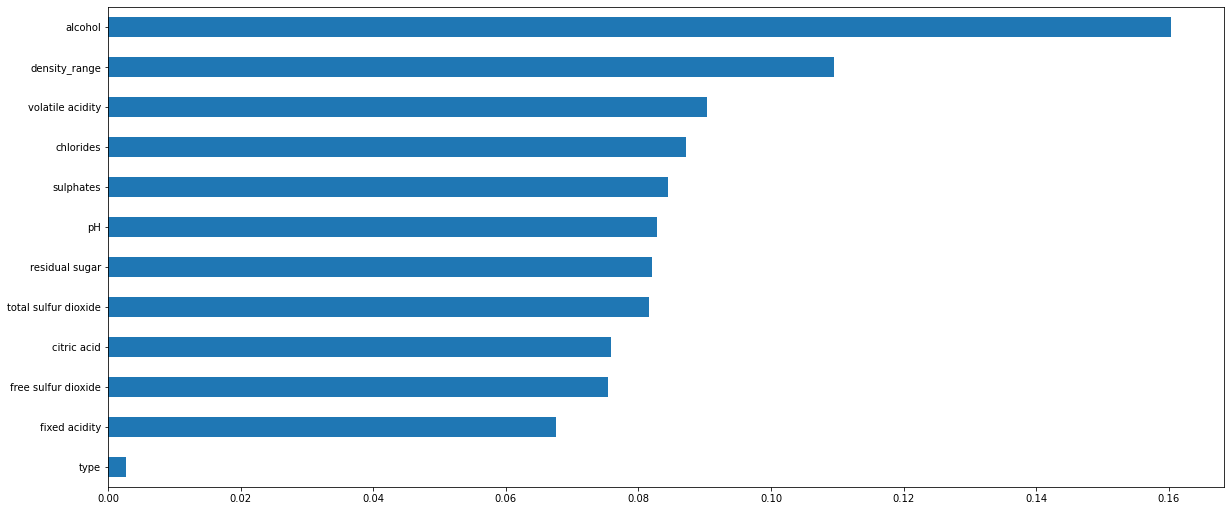

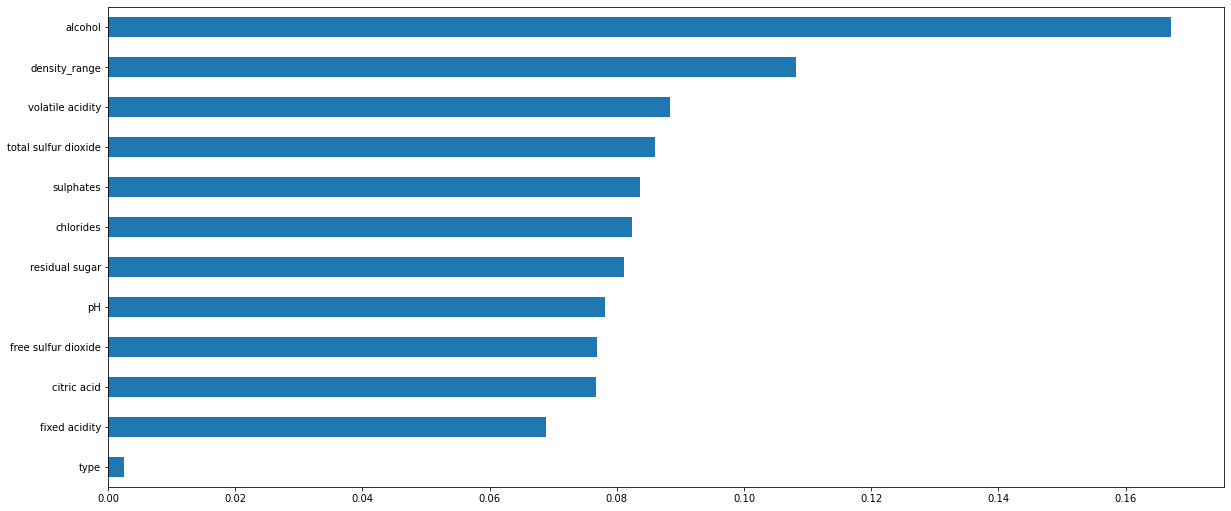

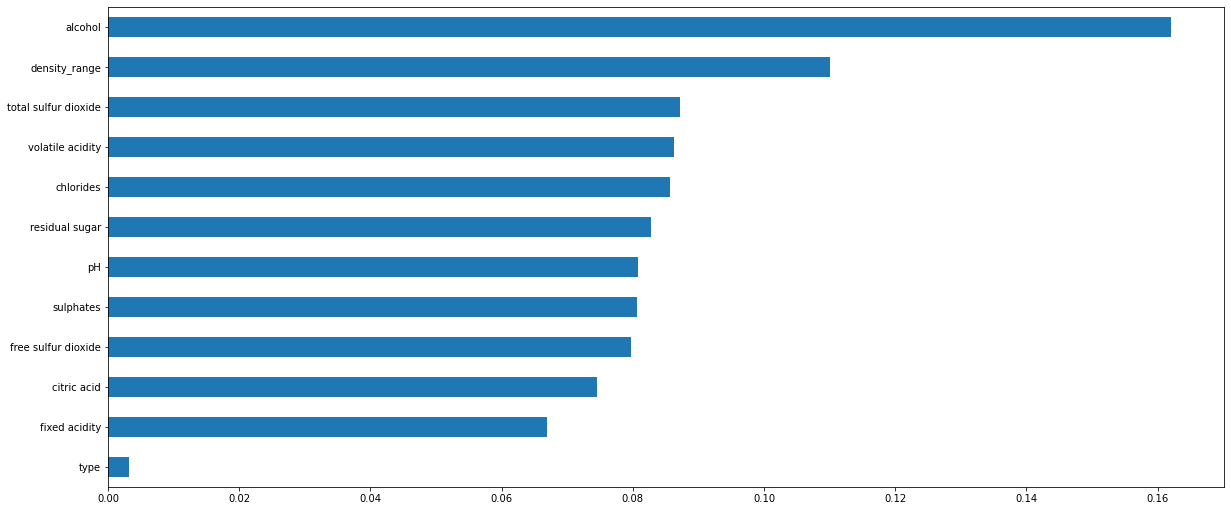

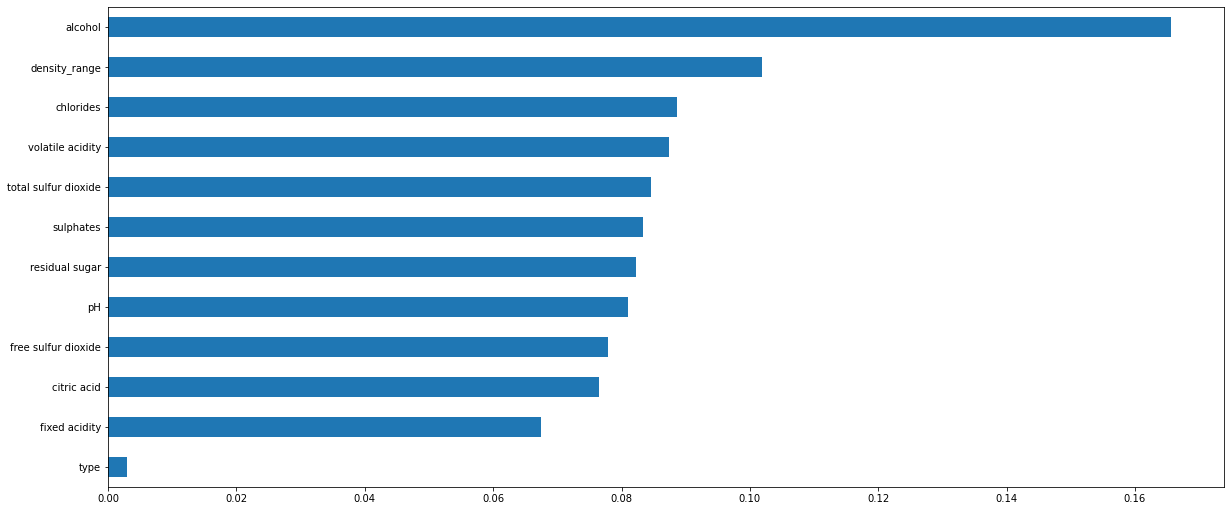

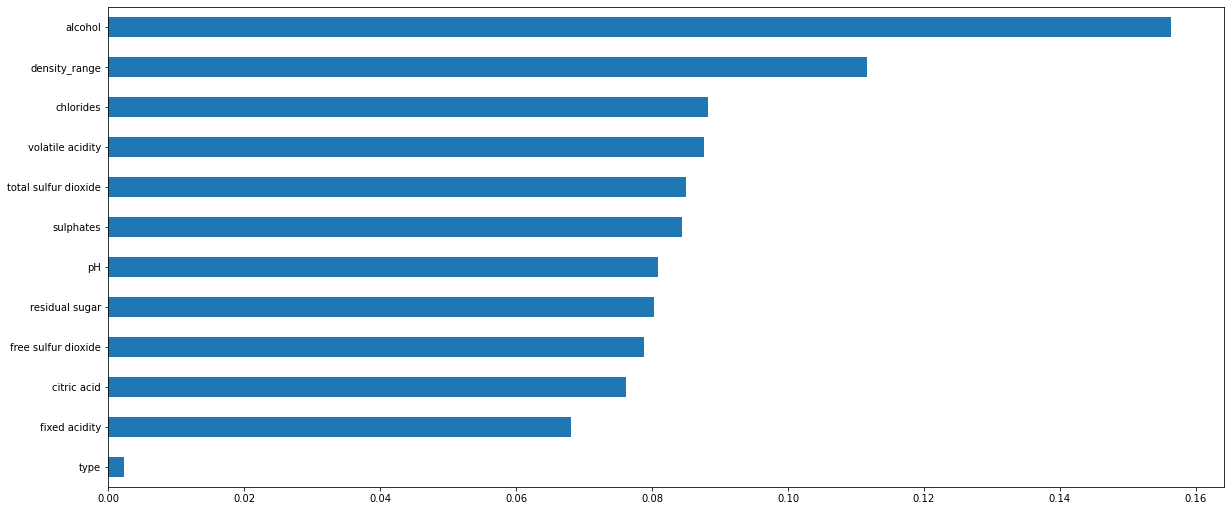

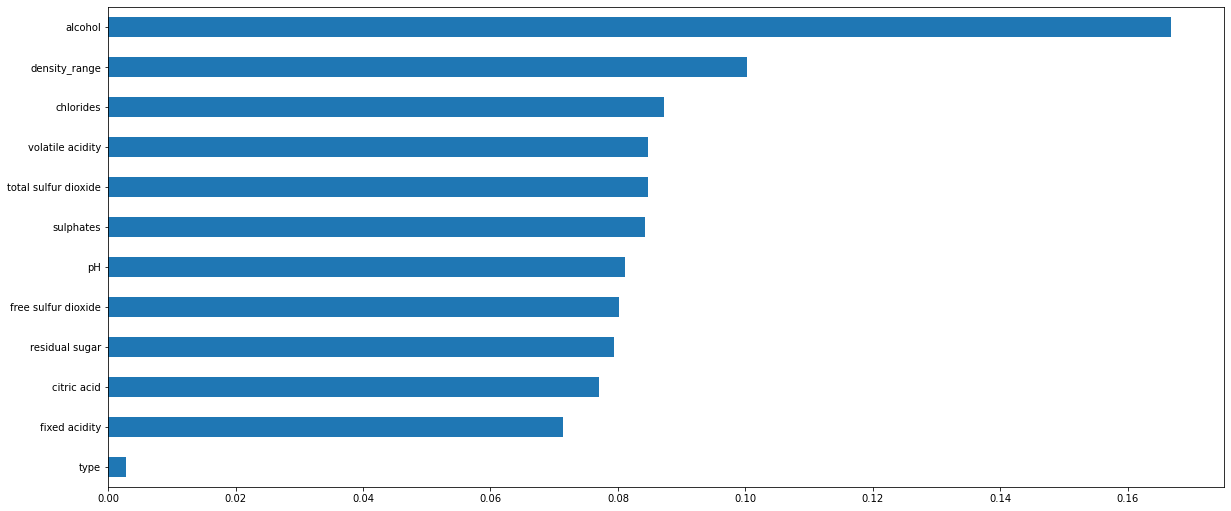

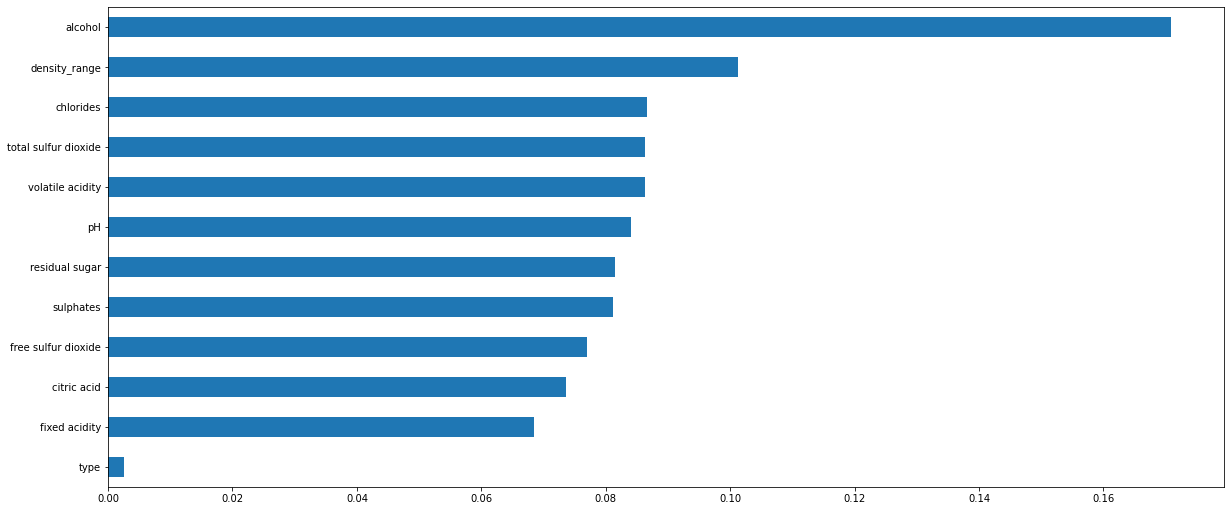

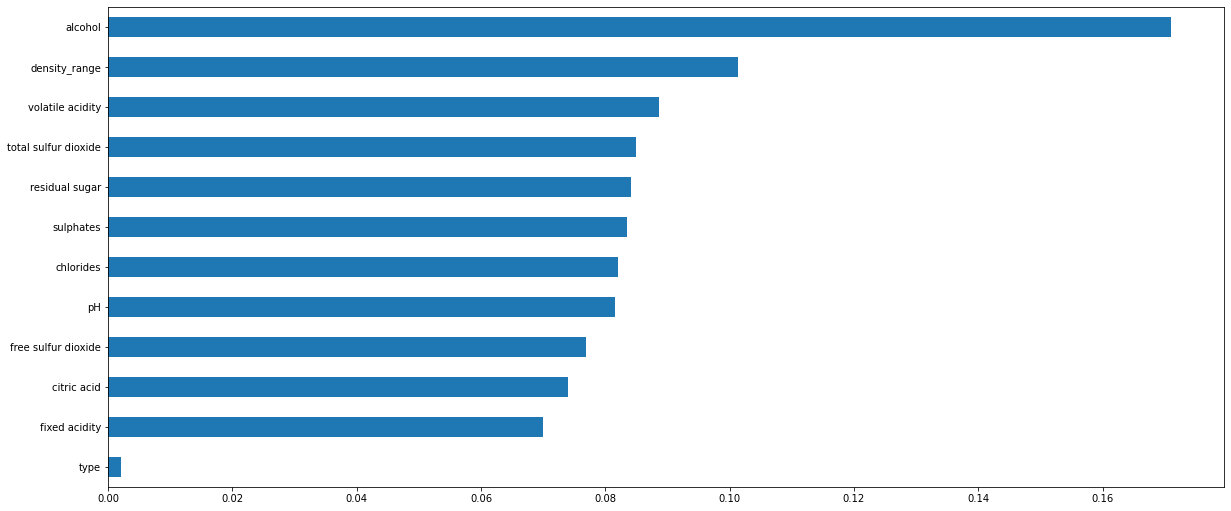

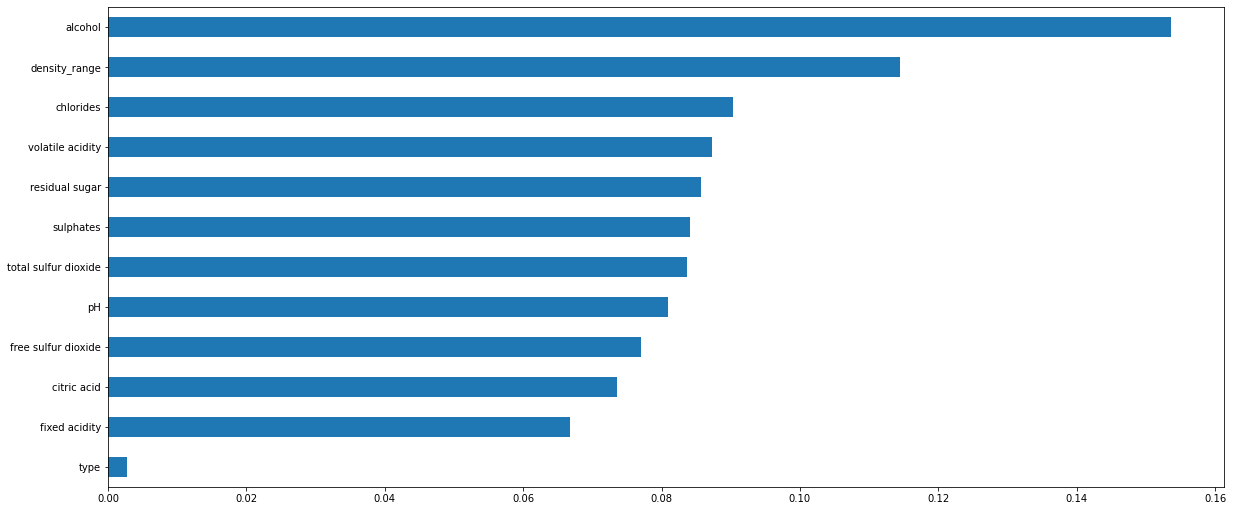

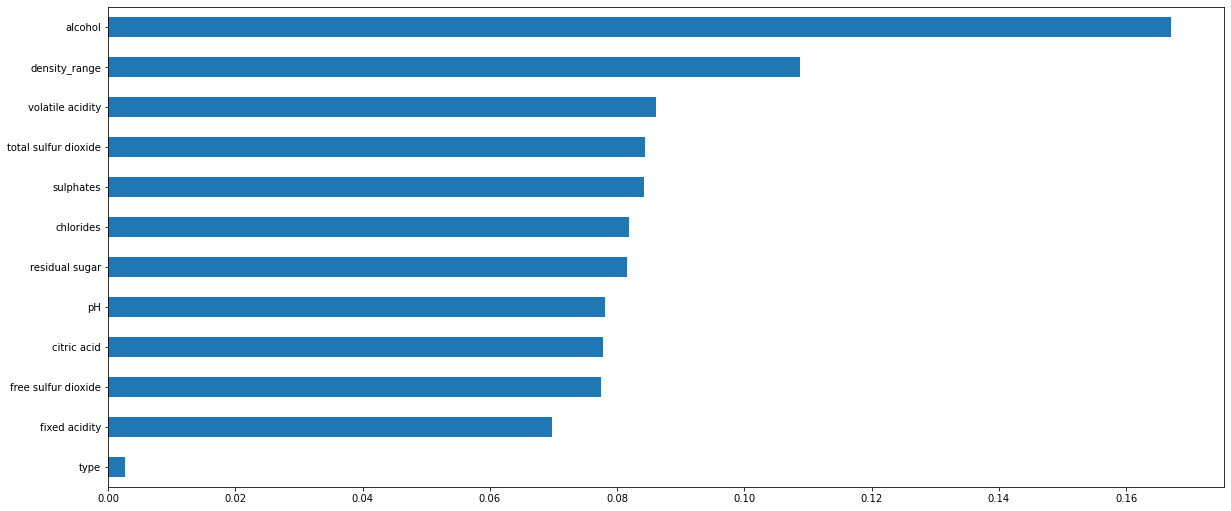

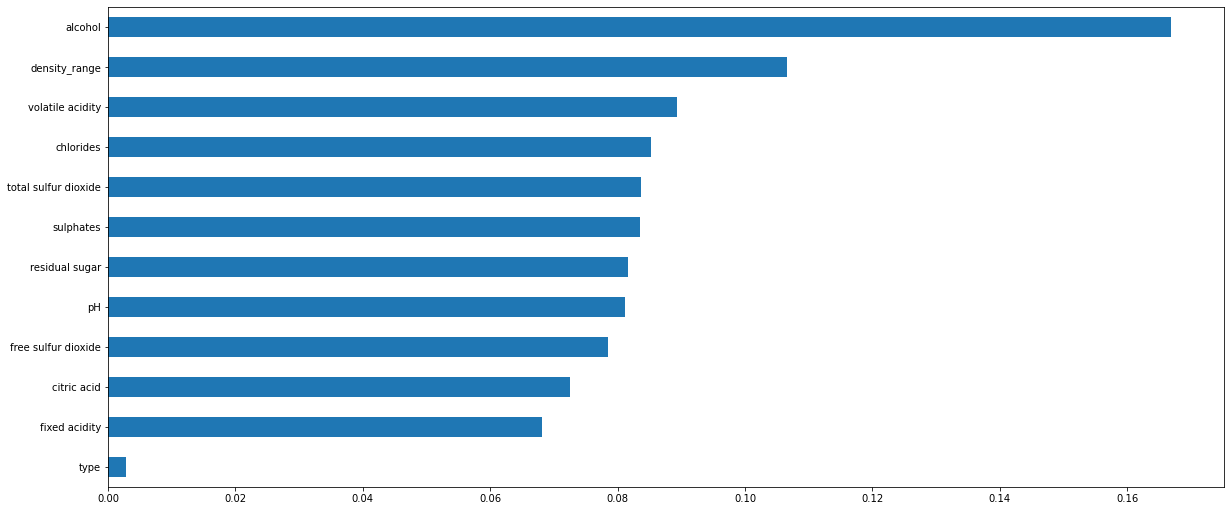

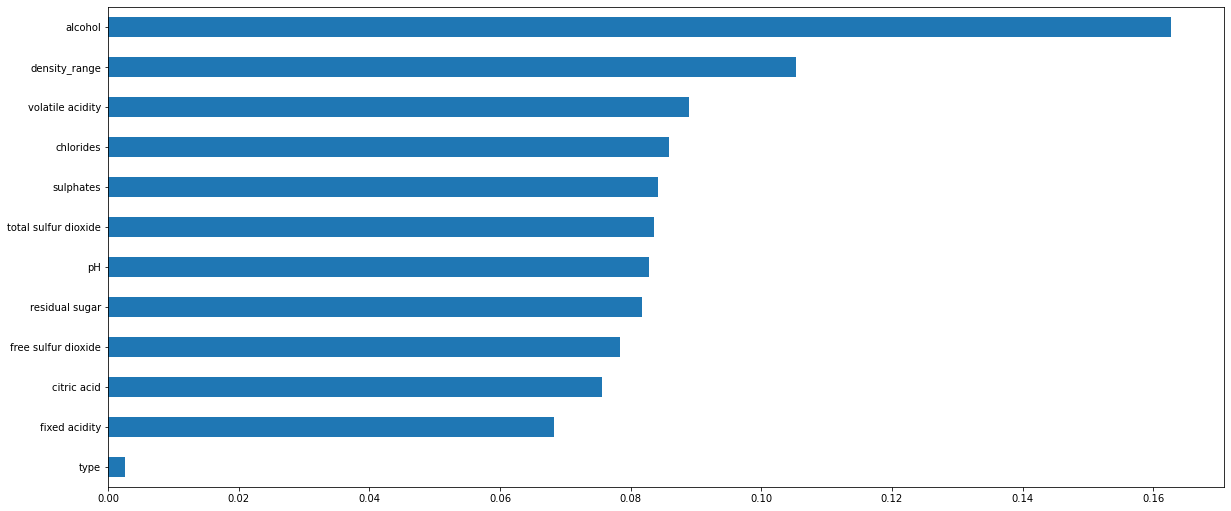

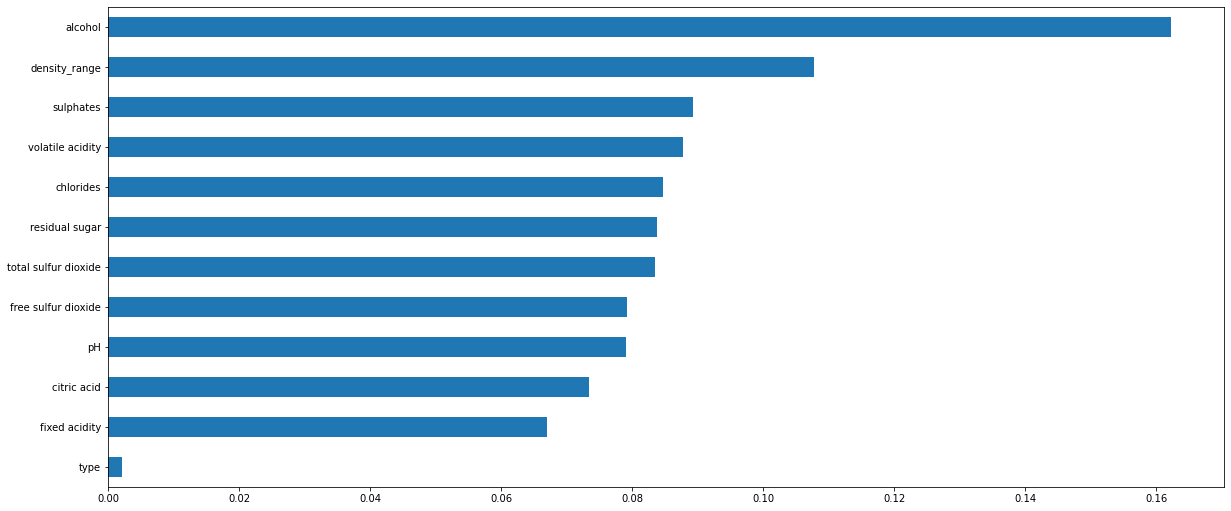

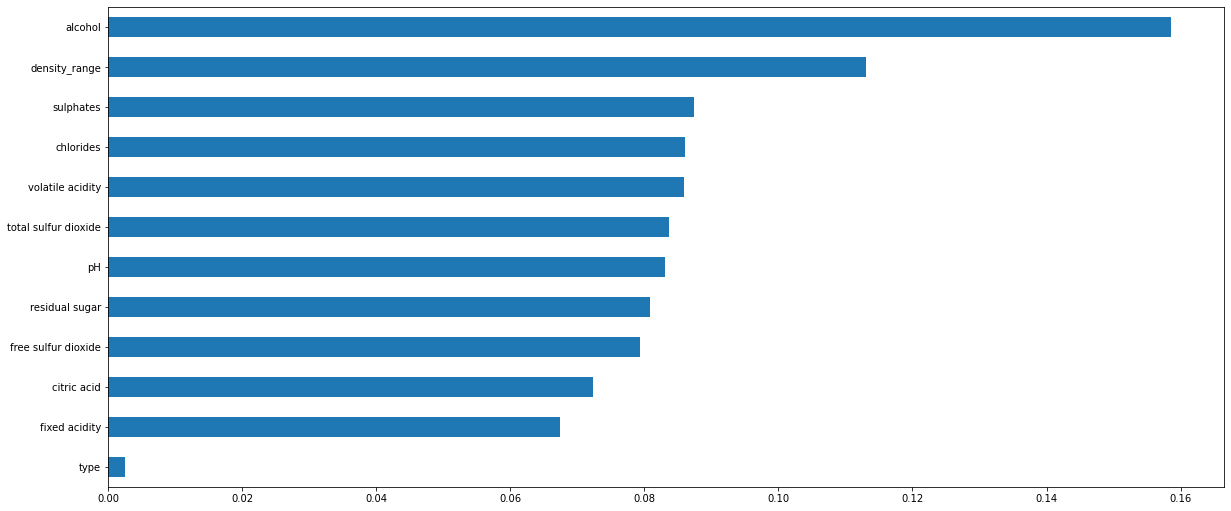

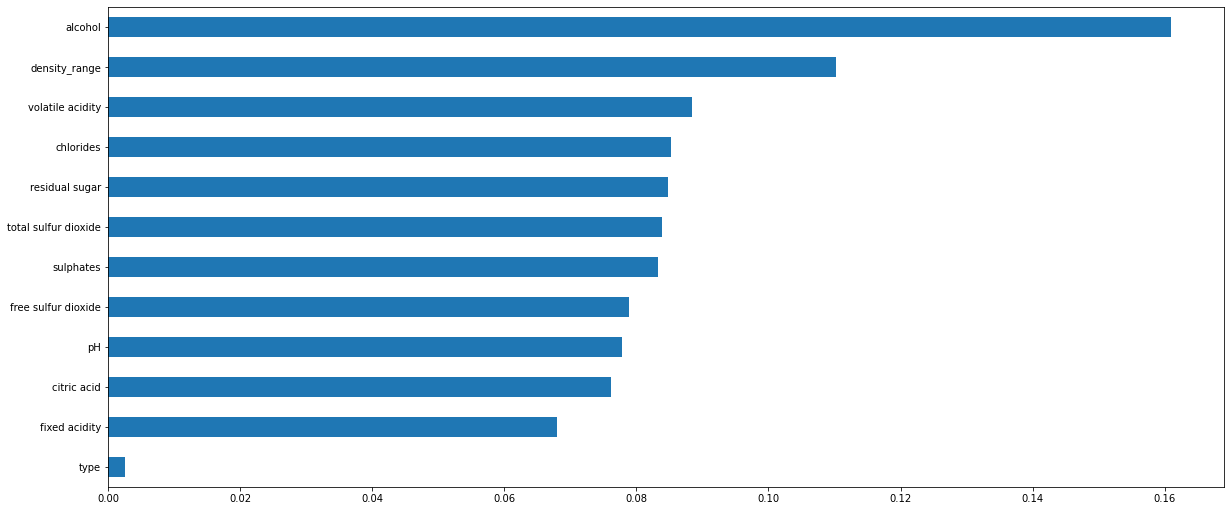

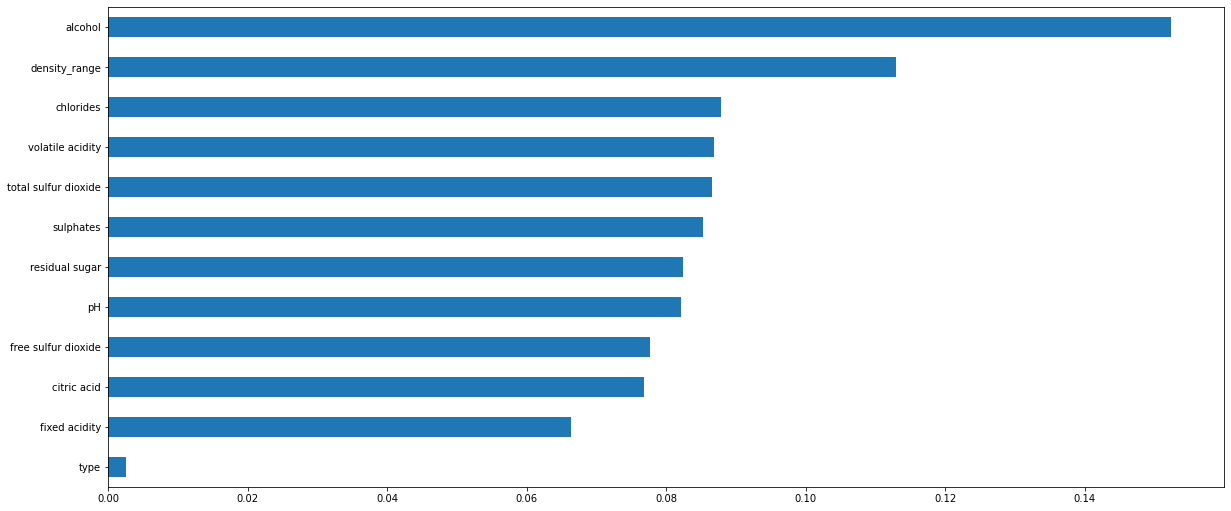

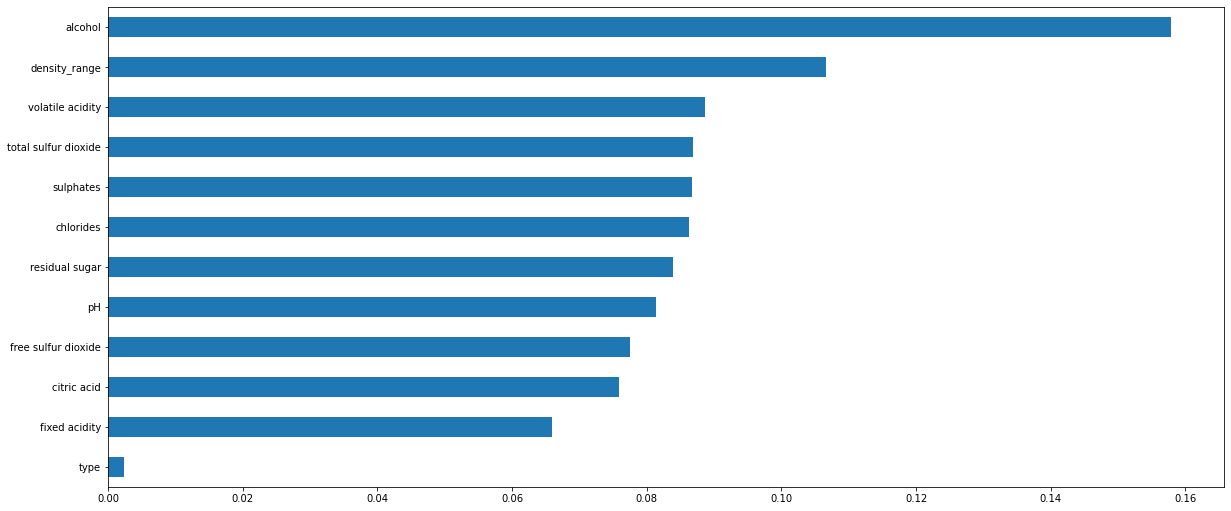

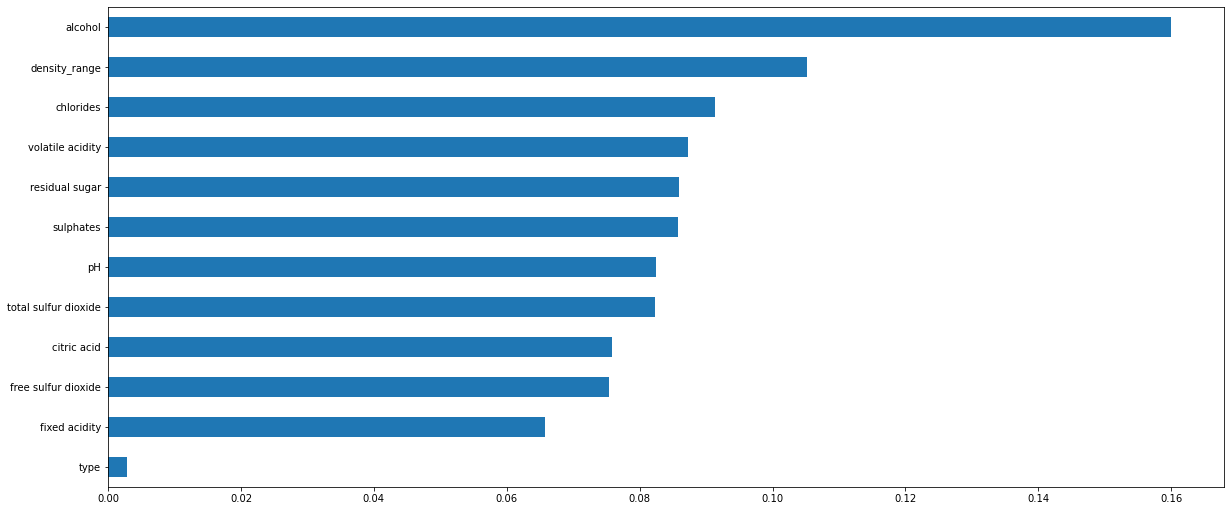

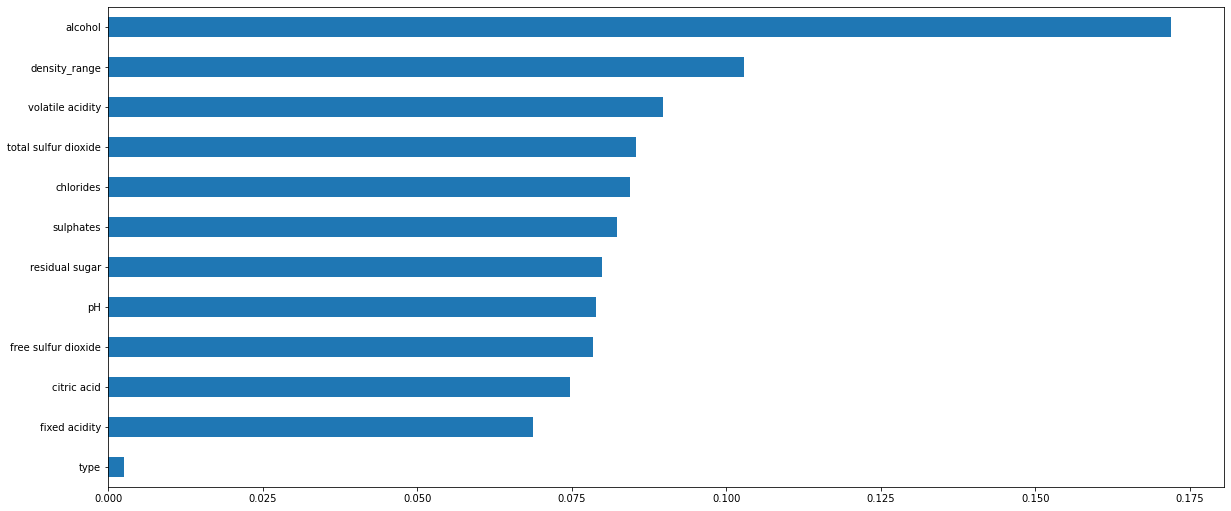

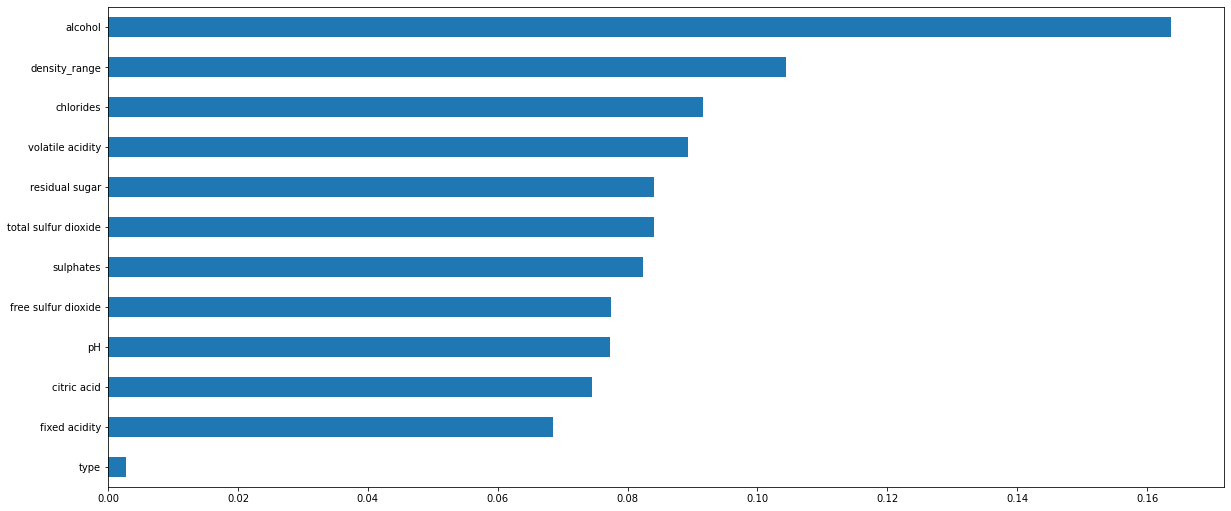

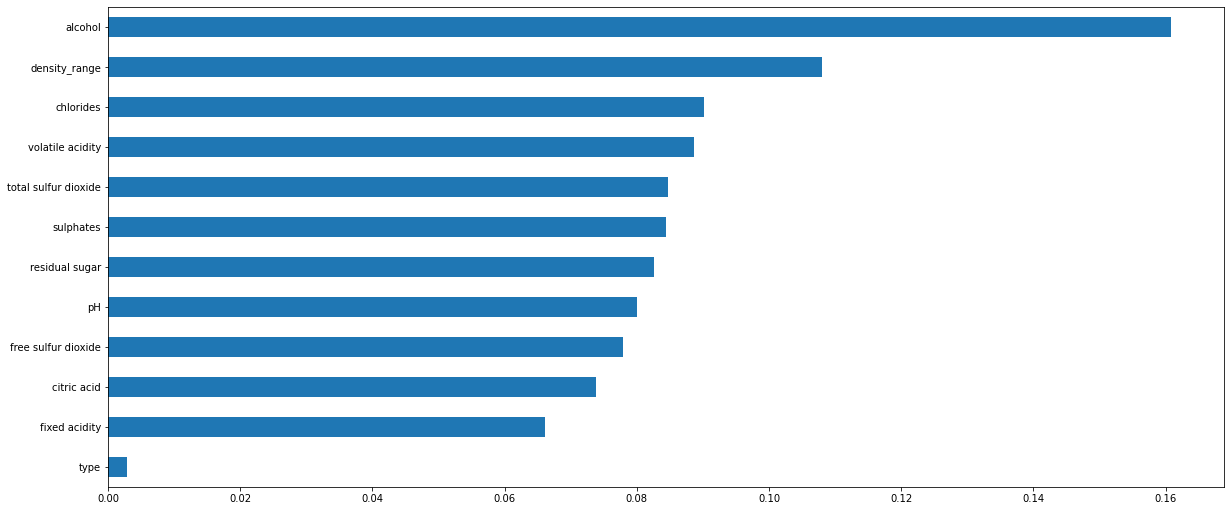

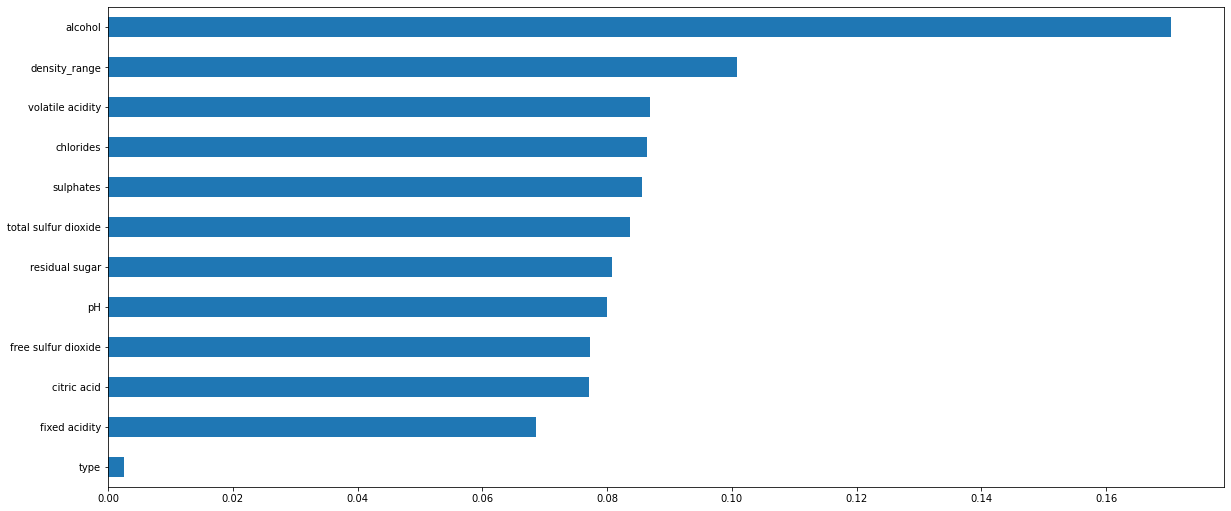

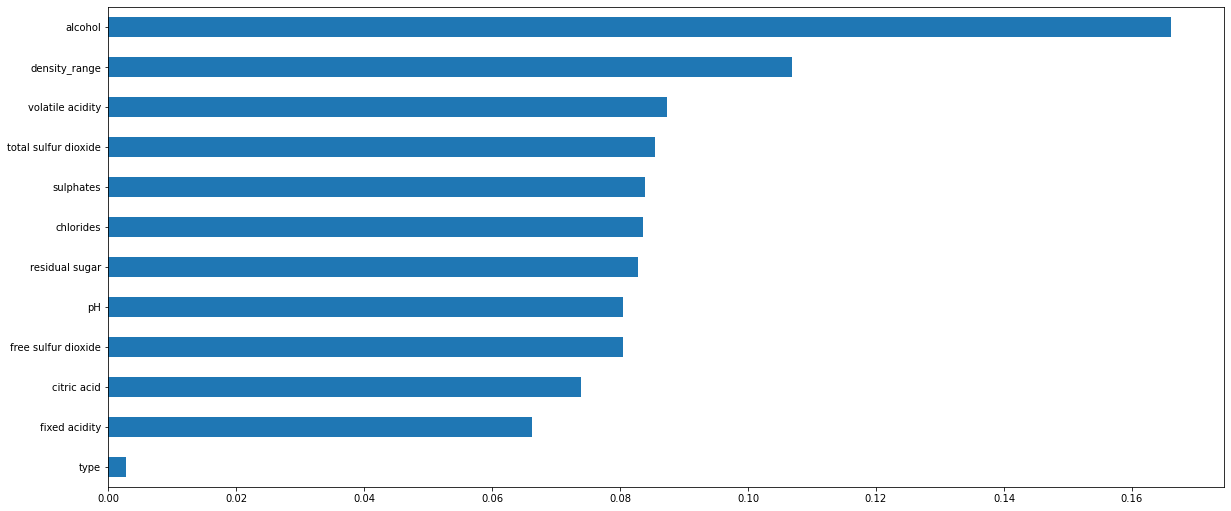

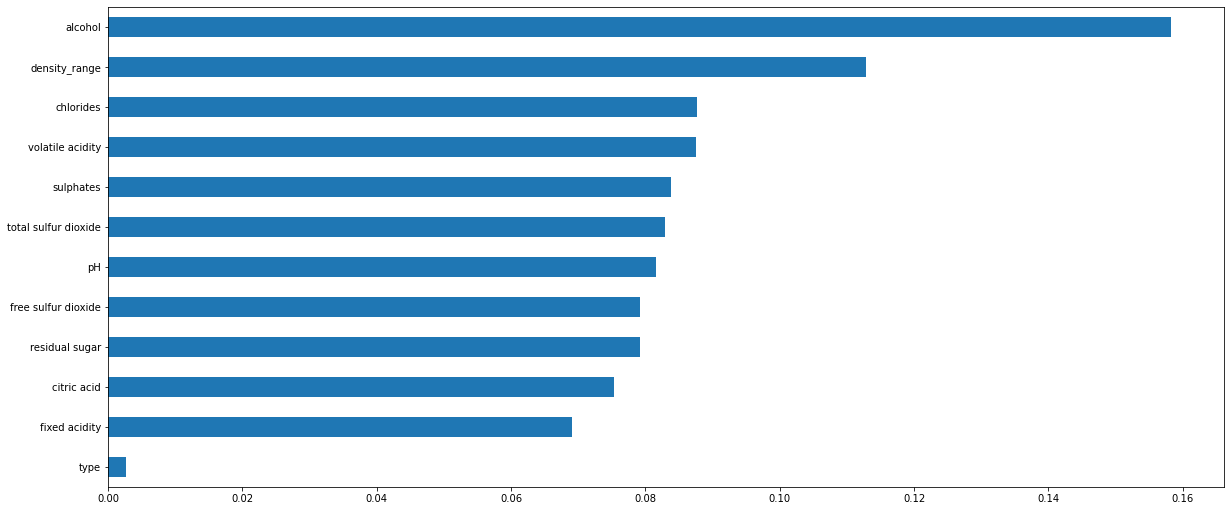

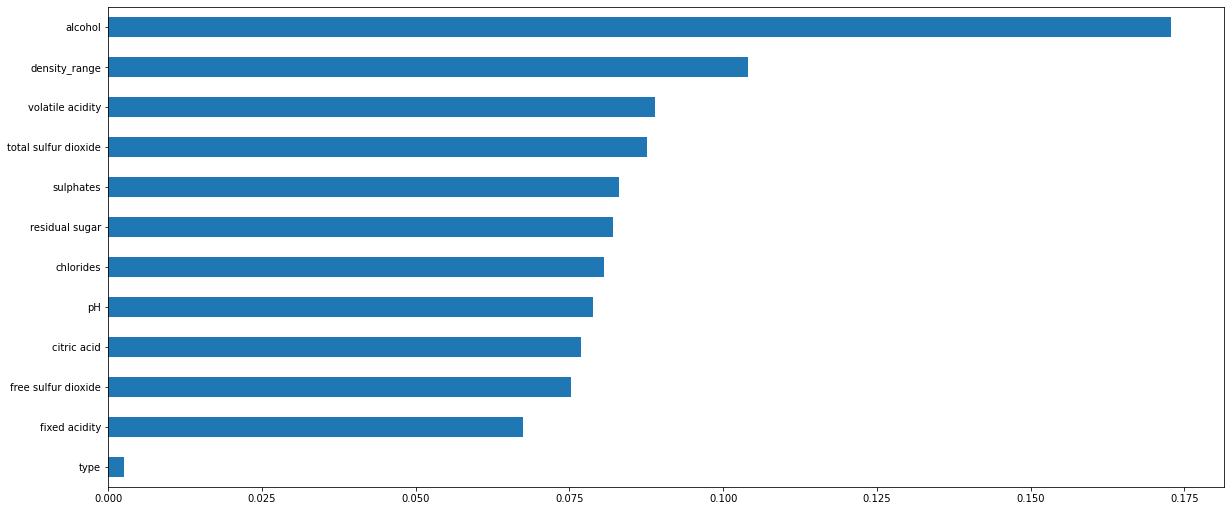

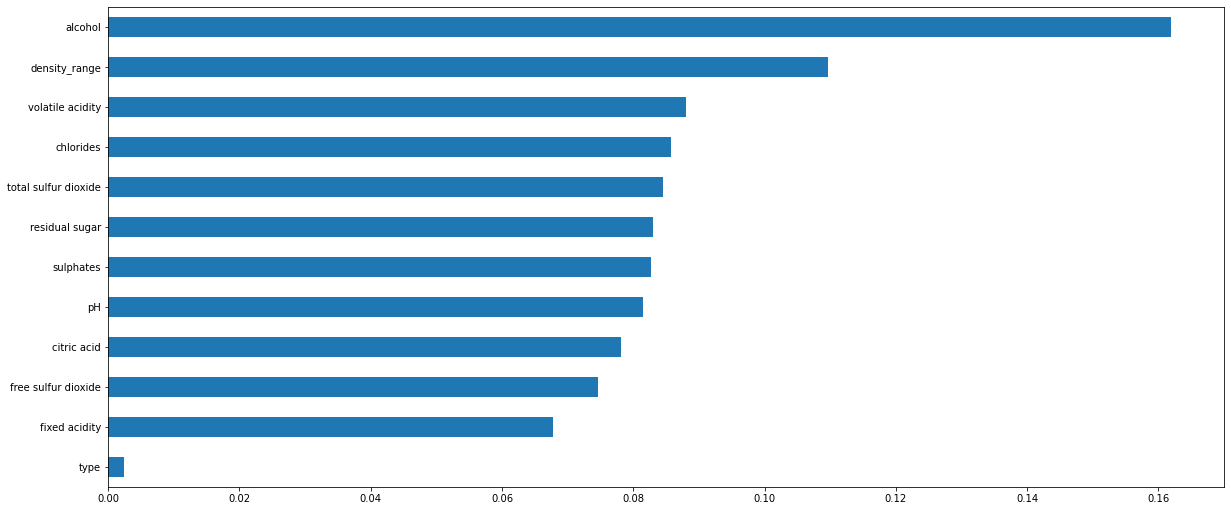

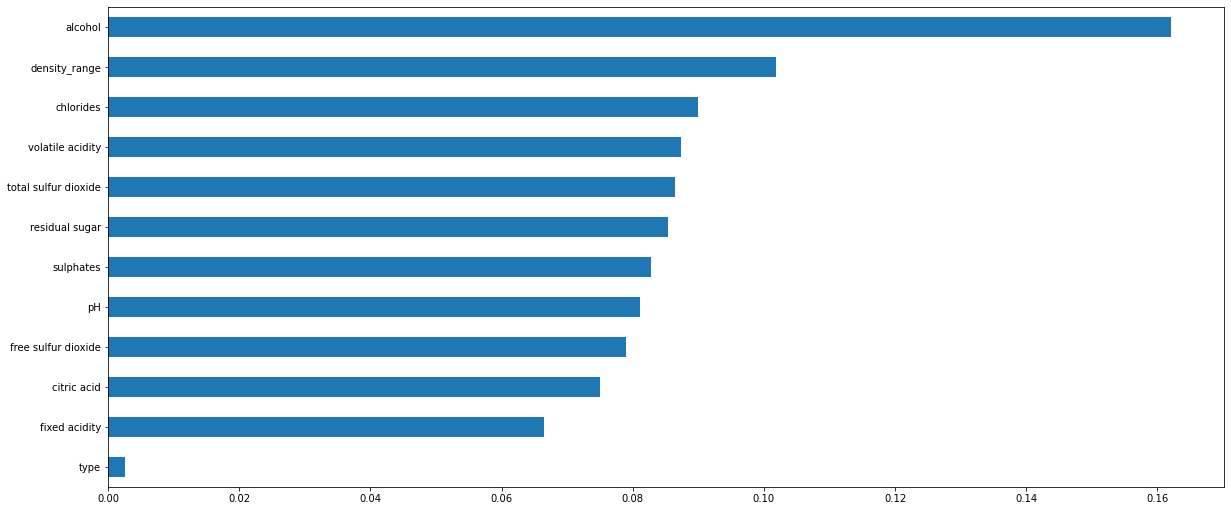

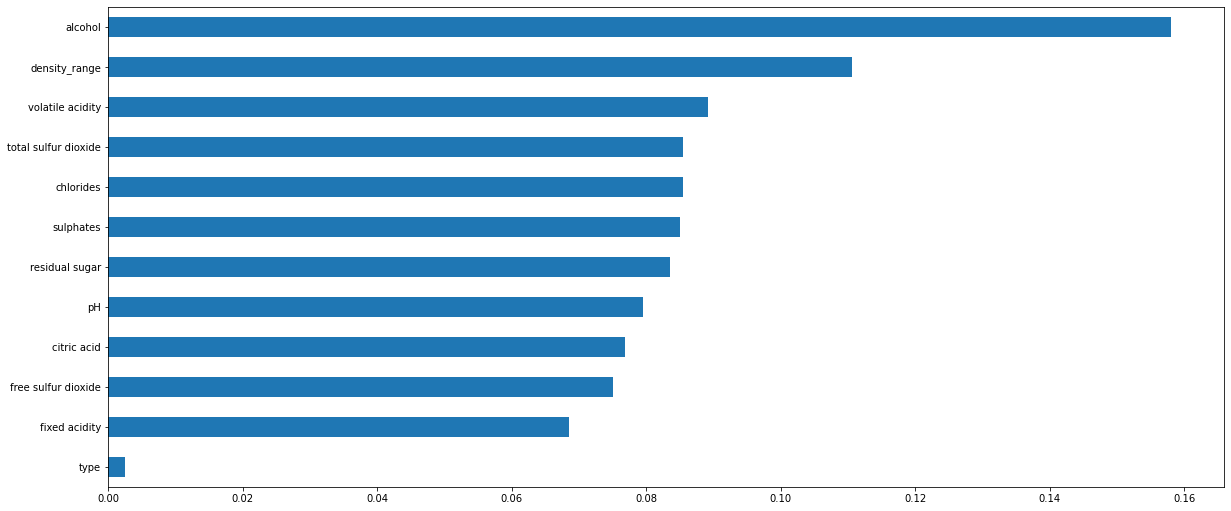

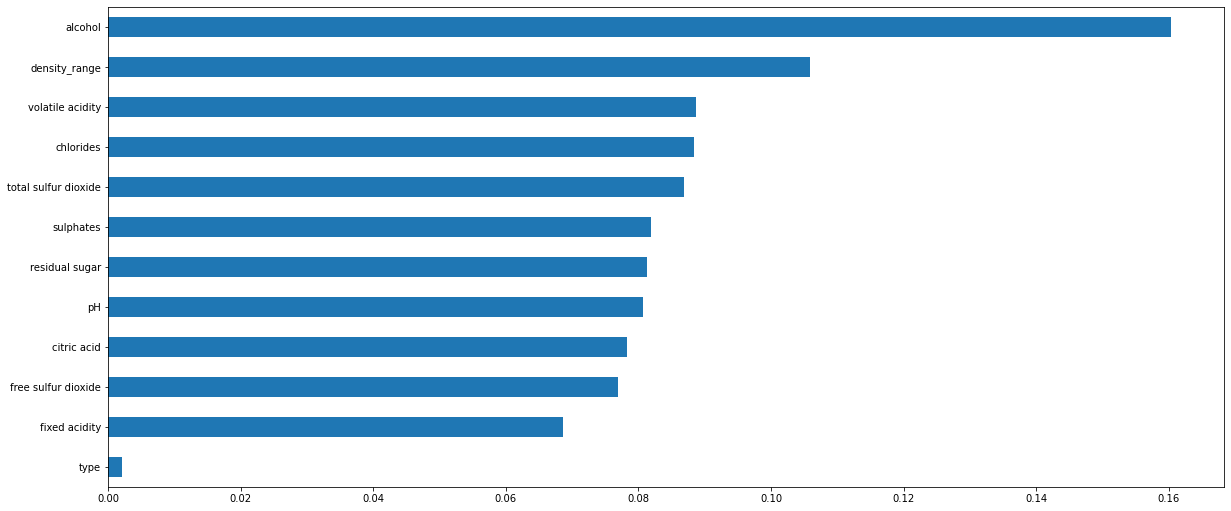

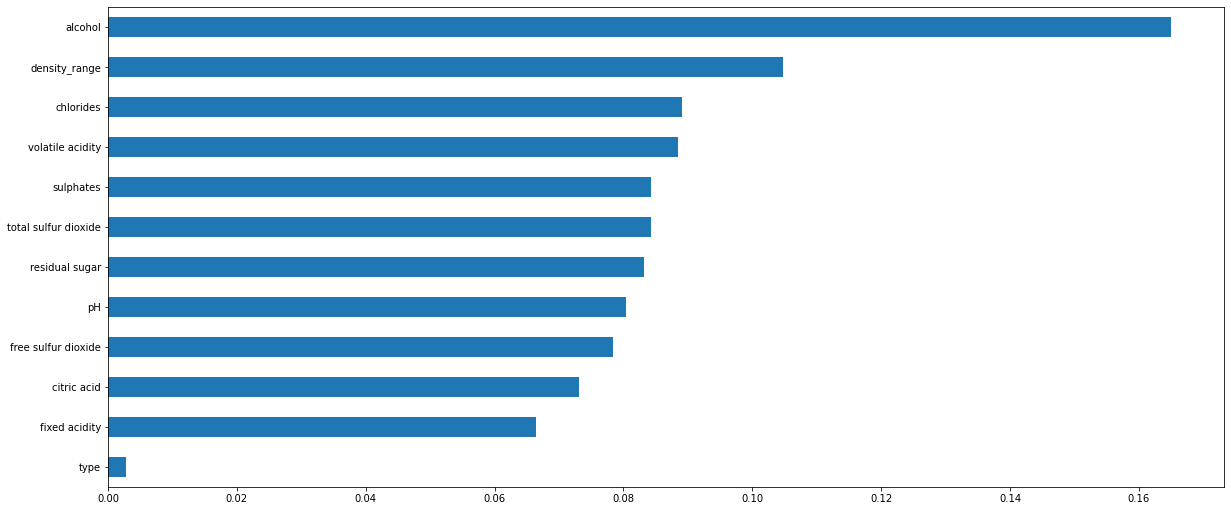

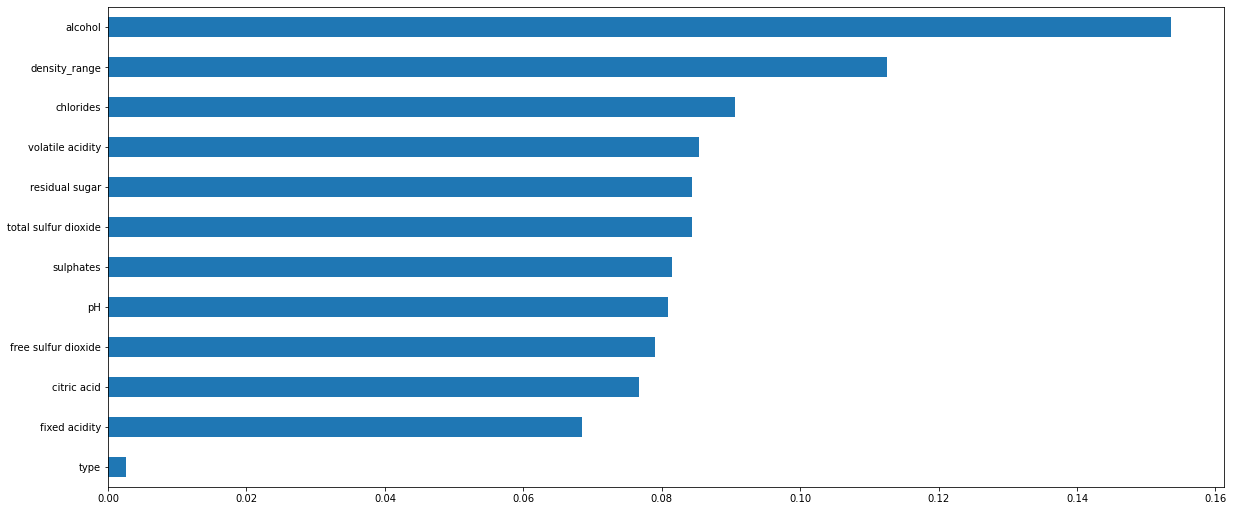

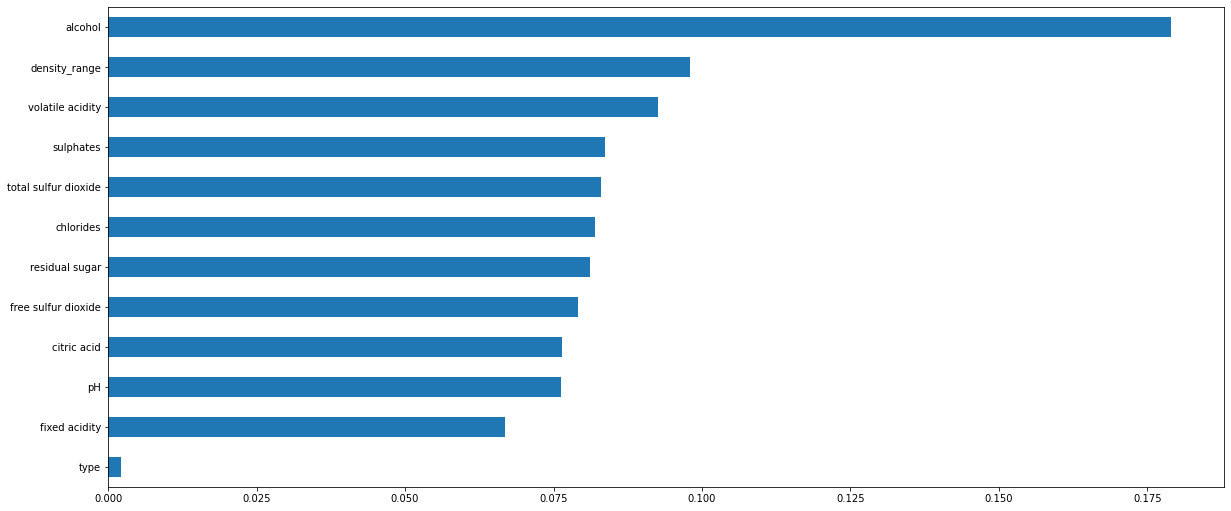

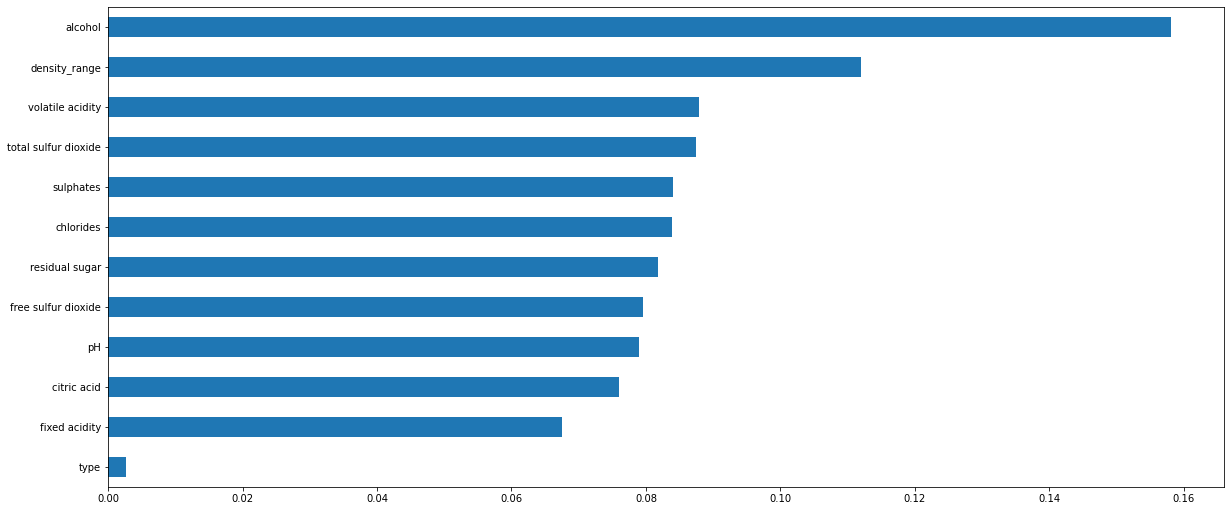

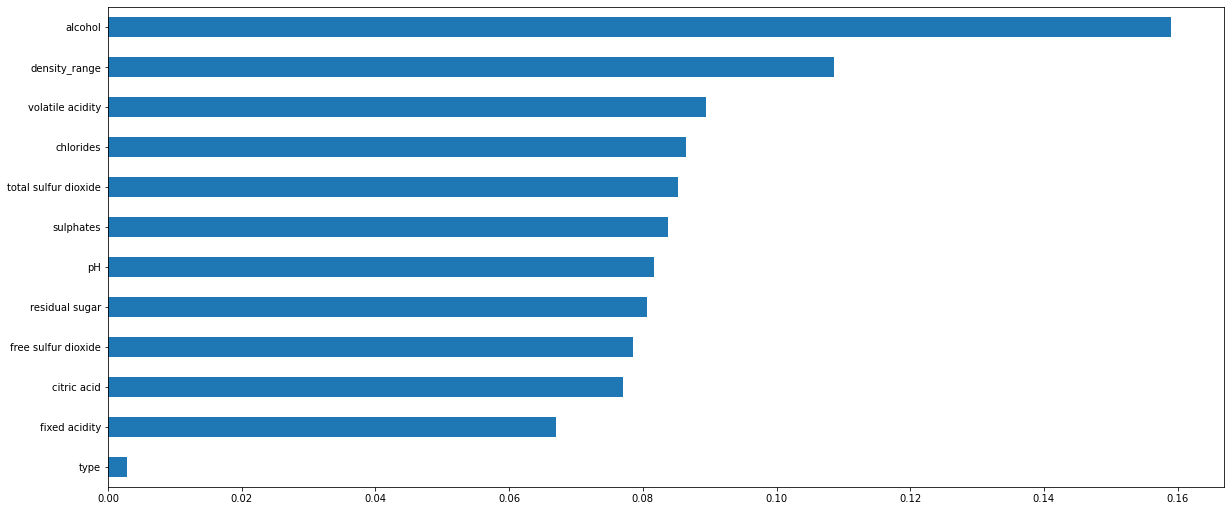

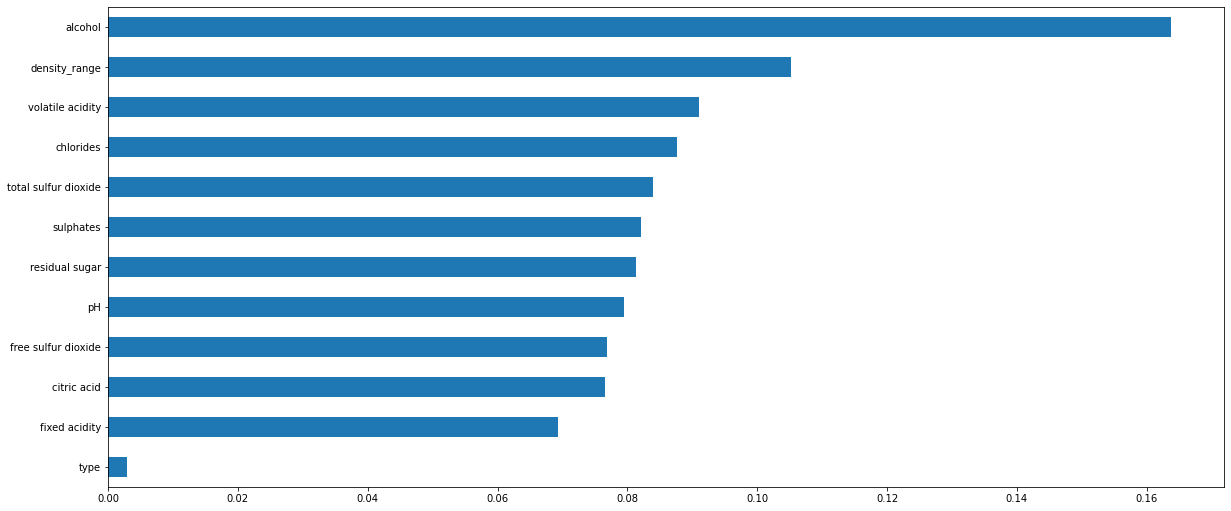

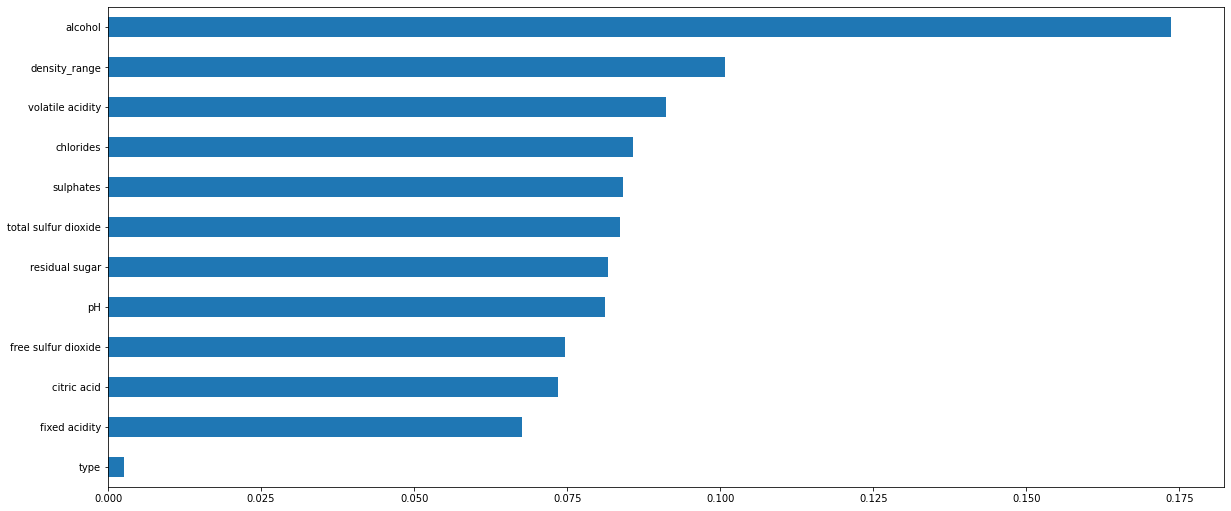

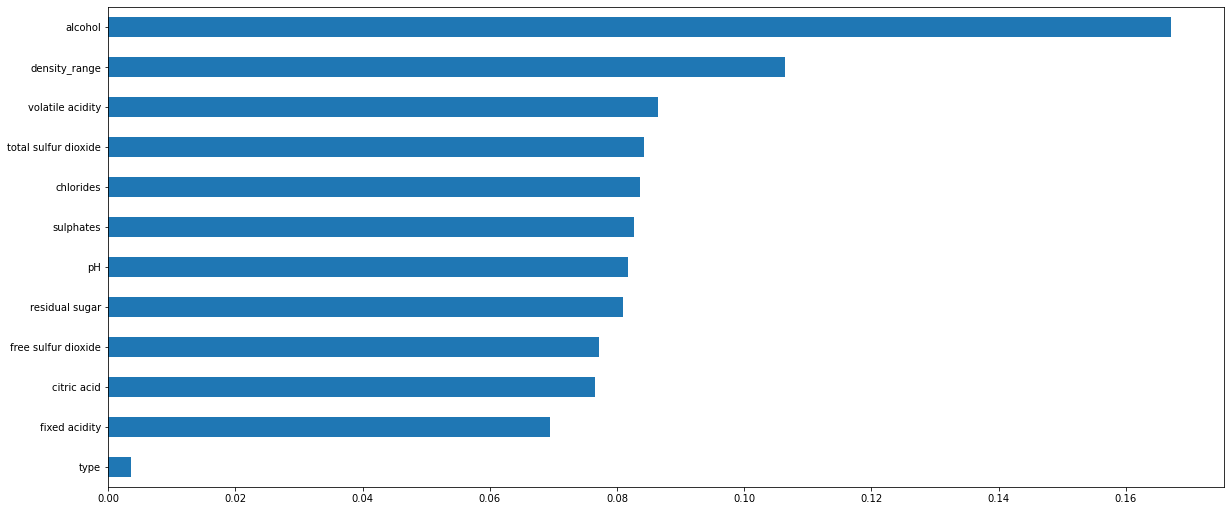

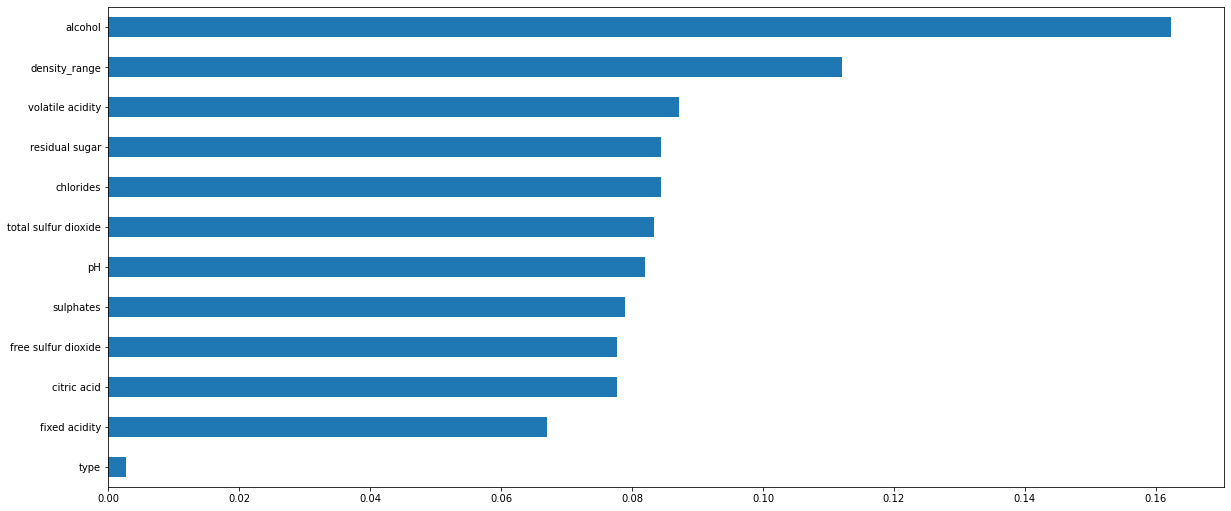

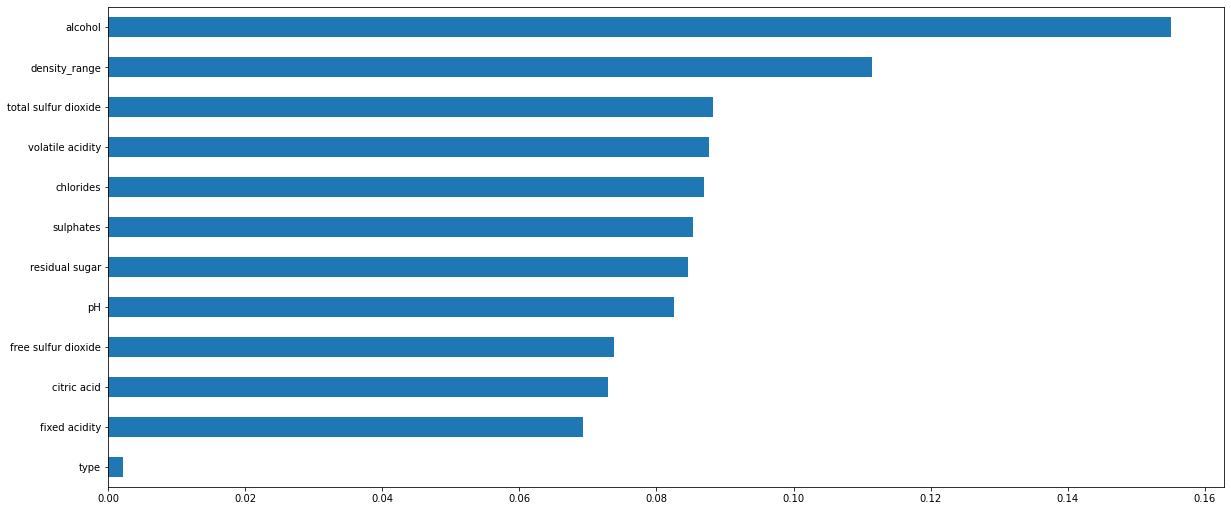

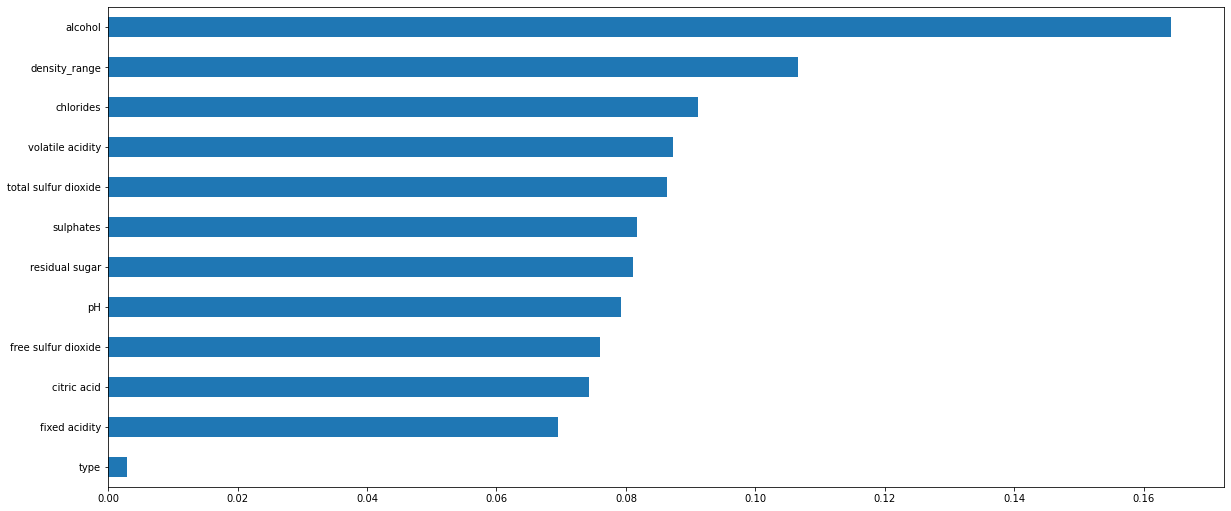

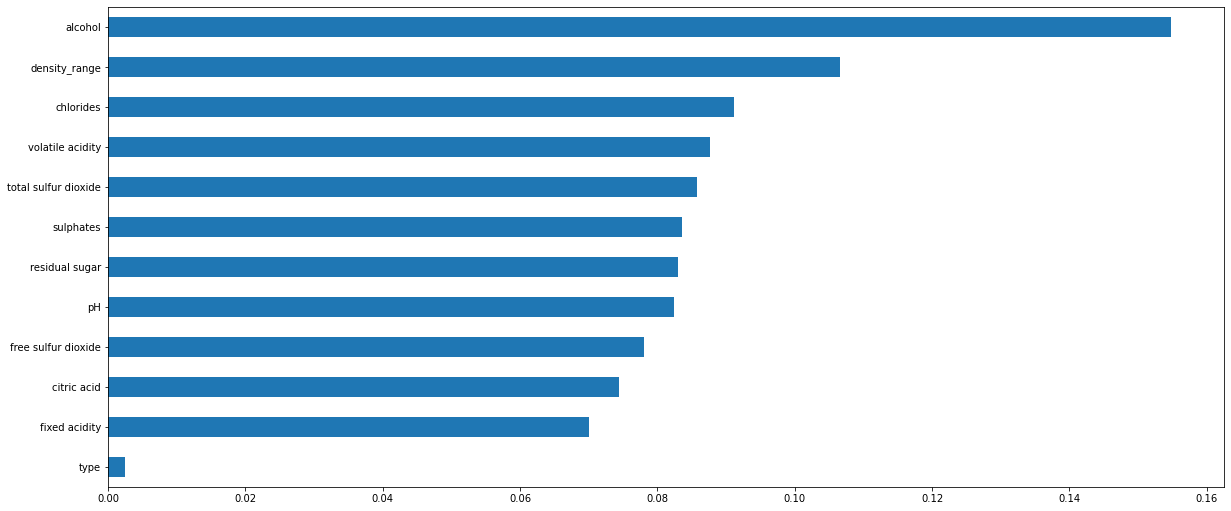

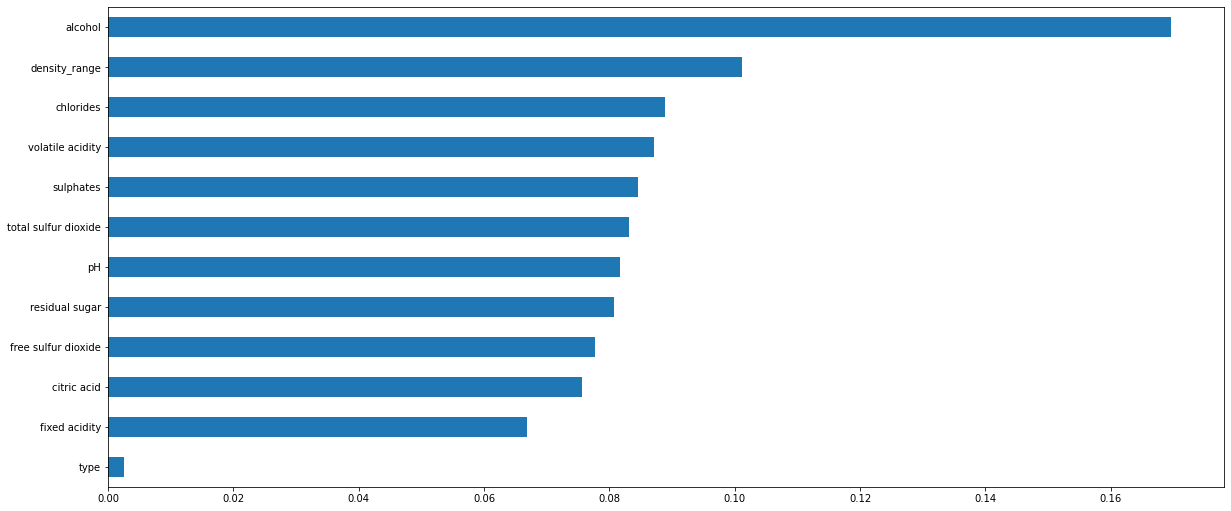

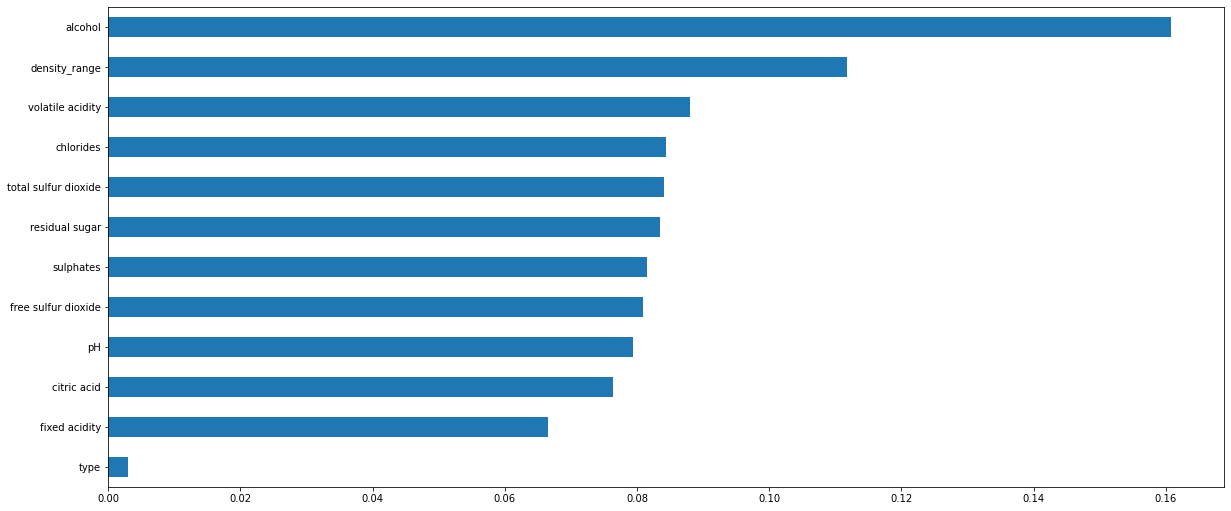

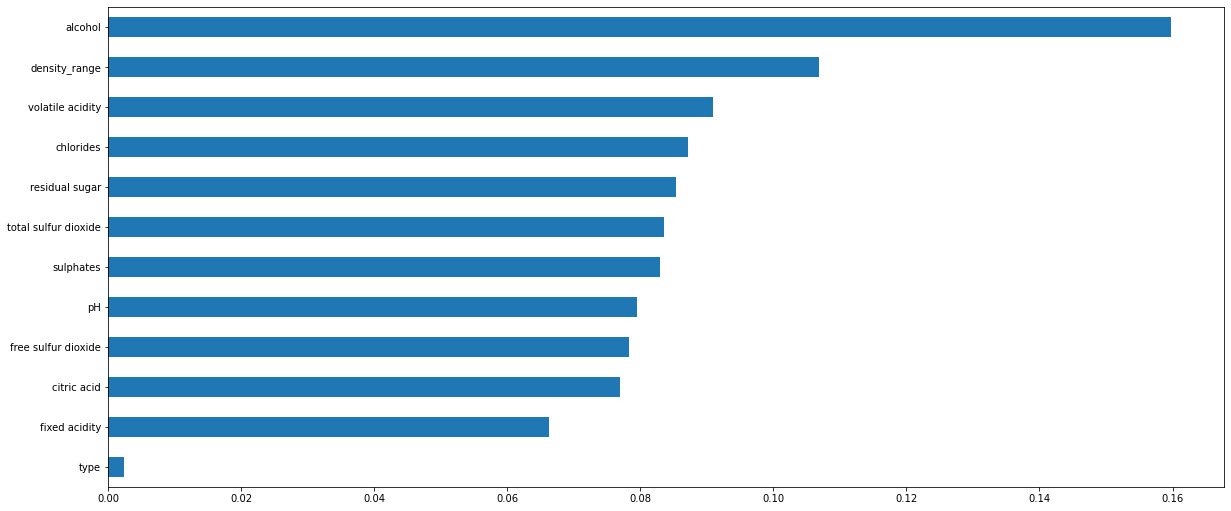

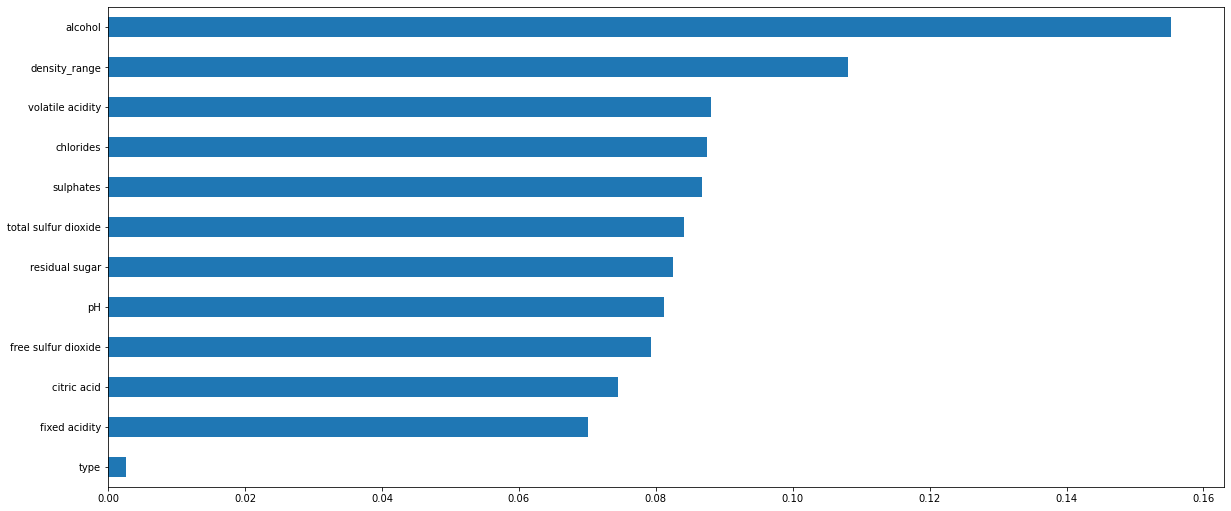

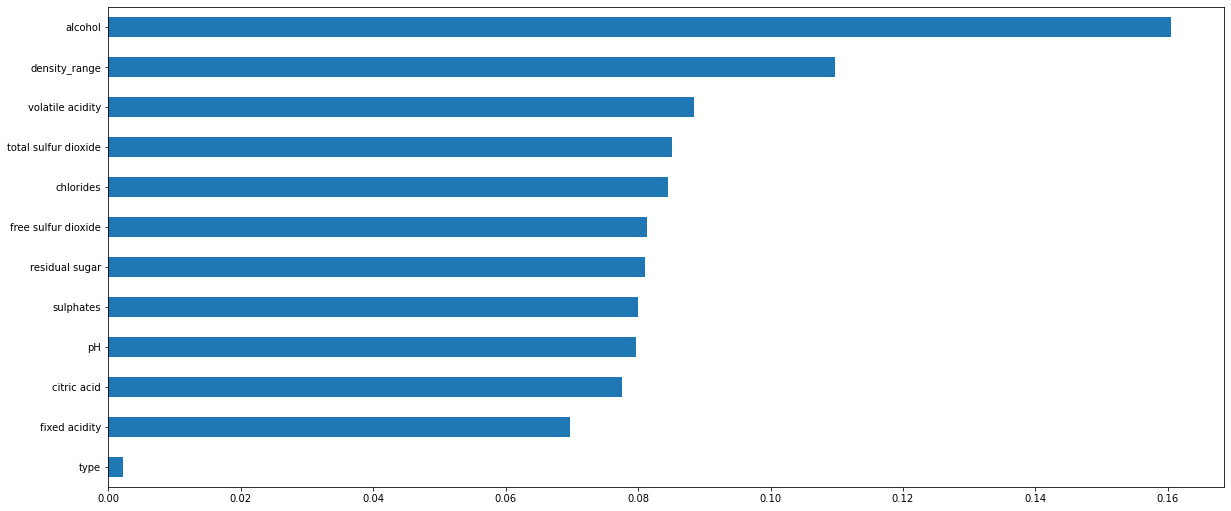

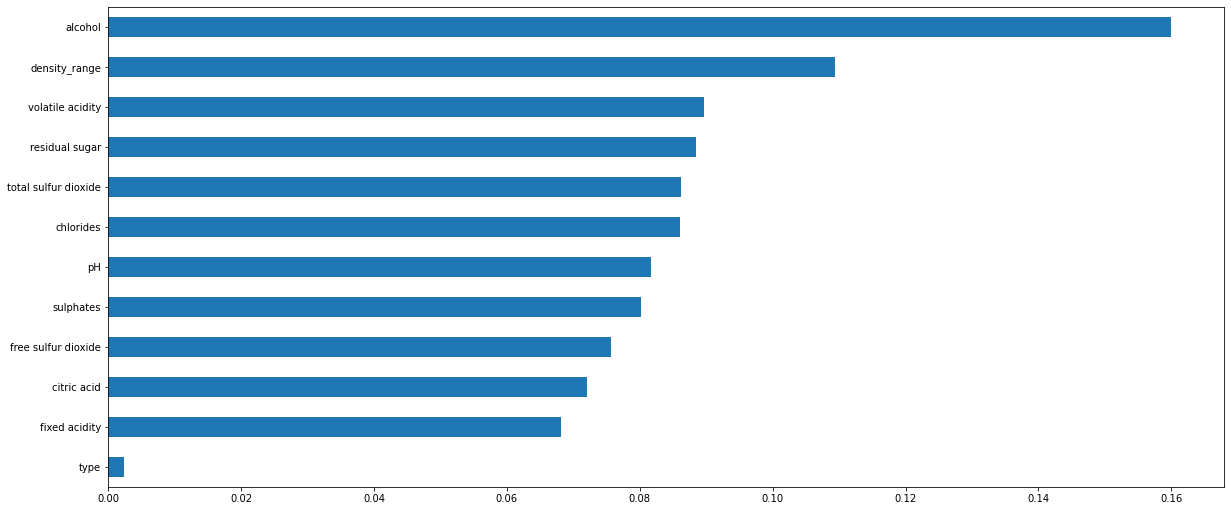

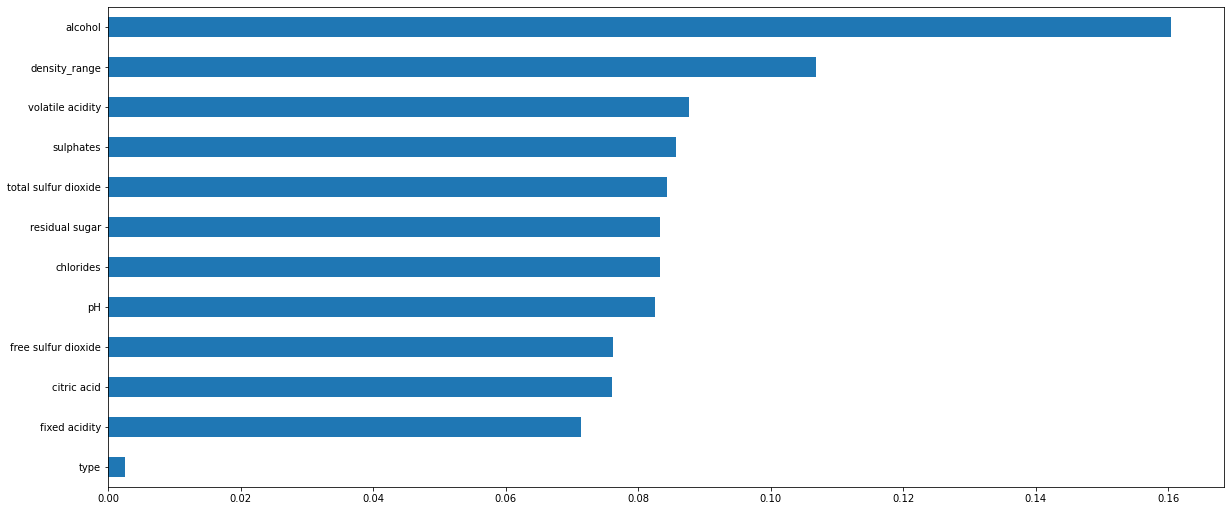

In [ ]:
df_eda1=df.copy()
for j in df_eda1.drop(columns=['type','quality']).columns:
    for i in df_eda1.drop(columns=['type','quality',j]).columns:
        try:
            print(f'{i}/{j}')
            df_eda1[f'{i}/{j}']=df_eda1[i]/df_eda1[j]
            test_df(df_eda)
        except ValueError:
            pass  # do nothing!
        except TypeError:
            pass
        df_eda1.drop(columns=f'{i}/{j}',inplace=True)

### feature engineering based on attributes interactions

From the broad screen we made in preivious step we filtered only the engineered relations showing positive contribution to our model (listed below). 

In [ ]:
df_eda1=df.copy()
df_eda1['density/alcohol']=df_eda1['density']/df_eda1['alcohol']
df_eda1['pH/residual sugar']=df_eda1['pH']/df_eda1['residual sugar']
df_eda1['volatile acidity/residual sugar']=df_eda1['volatile acidity']/df_eda1['residual sugar']
df_eda1['volatile acidity/total sulfur dioxide']=df_eda1['volatile acidity']/df_eda1['total sulfur dioxide']
df_eda1['citric acid/chlorides']=df_eda1['citric acid']/df_eda1['chlorides']
df_eda1['residual sugar']=df_eda1['residual sugar']/df_eda1['chlorides']
df_eda1['sulphates/total sulfur dioxide']=df_eda1['sulphates']/df_eda1['total sulfur dioxide']
df_eda1['alcohol/total sulfur dioxide']=df_eda1['alcohol']/df_eda1['total sulfur dioxide']
df_eda1['residual sugar/sulphates']=df_eda1['residual sugar']/df_eda1['sulphates']
df_eda1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   type                                   6463 non-null   int64  
 1   fixed acidity                          6463 non-null   float64
 2   volatile acidity                       6463 non-null   float64
 3   citric acid                            6463 non-null   float64
 4   residual sugar                         6463 non-null   float64
 5   chlorides                              6463 non-null   float64
 6   free sulfur dioxide                    6463 non-null   float64
 7   total sulfur dioxide                   6463 non-null   float64
 8   density                                6463 non-null   float64
 9   pH                                     6463 non-null   float64
 10  sulphates                              6463 non-null   float64
 11  alco


TRAIN:
not_premium    4153
premium        1017
Name: quality, dtype: int64
loss: 0.1457
              precision    recall  f1-score   support

 not_premium       0.97      1.00      0.99      4153
     premium       0.99      0.89      0.94      1017

    accuracy                           0.98      5170
   macro avg       0.98      0.94      0.96      5170
weighted avg       0.98      0.98      0.98      5170



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3759
              precision    recall  f1-score   support

 not_premium       0.89      0.97      0.93      1039
     premium       0.81      0.48      0.61       254

    accuracy                           0.88      1293
   macro avg       0.85      0.73      0.77      1293
weighted avg       0.87      0.88      0.86      1293




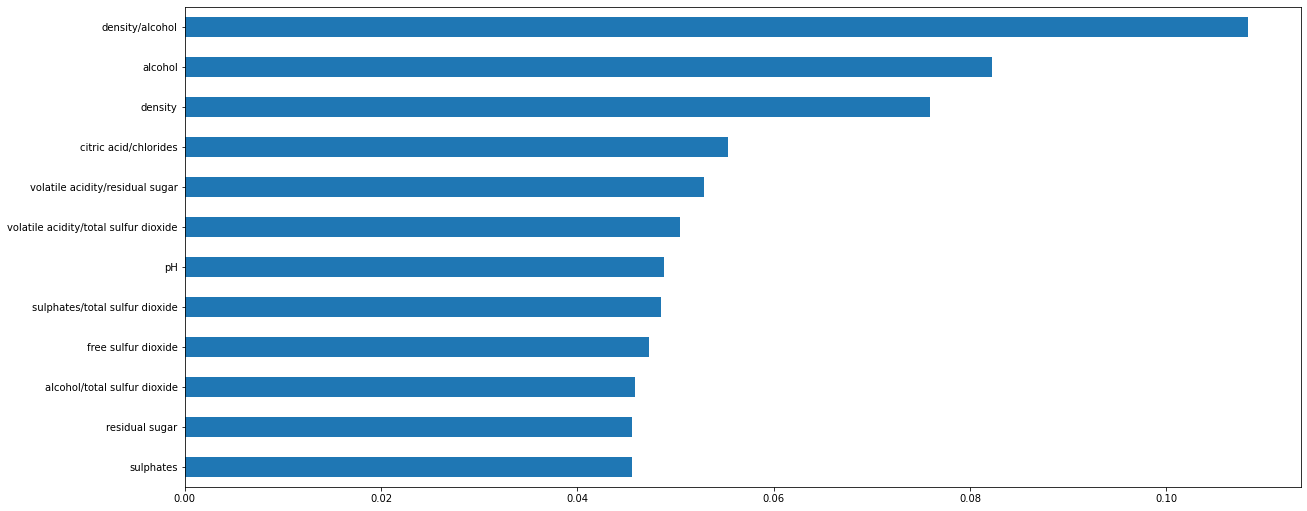

In [ ]:
test_df(df_eda1.drop(columns='type'),'quality',0.5)

Results:
<br> Recall = 0.50
<br> f1 ratio = 0.65

In [ ]:
permutation_test(df_eda1.drop(columns='type'))

0.8762088974854932 0.8700696055684455 0.979110251450677


Surprisingly, the ansamble of all the positive contributing interactions have not improved the model values. <br> permutation test validate the importance of "alcohol" and "density" on our model.

# Model #7

In order to deal with the imbalanced "Preminum"/"non-Premium" ratio, we decided to multiply the "Premium" samples by 10.


TRAIN:
premium        11187
not_premium     4153
Name: quality, dtype: int64
loss: 0.0366
              precision    recall  f1-score   support

 not_premium       1.00      0.99      1.00      4153
     premium       1.00      1.00      1.00     11187

    accuracy                           1.00     15340
   macro avg       1.00      1.00      1.00     15340
weighted avg       1.00      1.00      1.00     15340



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.3210
              precision    recall  f1-score   support

 not_premium       0.93      0.89      0.91      1039
     premium       0.62      0.74      0.67       254

    accuracy                           0.86      1293
   macro avg       0.77      0.81      0.79      1293
weighted avg       0.87      0.86      0.86      1293




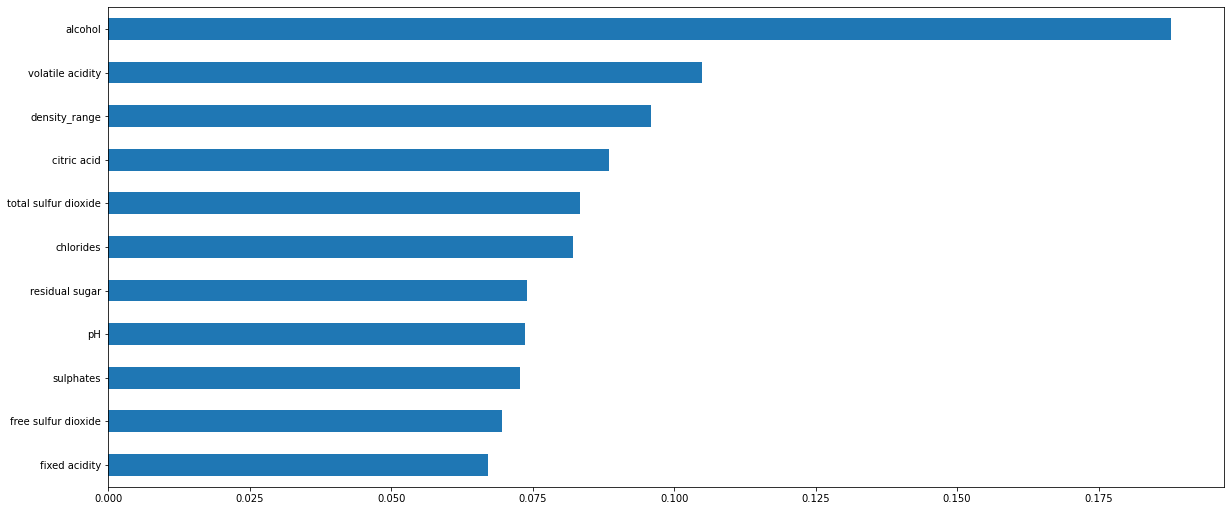

In [ ]:
test_df(df_eda.drop(columns='type'),'quality',0.5,ib=True)

The confusion metrices shows Over fitting on the train data. <br> Results:
<br> Recall = 0.75
<br> f1 ratio = 0.68

# Model #8 Final

Our final model dealing with over fitting will reduce the max samples to 0.2


TRAIN:
premium        11187
not_premium     4153
Name: quality, dtype: int64
loss: 0.1021
              precision    recall  f1-score   support

 not_premium       1.00      0.87      0.93      4153
     premium       0.95      1.00      0.98     11187

    accuracy                           0.96     15340
   macro avg       0.98      0.93      0.95     15340
weighted avg       0.97      0.96      0.96     15340



TEST:
not_premium    1039
premium         254
Name: quality, dtype: int64
loss: 0.4337
              precision    recall  f1-score   support

 not_premium       0.96      0.77      0.85      1039
     premium       0.48      0.86      0.61       254

    accuracy                           0.79      1293
   macro avg       0.72      0.81      0.73      1293
weighted avg       0.86      0.79      0.80      1293




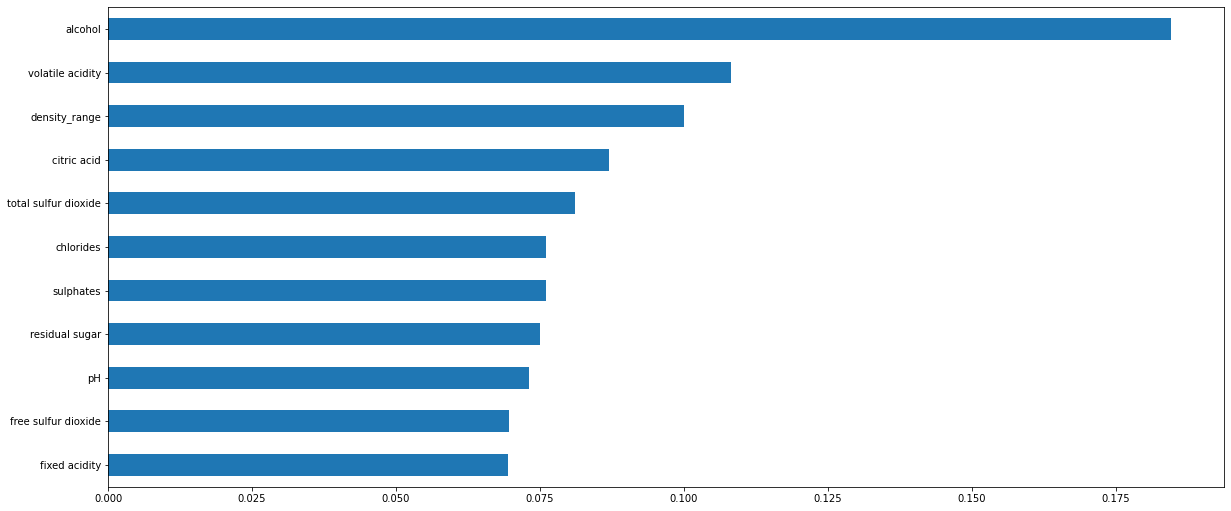

In [ ]:
test_df(df_eda.drop(columns='type'),'quality',0.2,ib=True)

**Final Results:**
<br> **Recall = 0.85**
<br> **f1 ratio = 0.62**

# **Conclusion**

The wine quality dataset is highly imbalanced; white vs red and premium vs non-premium. As a result, all our EDA and feature engineering efforts showed mild effect on the model performance. In fact, the two most critical factors in improving our model were the maximum samples and the correction to the overfitted parameters of the model. In addition, it is importent to note that the f1 ratio was to some extend stable even with the final parameters.<br> Our bast and latest ran consisted of max samples = 0.2 and use of oversampling function. 
<br> Final results:
<br> Recall = 0.85
<br> f1 ration = 0.62

Final validation on our hypothesis that the "type" column is of high importance to the data was shown by the following two runs; demonstrating the effect of the maximum sample and oversampling directly on only "white" dataset.


TRAIN:
premium        9273
not_premium    3053
Name: quality, dtype: int64
loss: 0.0364
              precision    recall  f1-score   support

 not_premium       1.00      0.99      1.00      3053
     premium       1.00      1.00      1.00      9273

    accuracy                           1.00     12326
   macro avg       1.00      1.00      1.00     12326
weighted avg       1.00      1.00      1.00     12326



TEST:
not_premium    763
premium        211
Name: quality, dtype: int64
loss: 0.3202
              precision    recall  f1-score   support

 not_premium       0.93      0.89      0.91       763
     premium       0.66      0.74      0.70       211

    accuracy                           0.86       974
   macro avg       0.79      0.82      0.80       974
weighted avg       0.87      0.86      0.86       974




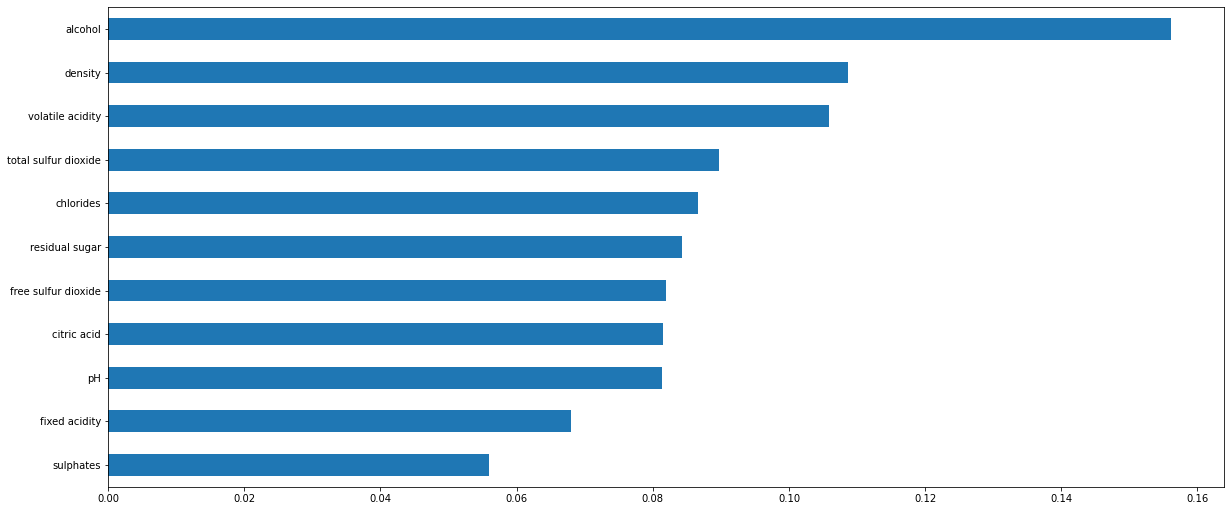

In [ ]:
test_df(df_white,'quality',0.5,ib=True)

Over fitted results:
<br> Recall = 0.74
<br> f1 ratio = 0.70

Reducing the max_samples = 0.2


TRAIN:
premium        9273
not_premium    3053
Name: quality, dtype: int64
loss: 0.1041
              precision    recall  f1-score   support

 not_premium       1.00      0.85      0.92      3053
     premium       0.95      1.00      0.98      9273

    accuracy                           0.96     12326
   macro avg       0.98      0.93      0.95     12326
weighted avg       0.96      0.96      0.96     12326



TEST:
not_premium    763
premium        211
Name: quality, dtype: int64
loss: 0.4421
              precision    recall  f1-score   support

 not_premium       0.96      0.76      0.85       763
     premium       0.50      0.88      0.64       211

    accuracy                           0.79       974
   macro avg       0.73      0.82      0.74       974
weighted avg       0.86      0.79      0.80       974




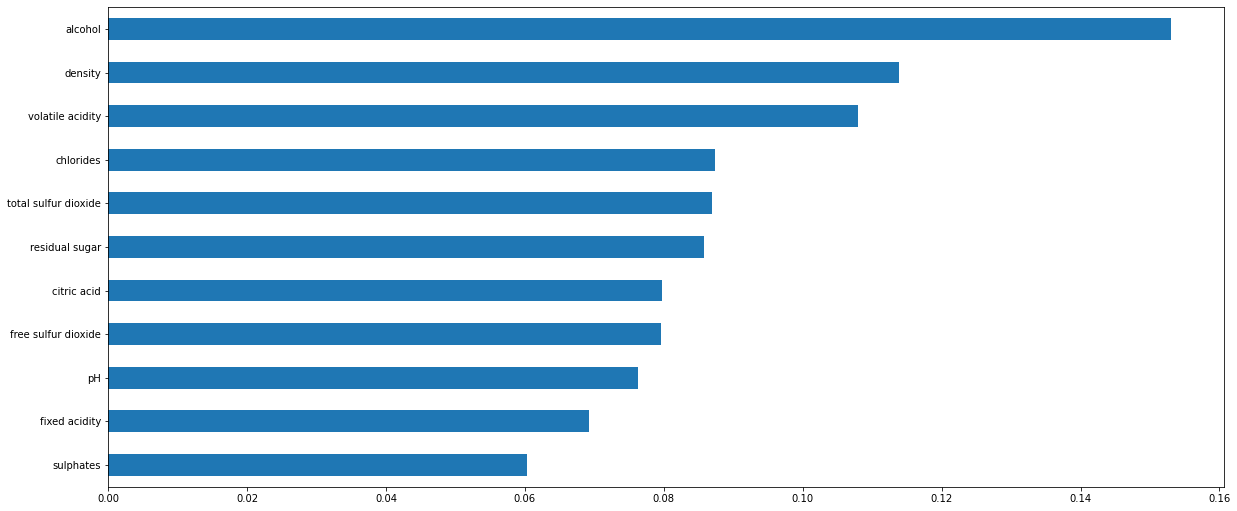

In [ ]:
test_df(df_white,'quality',0.2,ib=True)

The strength of the sample size and oversampling is clearly shown here, with an amazing improvement on the Recall (while slightly reducing the f1 ratio) <br>Results:
<br> **Recall = 0.88**
<br> **f1 ratio = 0.65**